# TensorFlow 2.0 Tutorial

NOTE: This notebook is meant to teach you the latest version of Tensorflow 2.0. Most examples on the web today are still in 1.x, so be careful not to confuse the two when looking up documentation.

## Install Tensorflow 2.0

If you would like to run this notebook on your local machine, please make sure you follow steps to install the dependencies. You will need TensorFlow version 2.0, and here are some tips to get you started. Please note that Tensorflow 2.0 is still not in a fully 100% stable release, but it's still usable and more intuitive than TF 1.x.

     1. Have the latest version of Anaconda installed on your machine.
     2. Create a new conda environment starting from Python 3.7. In this setup example, we'll call it tf_20_env.
     3. Run the command: source activate tf_20_env
     4. Then pip install TF 2.0 as described here: https://www.tensorflow.org/install/pip
     

A guide on creating Anaconda enviornments: https://uoa-eresearch.github.io/eresearch-cookbook/recipe/2014/11/20/conda/

This will give you an new enviornemnt to play in TF 2.0. Generally, if you plan to also use TensorFlow in your other projects, you might also want to keep a seperate Conda environment or virtualenv in Python 3.7 that has Tensorflow 1.9, so you can switch back and forth at will.
     

In [63]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow import keras
from tensorflow.keras import Model

import matplotlib.pyplot as plt

## Loading the Data

For this part, we will work with the MNIST data. We will demonstrate how the built-in dataset works in TensorFlow.

In [64]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

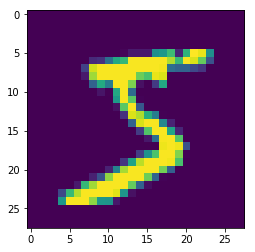

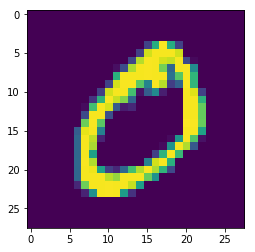

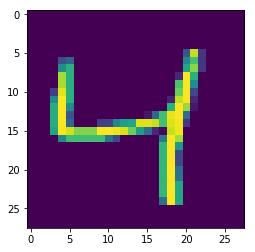

In [65]:
for image in x_train[:3]:
    plt.figure()
    plt.imshow(image)

## Starting Simple: Using the Keras Sequential API

As you will quickly see, there are a ton of ways in TensorFlow to build models and train them. TensorFlow has many APIs that you can use, and all these APIs can be confusing. We start this tutorial with the simplest way to build a model in TensorFlow 2.0: using the Keras Sequential API.

We will first build the tf.keras.Sequential model by stacking layers.   

In [66]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [67]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 3s 47us/sample - loss: 0.3016 - accuracy: 0.9123
Epoch 2/5
60000/60000 [==============================] - 3s 45us/sample - loss: 0.1449 - accuracy: 0.9574
Epoch 3/5
60000/60000 [==============================] - 3s 45us/sample - loss: 0.1084 - accuracy: 0.9674
Epoch 4/5
60000/60000 [==============================] - 3s 45us/sample - loss: 0.0895 - accuracy: 0.9730
Epoch 5/5
60000/60000 [==============================] - 3s 45us/sample - loss: 0.0765 - accuracy: 0.9757


In [68]:
test_loss, test_acc = model.evaluate(x_test, y_test)

print('\nTest accuracy:', test_acc)

10000/10000 [==============================] - 0s 28us/sample - loss: 0.0803 - accuracy: 0.9764

Test accuracy: 0.9764


## More advanced: Writing a custom training loop with Gradient Tape

Now, we transition to a more advanced usage of TensorFlow. This API will probably be the one you will use the most, as it provides for more flexibility. Note that you can specify more unique architectures with the forward pass. We will use the same MNIST dataset.

In [69]:
# Reload the dataset 
def convert_types(image, label):
  image = tf.cast(image, tf.float32)
  image /= 255
  return image, label

dataset, info = tfds.load('mnist', data_dir='gs://tfds-data/datasets', with_info=True, as_supervised=True)
mnist_train, mnist_test = dataset['train'], dataset['test']
mnist_train = mnist_train.map(convert_types).shuffle(10000).batch(32)
mnist_test = mnist_test.map(convert_types).batch(32)

Now, we will go ahead and build the model using tf.keras. Note how building the model this way allows for a greater degree of control over the model.

In [70]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10, activation='softmax')

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

model = MyModel()
print(dir(model))
tf.print("In Model")

['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_activity_regularizer', '_add_inbound_node', '_add_unique_metric_name', '_add_variable_with_custom_getter', '_all_metrics_tensors', '_all_stateful_metrics_tensors', '_base_init', '_cache_output_metric_attributes', '_call_convention', '_call_fn_for_each_replica', '_call_metric_fn', '_check_trainable_weights_consistency', '_checkpoint_dependencies', '_clear_losses', '_compile_distribution', '_compute_output_and_mask_jointly', '_deferred_dependencies', '_determine_call_convention', '_distribution_standardize_user_data', '_distribution_strategy', '_dtype', '_dynamic', '_eager_add_metric', '_eager_losses', '_expects_training_arg', '_gather

We need to specify an optimizer and loss function, along with metrics:

In [71]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

Now, we can write our train function:

In [78]:
@tf.function
def train_step(image, label):
  with tf.GradientTape() as tape:
    predictions = model(image)
#     tf.print(predictions.shape)
    loss = loss_object(label, predictions)
#     tf.print(loss)
#   tf.print(train_loss.total)
#   tf.print(train_loss.count)
    tf.print(model.layers[0].name)
    tf.print(model.layers[0].weights)

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  
  train_accuracy(label, predictions)

Note the tf.function annotation on the function above. This means that this function will be compiled into a graph in the backend, allowing it to run efficiently as TensorFlow can optimize the function for you. This automatic conversion of Python code to its graph representation is called AutoGraph, and this creates callable graphs from Python functions.

What is this gradient tape?

In [79]:
x = tf.Variable(3.0)
with tf.GradientTape() as g:
  y = x * x
  print(y)
    
dy_dx = g.gradient(y, x) # Will compute to 6.0
print(dy_dx)

tf.Tensor(9.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


Trainable variables are automatically watched within the GradientTape (when trainable=True, as we will see this is not always the case later in the notebook). Variables are trainable when created by tf.Variable, but not when created via tf.constant. In those cases, if you want to compute the gradients of non-trainable variables, you can manually watch the tensors using the watch function, as shown below.

In [80]:
x = tf.constant(3.0)
with tf.GradientTape() as g:
  g.watch(x)
  y = x * x
dy_dx = g.gradient(y, x) # Will compute to 6.0
print(dy_dx)

tf.Tensor(6.0, shape=(), dtype=float32)


Now we can define our test function:

In [81]:
@tf.function
def test_step(image, label):
  predictions = model(image)
  print(predictions)
  t_loss = loss_object(label, predictions)

  test_loss(t_loss)
  test_accuracy(label, predictions)

We are ready to train the model!

In [82]:
EPOCHS = 1
# i = 0

for epoch in range(EPOCHS):
  for image, label in mnist_train:
#     print("i={}".format(i))
    train_step(image, label)
#     i+=1

  for test_image, test_label in mnist_test:
    test_step(test_image, test_label)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print (template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result()*100,
                         test_loss.result(),
                         test_accuracy.result()*100))

conv2d_20
[[[[[0.0702687874 0.130245253 0.0735688955 ... 0.0254020151 -0.0107170958 -0.0223931428]]

  [[0.0505884439 0.0569423102 0.0287212264 ... 0.122387163 -0.064593479 0.0210657958]]

  [[-0.0233301017 -0.232438877 0.108482182 ... -0.192575887 0.00077546353 0.0695576891]]]


 [[[0.0475998744 0.268655568 0.0107757244 ... 0.0920147896 -0.023703713 0.0552065521]]

  [[-0.0527325 0.0106166592 -0.157396063 ... -0.0295414738 0.0391967855 0.00306085101]]

  [[0.137631834 -0.326505 -0.157374755 ... -0.0883349925 0.122337982 0.0585234575]]]


 [[[0.12049491 0.18146652 0.0175970886 ... 0.130250439 0.0268211551 0.110881545]]

  [[-0.0855252072 -0.0900223181 -0.0409531072 ... -0.0593023673 -0.105436713 -0.109547757]]

  [[0.0435738713 -0.368885666 0.179583684 ... -0.0321670249 -0.137083858 0.0748126209]]]], [-0.129792705 -0.0600013658 -0.111171991 ... -0.0993164778 -0.0317856632 -0.114888936]]
conv2d_20
[[[[[0.0706177875 0.130329117 0.0734626427 ... 0.0254877284 -0.0107577564 -0.0220520701]]


conv2d_20
[[[[[0.07358329 0.13000387 0.0732232779 ... 0.0256996509 -0.0108006382 -0.0185721628]]

  [[0.0539336689 0.0560471304 0.0283096712 ... 0.122508012 -0.0647195056 0.0252717547]]

  [[-0.0205250457 -0.234165713 0.108599886 ... -0.192837104 0.00126824388 0.0737148449]]]


 [[[0.0512151085 0.268195301 0.0106706917 ... 0.0923725963 -0.0237444714 0.0587538779]]

  [[-0.0497491956 0.00946519 -0.157557517 ... -0.0296234433 0.0394042432 0.00666150637]]

  [[0.139658362 -0.328204751 -0.156905174 ... -0.0886175931 0.123252816 0.0621750802]]]


 [[[0.123220056 0.180809692 0.01717389 ... 0.130385607 0.0269781239 0.113995031]]

  [[-0.0838918164 -0.0915568173 -0.0411985107 ... -0.0604088977 -0.105339624 -0.106906176]]

  [[0.0445519499 -0.369765252 0.179744393 ... -0.0331653059 -0.136466667 0.0773875713]]]], [-0.12679866 -0.0602720305 -0.111354902 ... -0.0989870131 -0.0308624804 -0.110967591]]
conv2d_20
[[[[[0.0738142431 0.129960448 0.0732177943 ... 0.0257113092 -0.0107898051 -0.0182945728]

conv2d_20
[[[[[0.0721471384 0.128620237 0.0739768371 ... 0.0230306312 -0.0111254333 -0.0179181397]]

  [[0.0527770035 0.053982269 0.0275089294 ... 0.119427927 -0.0644716322 0.0267253034]]

  [[-0.0228502508 -0.235291928 0.108329155 ... -0.193711817 0.00340498 0.0735172108]]]


 [[[0.0498426296 0.265827656 0.0116799623 ... 0.0895051956 -0.0238092616 0.0594432317]]

  [[-0.0522095338 0.00653509749 -0.157532319 ... -0.0332976691 0.039634008 0.00679549063]]

  [[0.13620922 -0.329701304 -0.155618042 ... -0.0899932161 0.125092193 0.0611654893]]]


 [[[0.121650934 0.178386599 0.0175454915 ... 0.127526924 0.0272580441 0.115008712]]

  [[-0.0866358131 -0.0932823941 -0.0417231396 ... -0.0623327754 -0.10520304 -0.107131645]]

  [[0.0416537486 -0.369214714 0.181099147 ... -0.0331190266 -0.135882 0.0765575767]]]], [-0.129397601 -0.0619922206 -0.110511869 ... -0.101807751 -0.0290588923 -0.110535122]]
conv2d_20
[[[[[0.0716357753 0.128591239 0.0740274265 ... 0.0228691753 -0.0112194959 -0.0182840955]]


conv2d_20
[[[[[0.0704872161 0.128926545 0.0765997842 ... 0.0213057064 -0.0103745013 -0.0179685801]]

  [[0.0525556318 0.053671021 0.028719984 ... 0.118813828 -0.0640775859 0.027676411]]

  [[-0.0234741 -0.235572383 0.110060386 ... -0.194596186 0.00432319334 0.073577255]]]


 [[[0.0479529 0.265247285 0.0135883102 ... 0.0872381777 -0.0239014011 0.0592542626]]

  [[-0.0536211357 0.00567850471 -0.157134026 ... -0.0342000276 0.0395973921 0.00604780577]]

  [[0.135709852 -0.330463141 -0.154242605 ... -0.0887995735 0.126026213 0.0602498278]]]


 [[[0.120239317 0.177496433 0.0198568851 ... 0.124847755 0.0253773872 0.11542359]]

  [[-0.0888422281 -0.0932491794 -0.0400712863 ... -0.0620091073 -0.106762066 -0.108389266]]

  [[0.0404479243 -0.368733436 0.183648393 ... -0.0322502851 -0.135993078 0.0747968554]]]], [-0.129809543 -0.061712753 -0.107032299 ... -0.104026496 -0.0280619059 -0.109274477]]
conv2d_20
[[[[[0.0704190731 0.129040107 0.0766400769 ... 0.0213934556 -0.010322961 -0.0180295575]]

  

conv2d_20
[[[[[0.0686716214 0.132147595 0.0767862871 ... 0.023969939 -0.00888588745 -0.021464536]]

  [[0.0501301512 0.0564812459 0.0293159038 ... 0.122055836 -0.0626762435 0.0240464602]]

  [[-0.0259833708 -0.233787522 0.110954769 ... -0.191720039 0.00543311704 0.0704430863]]]


 [[[0.0454229861 0.26894325 0.0128209712 ... 0.0900693163 -0.0226099864 0.0553328469]]

  [[-0.056688346 0.00924347062 -0.157648548 ... -0.0310568959 0.0410479121 0.00169129297]]

  [[0.132867813 -0.328160524 -0.154457524 ... -0.0857818201 0.12722972 0.0563271157]]]


 [[[0.117881484 0.181413934 0.0190697275 ... 0.12751922 0.0253490414 0.111588202]]

  [[-0.0918043 -0.0892407596 -0.0406985469 ... -0.0587420687 -0.106925972 -0.112729847]]

  [[0.0376003534 -0.364699304 0.182596847 ... -0.0286431797 -0.136343315 0.0710968524]]]], [-0.13187252 -0.058169093 -0.106996104 ... -0.101416066 -0.0272813272 -0.112990163]]
conv2d_20
[[[[[0.0684466437 0.132358506 0.0767619759 ... 0.0243410189 -0.00881228689 -0.0219189171]]

conv2d_20
[[[[[0.0652316734 0.134185806 0.0769167542 ... 0.0281166956 -0.00853788387 -0.0256938487]]

  [[0.046562735 0.0577443 0.0295690373 ... 0.125846893 -0.0628908426 0.0198483355]]

  [[-0.029188225 -0.23321864 0.109988809 ... -0.18913655 0.00481385598 0.0668394342]]]


 [[[0.0416364111 0.272947282 0.0124373259 ... 0.095107086 -0.0218078978 0.0507725626]]

  [[-0.0603403784 0.0131463436 -0.157496199 ... -0.0255298279 0.0417897366 -0.00239407062]]

  [[0.128992155 -0.325826794 -0.156074509 ... -0.0804404616 0.127494693 0.0519279353]]]


 [[[0.114667311 0.187126666 0.020282805 ... 0.132764339 0.0257226955 0.107177742]]

  [[-0.0946249664 -0.0828651786 -0.0387965403 ... -0.052093327 -0.106731176 -0.116410159]]

  [[0.0341162048 -0.358485758 0.182831869 ... -0.0223648604 -0.135838971 0.0671878681]]]], [-0.135822251 -0.0544499047 -0.106459886 ... -0.0966391414 -0.0274215154 -0.118056037]]
conv2d_20
[[[[[0.0651551709 0.134152785 0.0769521669 ... 0.028206788 -0.00856989715 -0.0257745087]

conv2d_20
[[[[[0.0645563 0.134297311 0.0776406601 ... 0.0295103863 -0.00903447904 -0.0258905347]]

  [[0.0460133329 0.0577993654 0.0302460808 ... 0.1273157 -0.0639412105 0.0202135183]]

  [[-0.0297943819 -0.233485147 0.110240743 ... -0.188864529 0.00331744063 0.0672847703]]]


 [[[0.041041702 0.273665816 0.0137701361 ... 0.0967295 -0.0218102615 0.0503638685]]

  [[-0.0610930137 0.0139782215 -0.156386033 ... -0.023505358 0.0413230062 -0.00215962133]]

  [[0.127744123 -0.325488746 -0.155823171 ... -0.0786257386 0.126838207 0.0516683422]]]


 [[[0.114315666 0.188162416 0.0225570388 ... 0.134312347 0.0264596064 0.106814638]]

  [[-0.0953342617 -0.0817061588 -0.0364762582 ... -0.0500822067 -0.106345624 -0.116476692]]

  [[0.0329708047 -0.357482344 0.184424 ... -0.0202435572 -0.135360315 0.0665622428]]]], [-0.136625037 -0.0542424023 -0.105366603 ... -0.0955852196 -0.0283279121 -0.118444718]]
conv2d_20
[[[[[0.064609848 0.134279862 0.0776943713 ... 0.0294832047 -0.0091449786 -0.0258279741]]

 

conv2d_20
[[[[[0.0653542 0.132161483 0.0796425119 ... 0.0252215546 -0.00972333 -0.0240987968]]

  [[0.0461174585 0.0542277209 0.0320591666 ... 0.123536244 -0.0654538 0.0222357977]]

  [[-0.0306016281 -0.23747699 0.111943394 ... -0.190937132 0.0011705017 0.0684062392]]]


 [[[0.0417814031 0.270021856 0.014777814 ... 0.0923536569 -0.0228477903 0.0519806705]]

  [[-0.0616884865 0.00864321925 -0.155392274 ... -0.0294989273 0.0390535444 -0.00108127017]]

  [[0.126679137 -0.331883043 -0.153994754 ... -0.0857034624 0.123929478 0.0517305136]]]


 [[[0.114513576 0.183931932 0.0240633283 ... 0.128899708 0.0249707755 0.107957244]]

  [[-0.0964715183 -0.087511614 -0.0344700105 ... -0.0573949367 -0.108354814 -0.116452456]]

  [[0.0321417451 -0.361986607 0.18813543 ... -0.0257436447 -0.13589631 0.066015847]]]], [-0.136105314 -0.0555419214 -0.102063209 ... -0.0991648957 -0.0306257159 -0.117001057]]
conv2d_20
[[[[[0.0655181929 0.132135764 0.0797710717 ... 0.0251253936 -0.00969167054 -0.0239279]]

  [[

conv2d_20
[[[[[0.0673937798 0.12989983 0.080207549 ... 0.0203705579 -0.0100453915 -0.0229055732]]

  [[0.0468215905 0.0518427752 0.0328668505 ... 0.119445674 -0.0659588873 0.0229641143]]

  [[-0.031257648 -0.239408389 0.113075987 ... -0.193306729 -0.000424930535 0.0679956749]]]


 [[[0.0436303318 0.267732382 0.0153383836 ... 0.0883541107 -0.0240788758 0.0527729429]]

  [[-0.0607954673 0.00643507298 -0.153845698 ... -0.0327981152 0.037730135 -0.000116979107]]

  [[0.127010912 -0.333577305 -0.152647972 ... -0.084998183 0.121575214 0.0522355773]]]


 [[[0.116362564 0.181759298 0.0250870418 ... 0.125685886 0.023583319 0.109317712]]

  [[-0.0951240063 -0.089296259 -0.0335871838 ... -0.0589610785 -0.109249182 -0.114329204]]

  [[0.0332171284 -0.362722814 0.188266188 ... -0.0249321014 -0.13678062 0.0678592622]]]], [-0.134877458 -0.0565907545 -0.102617815 ... -0.102523252 -0.0330860354 -0.116550028]]
conv2d_20
[[[[[0.0673726648 0.129496679 0.0805318654 ... 0.0197511893 -0.00976765342 -0.022975

conv2d_20
[[[[[0.0643866062 0.129459754 0.0793137 ... 0.0167754106 -0.00850814208 -0.0261524767]]

  [[0.043220114 0.0526510663 0.0311778076 ... 0.116661273 -0.0655722469 0.0190095156]]

  [[-0.034359 -0.238170892 0.111247502 ... -0.194568694 -0.00117169623 0.0640218183]]]


 [[[0.0412400626 0.268219531 0.0115969246 ... 0.0861235261 -0.0229414459 0.0510856286]]

  [[-0.0629551411 0.00790712517 -0.157320306 ... -0.0326751955 0.0388877168 -0.00185103097]]

  [[0.125796333 -0.332189411 -0.154517859 ... -0.0828715339 0.121600367 0.0507927723]]]


 [[[0.114919834 0.182674825 0.0196654424 ... 0.126076058 0.0225669648 0.109256096]]

  [[-0.0962355062 -0.0880167782 -0.0371953733 ... -0.0566743687 -0.110121824 -0.114614241]]

  [[0.032669574 -0.359935164 0.187200621 ... -0.021724131 -0.137754977 0.0677242577]]]], [-0.136329025 -0.0566514544 -0.103201233 ... -0.104836382 -0.0335688 -0.117687553]]
conv2d_20
[[[[[0.0642678961 0.13008371 0.0791632831 ... 0.0172421373 -0.0086093219 -0.0261825845]]



conv2d_20
[[[[[0.062907517 0.133112535 0.0785302669 ... 0.0194596481 -0.0093544852 -0.025881486]]

  [[0.0416105799 0.0563225672 0.0294462722 ... 0.118696533 -0.0668653324 0.0200932212]]

  [[-0.0358534493 -0.235318512 0.108209595 ... -0.194018275 -0.00259688497 0.0651802421]]]


 [[[0.0393937752 0.272039294 0.0111543937 ... 0.0890658721 -0.0235568751 0.0514025874]]

  [[-0.0646262169 0.0114536611 -0.158806786 ... -0.0296205077 0.0378476568 -0.00092469051]]

  [[0.124352597 -0.329769462 -0.156410322 ... -0.0807124674 0.119924046 0.0516774878]]]


 [[[0.113375552 0.186348975 0.0177123826 ... 0.129384533 0.0220860597 0.109846771]]

  [[-0.0974467546 -0.0846853107 -0.0391116589 ... -0.0523407906 -0.110614628 -0.113554724]]

  [[0.0319156796 -0.356458783 0.185900733 ... -0.016589934 -0.138061598 0.0687413514]]]], [-0.137901142 -0.0532840081 -0.10443984 ... -0.10176824 -0.0350959077 -0.116958641]]
conv2d_20
[[[[[0.0627490431 0.133247867 0.0785064176 ... 0.0195487477 -0.00941592827 -0.025828

  [[0.031771373 -0.357132107 0.186166555 ... -0.0161285438 -0.138404205 0.0697798133]]]], [-0.138351679 -0.0525462 -0.103900626 ... -0.10092096 -0.0353245586 -0.115796186]]
conv2d_20
[[[[[0.0624309741 0.134670079 0.0788971409 ... 0.0205223784 -0.00967550185 -0.0249364078]]

  [[0.0412073135 0.0577564314 0.0295102615 ... 0.119278543 -0.0671608299 0.0215986464]]

  [[-0.0360704921 -0.234382659 0.107493699 ... -0.19413957 -0.00284243375 0.0666876957]]]


 [[[0.0387614 0.272974849 0.0114551112 ... 0.0898194388 -0.0236420594 0.0522847772]]

  [[-0.0651842281 0.0122554144 -0.15925473 ... -0.0292816535 0.0377406 0.000182979042]]

  [[0.124121517 -0.329356521 -0.156986728 ... -0.0805879235 0.119567133 0.0529297777]]]


 [[[0.112782672 0.186769783 0.0177205373 ... 0.130035818 0.0220415704 0.110562988]]

  [[-0.0979734063 -0.0846304521 -0.0391737074 ... -0.0517572686 -0.110679485 -0.112737752]]

  [[0.0317706279 -0.357190251 0.186180264 ... -0.0161121339 -0.138424769 0.0698449165]]]], [-0.138359

conv2d_20
[[[[[0.0632570684 0.134297833 0.0785346627 ... 0.0206892136 -0.00953868 -0.0260302778]]

  [[0.0415861 0.0571589358 0.0288006868 ... 0.119656585 -0.0672918335 0.0215037689]]

  [[-0.0360497572 -0.235259399 0.106755257 ... -0.194736317 -0.00281827245 0.0669383854]]]


 [[[0.0393762216 0.27163741 0.0115054138 ... 0.0888187587 -0.0236034878 0.050157357]]

  [[-0.0654331818 0.0115679363 -0.15923366 ... -0.0289446041 0.0378424115 -0.00158947089]]

  [[0.1236763 -0.329209656 -0.156788945 ... -0.0804972425 0.119565375 0.051732488]]]


 [[[0.113789797 0.184827074 0.0177667979 ... 0.128881976 0.0222034529 0.108844355]]

  [[-0.0976398736 -0.0853073448 -0.03914373 ... -0.0513488129 -0.110522322 -0.113987356]]

  [[0.0317875482 -0.357681155 0.186241105 ... -0.0168127492 -0.138792187 0.0690960512]]]], [-0.137838602 -0.0545327142 -0.104636863 ... -0.102218464 -0.034996435 -0.117038921]]
conv2d_20
[[[[[0.0633064881 0.134250373 0.0785484165 ... 0.0207489841 -0.00953809544 -0.0261492208]]

 

conv2d_20
[[[[[0.0641881078 0.133611381 0.0805057734 ... 0.0208152458 -0.00974700414 -0.0274921171]]

  [[0.0413057506 0.0570372 0.0303282924 ... 0.121078424 -0.0675515532 0.0201311335]]

  [[-0.0369931422 -0.235243827 0.108147115 ... -0.192424774 -0.00346355606 0.0653753057]]]


 [[[0.0404064879 0.271156758 0.0135956779 ... 0.0885258242 -0.023827944 0.0487395488]]

  [[-0.0657122731 0.0121578276 -0.158056036 ... -0.0283249617 0.0378365666 -0.00315759704]]

  [[0.123222277 -0.327690214 -0.155432224 ... -0.0786931887 0.119008802 0.04987121]]]


 [[[0.115110092 0.184299558 0.0200180523 ... 0.128768787 0.0222850125 0.108130731]]

  [[-0.0972735807 -0.0854269564 -0.036985971 ... -0.0513634086 -0.110450394 -0.11484503]]

  [[0.0321173668 -0.357999295 0.188654035 ... -0.0178983528 -0.138963819 0.0685184747]]]], [-0.137052879 -0.0553653911 -0.102449156 ... -0.102561936 -0.0353811607 -0.118260041]]
conv2d_20
[[[[[0.0640736 0.133264497 0.0806367248 ... 0.0204394087 -0.00978207588 -0.0274526533]

conv2d_20
[[[[[0.0660287887 0.132937714 0.0814581439 ... 0.0197125543 -0.00950917881 -0.024561828]]

  [[0.0433649532 0.0584115461 0.0311597064 ... 0.122398257 -0.0673967153 0.022690868]]

  [[-0.034591306 -0.23225081 0.108948186 ... -0.189204767 -0.0035659452 0.0674730688]]]


 [[[0.0425571725 0.269755214 0.0151872328 ... 0.087083295 -0.024448581 0.0516186804]]

  [[-0.0635473803 0.0119676925 -0.157071635 ... -0.0292620808 0.0372788683 -0.00106058072]]

  [[0.125789136 -0.325617045 -0.154474765 ... -0.0786728784 0.118900634 0.0516185611]]]


 [[[0.11731448 0.181825101 0.0222965907 ... 0.126955852 0.0220289547 0.110106751]]

  [[-0.0948164463 -0.088405773 -0.0346679427 ... -0.0529827401 -0.110996753 -0.113570631]]

  [[0.0347272493 -0.360116124 0.190761358 ... -0.0179708209 -0.139139086 0.0701331347]]]], [-0.13513197 -0.0564830676 -0.10114032 ... -0.103900611 -0.0353659317 -0.116011776]]
conv2d_20
[[[[[0.0665461048 0.13324964 0.0814107656 ... 0.0199379493 -0.00946812797 -0.024302233]]


conv2d_20
[[[[[0.0694289729 0.133865625 0.0844329596 ... 0.0226598512 -0.00667105289 -0.0212764759]]

  [[0.0464312397 0.0591944568 0.0332818441 ... 0.1250256 -0.0644891933 0.0236282945]]

  [[-0.0312717073 -0.233440399 0.108796522 ... -0.190526649 -0.00263607362 0.068491146]]]


 [[[0.0469957143 0.271568626 0.0179215372 ... 0.0906229094 -0.0222129468 0.0550502948]]

  [[-0.0594824739 0.0136466818 -0.157100394 ... -0.0258522127 0.0399239287 0.00162238872]]

  [[0.129466474 -0.324660718 -0.157141849 ... -0.0739796907 0.12054877 0.0535569303]]]


 [[[0.12115179 0.184085041 0.0249472894 ... 0.13092944 0.0226830896 0.111582406]]

  [[-0.0918823257 -0.0868643671 -0.0357130766 ... -0.0503294207 -0.110970341 -0.111772954]]

  [[0.03634689 -0.360057086 0.187382907 ... -0.0165244583 -0.139990777 0.0712168142]]]], [-0.131440818 -0.0548305213 -0.101748683 ... -0.0996292904 -0.0342410654 -0.114843674]]
conv2d_20
[[[[[0.0694974288 0.133883744 0.0847100317 ... 0.022737762 -0.00645028334 -0.021206675

conv2d_20
[[[[[0.0672124401 0.133322239 0.0860848054 ... 0.0227922555 -0.00501872692 -0.0225600731]]

  [[0.0433683954 0.058255244 0.0352705121 ... 0.124867707 -0.0624656528 0.0210285224]]

  [[-0.0334399976 -0.234311089 0.110491276 ... -0.189861044 -0.000830416742 0.0665458217]]]


 [[[0.0454565324 0.270811528 0.0188375935 ... 0.0905967504 -0.0205519423 0.0541225858]]

  [[-0.0607864708 0.0123916278 -0.156249136 ... -0.0258020237 0.0421993025 -8.0767335e-05]]

  [[0.128778175 -0.32575956 -0.157228321 ... -0.0725062042 0.123036139 0.0530202538]]]


 [[[0.119635455 0.183349296 0.0268000681 ... 0.130880833 0.0230051838 0.109998845]]

  [[-0.0928409472 -0.0879533663 -0.0340881497 ... -0.0500284 -0.110784277 -0.113379255]]

  [[0.0360722244 -0.360462278 0.188658774 ... -0.0161641762 -0.139890879 0.0708719641]]]], [-0.133430675 -0.0552720577 -0.0995535478 ... -0.0995781049 -0.0321626551 -0.116302282]]
conv2d_20
[[[[[0.0669907779 0.133190066 0.0861869 ... 0.0227303077 -0.00493624806 -0.02267

conv2d_20
[[[[[0.0664883405 0.133529127 0.086443305 ... 0.0233965367 -0.00450812792 -0.0230787359]]

  [[0.042353645 0.0581178591 0.0361294858 ... 0.125415891 -0.0618133768 0.0202881787]]

  [[-0.034076184 -0.234809265 0.111386925 ... -0.18932201 -0.000419114716 0.0664029792]]]


 [[[0.0453586057 0.270927787 0.0195012018 ... 0.0909634456 -0.0196160302 0.0541367345]]

  [[-0.0606878139 0.0124856522 -0.155200824 ... -0.0246696342 0.0430749133 -0.000141034121]]

  [[0.128925323 -0.325828761 -0.156938583 ... -0.0703865737 0.123593733 0.0535405278]]]


 [[[0.119750738 0.183628991 0.0275779 ... 0.131371126 0.0237442125 0.110070243]]

  [[-0.0924245641 -0.0876357555 -0.0331272446 ... -0.0486162752 -0.110526934 -0.1132861]]

  [[0.0366259031 -0.360210747 0.189423665 ... -0.0153036192 -0.139952332 0.0713792741]]]], [-0.133753106 -0.0555724315 -0.0990024582 ... -0.0993486643 -0.0316754393 -0.116275802]]
conv2d_20
[[[[[0.0665736571 0.133496881 0.0865928307 ... 0.0232960638 -0.00444661686 -0.02305

conv2d_20
[[[[[0.0677006096 0.133633554 0.0876939073 ... 0.022796493 -0.00494295964 -0.0222813264]]

  [[0.0433796346 0.0580904633 0.0369522944 ... 0.124726877 -0.0621207356 0.021325836]]

  [[-0.0333717093 -0.234769553 0.111412033 ... -0.190556243 -0.000873913465 0.067396]]]


 [[[0.0473743565 0.271045774 0.0210344773 ... 0.0905230045 -0.0192233715 0.055477269]]

  [[-0.0587865449 0.0126540111 -0.154020742 ... -0.0244507324 0.043206457 0.00147003494]]

  [[0.130445644 -0.325471669 -0.157217965 ... -0.0682916716 0.123439908 0.0550152361]]]


 [[[0.122292787 0.183729216 0.0290210936 ... 0.131455794 0.0244054515 0.111854456]]

  [[-0.0901055783 -0.0876609832 -0.0320431404 ... -0.0478784554 -0.11018303 -0.111385204]]

  [[0.0385276079 -0.360085249 0.189565659 ... -0.0142862042 -0.139803052 0.0731740594]]]], [-0.131732091 -0.0557154343 -0.0987952054 ... -0.0996291563 -0.0316754542 -0.114573553]]
conv2d_20
[[[[[0.0678247139 0.133445725 0.0879243389 ... 0.0226093065 -0.00519970478 -0.0222506

conv2d_20
[[[[[0.0683686212 0.133466184 0.0890608355 ... 0.0226098988 -0.00654399954 -0.0226877108]]

  [[0.0440964699 0.0579866767 0.0372915678 ... 0.124331787 -0.0627362803 0.0228566565]]

  [[-0.0337885879 -0.2342 0.11040958 ... -0.189636931 -0.00010969791 0.0691628605]]]


 [[[0.0489832126 0.271022499 0.0229005069 ... 0.0907764509 -0.0196246 0.0563591383]]

  [[-0.0578263439 0.012453082 -0.154124916 ... -0.0240641236 0.0430664234 0.00364644174]]

  [[0.130232945 -0.325223088 -0.15812093 ... -0.0640553087 0.1243577 0.0565538369]]]


 [[[0.125059634 0.184189707 0.0305551738 ... 0.132333189 0.0255726166 0.114403218]]

  [[-0.0882543474 -0.0872138143 -0.0315733328 ... -0.0464798026 -0.109360851 -0.108458005]]

  [[0.039530687 -0.35813278 0.190447465 ... -0.0108187674 -0.138959587 0.0753702223]]]], [-0.130266145 -0.0559355542 -0.0973948389 ... -0.0992954671 -0.0302606393 -0.111821033]]
conv2d_20
[[[[[0.0685063675 0.133943528 0.0889838636 ... 0.0232384447 -0.00665251631 -0.0228228718]]



conv2d_20
[[[[[0.0700706 0.13422 0.0918791816 ... 0.022590844 -0.00583546283 -0.024142731]]

  [[0.0460919365 0.059168417 0.0399056897 ... 0.123748288 -0.0604265779 0.0221343245]]

  [[-0.03290122 -0.232466772 0.112159573 ... -0.190937892 0.00339809 0.0684796795]]]


 [[[0.0523265116 0.272368 0.026286114 ... 0.0907615051 -0.0182558037 0.0560467616]]

  [[-0.0546574444 0.0143077411 -0.151754543 ... -0.0247885939 0.0453283936 0.00378334359]]

  [[0.132410154 -0.321656704 -0.157528892 ... -0.0645289794 0.128019452 0.056524165]]]


 [[[0.130361572 0.18641454 0.0337059349 ... 0.133341685 0.027032584 0.116551526]]

  [[-0.0829769149 -0.0846741 -0.0288359821 ... -0.0458982661 -0.108144559 -0.105944648]]

  [[0.043377012 -0.354407 0.192530945 ... -0.00919433497 -0.137945235 0.0771647841]]]], [-0.127390757 -0.0558035523 -0.0946040526 ... -0.09969946 -0.0270016324 -0.11188598]]
conv2d_20
[[[[[0.0702177 0.134022936 0.0921924785 ... 0.0222034063 -0.00573155703 -0.0241545513]]

  [[0.0461869091 0.0

conv2d_20
[[[[[0.068606168 0.129912123 0.100857705 ... 0.0148750739 -0.00267838826 -0.0268182009]]

  [[0.0447975062 0.0558870956 0.0496708 ... 0.116978027 -0.0568951517 0.0181453899]]

  [[-0.0334820226 -0.234500751 0.122006468 ... -0.19795087 0.00646924647 0.0651797056]]]


 [[[0.0502975024 0.267917782 0.0352747627 ... 0.0835885108 -0.0148306498 0.05253613]]

  [[-0.0555177629 0.0109969229 -0.141587228 ... -0.0318749323 0.0490323678 -0.000429544656]]

  [[0.132637218 -0.322972417 -0.146981955 ... -0.0711355656 0.131440073 0.0533352531]]]


 [[[0.12807478 0.18224369 0.0439145081 ... 0.127734378 0.0297043491 0.112540409]]

  [[-0.0836965442 -0.0883627236 -0.0179265309 ... -0.051334165 -0.106185406 -0.110490777]]

  [[0.0434631929 -0.35750106 0.203598872 ... -0.0116016539 -0.136579365 0.0738760084]]]], [-0.129301593 -0.0605756566 -0.0855826288 ... -0.107204534 -0.0243622046 -0.116287328]]
conv2d_20
[[[[[0.0685824603 0.129810572 0.101454355 ... 0.0146971568 -0.00247676577 -0.0268586166]]

conv2d_20
[[[[[0.0665616542 0.129767805 0.104317434 ... 0.013427455 0.00160270603 -0.0282262]]

  [[0.0431633219 0.0556512624 0.0532545522 ... 0.116150193 -0.0529029667 0.0160520934]]

  [[-0.0345444307 -0.234394014 0.123953715 ... -0.198636696 0.0107079539 0.063993305]]]


 [[[0.0497884564 0.268208265 0.0423112251 ... 0.0836722 -0.0101248454 0.0519929938]]

  [[-0.0559069701 0.0112869358 -0.135874406 ... -0.031487368 0.0541048534 -0.00146832631]]

  [[0.131797522 -0.322080523 -0.143343031 ... -0.0692612603 0.136144772 0.0525589101]]]


 [[[0.127799317 0.183541447 0.0539821535 ... 0.128936589 0.0333155803 0.112372257]]

  [[-0.083769761 -0.0861564949 -0.0113517456 ... -0.0489113033 -0.103720985 -0.111221023]]

  [[0.0422818 -0.353887618 0.208265081 ... -0.00627253391 -0.134356424 0.0731659532]]]], [-0.13101308 -0.0602520257 -0.0838188529 ... -0.106958233 -0.0210251249 -0.117471337]]
conv2d_20
[[[[[0.0670781434 0.130270407 0.104593687 ... 0.0141309723 0.00189442502 -0.0278413612]]

  [[

conv2d_20
[[[[[0.0706608 0.134056255 0.105846189 ... 0.0193379968 0.00339794788 -0.0251694545]]

  [[0.0469934084 0.0590310246 0.0527910218 ... 0.121420324 -0.0520418696 0.0185709391]]

  [[-0.0320235975 -0.232492924 0.121538281 ... -0.196159258 0.0119384704 0.0660944954]]]


 [[[0.0547110215 0.272310048 0.0450040586 ... 0.0894720405 -0.00921385456 0.0556123741]]

  [[-0.0526743978 0.0144172441 -0.137119561 ... -0.0270149596 0.0548511259 0.00102977385]]

  [[0.133256018 -0.320674866 -0.146451905 ... -0.0651421547 0.136704072 0.0544426329]]]


 [[[0.133109495 0.187663168 0.0561579131 ... 0.134349048 0.0334825516 0.11643523]]

  [[-0.080299288 -0.0824938267 -0.0130261621 ... -0.0445324033 -0.103197433 -0.108516738]]

  [[0.0436688 -0.349627703 0.205761895 ... -3.41404957e-05 -0.135171384 0.0752643347]]]], [-0.127280563 -0.0564572625 -0.0854952633 ... -0.10153152 -0.0217205528 -0.115106456]]
conv2d_20
[[[[[0.0705274045 0.134110704 0.104798414 ... 0.0194252208 0.00337354746 -0.0252895821]]

conv2d_20
[[[[[0.0689499155 0.134470284 0.0861302614 ... 0.0203701835 0.00291616516 -0.0284264833]]

  [[0.0462975577 0.0595875 0.0334638357 ... 0.122316279 -0.0530562736 0.0150977429]]

  [[-0.0306718946 -0.231481373 0.105624765 ... -0.194863871 0.0112964977 0.0626427084]]]


 [[[0.0529562756 0.272961795 0.0209620949 ... 0.0896883905 -0.0104411105 0.0524870157]]

  [[-0.0538306609 0.0151320295 -0.15999873 ... -0.0273869932 0.0536377877 -0.00239141285]]

  [[0.134449974 -0.318725199 -0.163292989 ... -0.0640537813 0.135970637 0.0516030379]]]


 [[[0.13073501 0.188335 0.0326146595 ... 0.134682745 0.0300396234 0.111542188]]

  [[-0.0822319 -0.0818164647 -0.0336708948 ... -0.0444215797 -0.105253138 -0.113815106]]

  [[0.0436585806 -0.346676558 0.190041333 ... 0.00131802016 -0.138935953 0.0713297501]]]], [-0.127345905 -0.0563075021 -0.106341183 ... -0.10097345 -0.0248128865 -0.118129842]]
conv2d_20
[[[[[0.0685333535 0.134276062 0.0848974735 ... 0.0201661363 0.00284061069 -0.0291400589]]

  

conv2d_20
[[[[[0.0662286952 0.133347049 0.0782390535 ... 0.019308595 0.00253473036 -0.0331297033]]

  [[0.0442469493 0.0583203919 0.0255115964 ... 0.120446816 -0.0533628426 0.0110614542]]

  [[-0.0317286402 -0.232124388 0.09856648 ... -0.195513353 0.0110731013 0.0592999868]]]


 [[[0.0500165485 0.271719754 0.0121606709 ... 0.0879537165 -0.0106599582 0.0481240936]]

  [[-0.05639676 0.0134072434 -0.168662906 ... -0.0308048166 0.0532090515 -0.00634099077]]

  [[0.13327238 -0.319636643 -0.170471534 ... -0.068076022 0.13563329 0.0488805547]]]


 [[[0.127638295 0.187129557 0.023929365 ... 0.13297312 0.0293075461 0.107345626]]

  [[-0.0850336105 -0.0834950358 -0.0417374372 ... -0.0472282432 -0.105864905 -0.118059702]]

  [[0.0421031229 -0.347227663 0.18337062 ... -0.00179508363 -0.140069753 0.068448849]]]], [-0.129015952 -0.0572859198 -0.113557212 ... -0.102164119 -0.0252320096 -0.120840251]]
conv2d_20
[[[[[0.0660968721 0.133332938 0.0778256282 ... 0.0193316527 0.00248841895 -0.0334132]]

  [

conv2d_20
[[[[[0.063837342 0.133627981 0.0759949312 ... 0.0195024274 0.00330850482 -0.0357395709]]

  [[0.04265045 0.0584649295 0.023182679 ... 0.120327897 -0.0526466444 0.00872592]]

  [[-0.032405179 -0.230824679 0.096540235 ... -0.194999903 0.0120634781 0.0576805882]]]


 [[[0.0471332371 0.271787673 0.00932904519 ... 0.0880669877 -0.0107314195 0.0455705412]]

  [[-0.0581594966 0.0127946194 -0.17159085 ... -0.0320765413 0.0532453321 -0.00851360429]]

  [[0.132808164 -0.31913051 -0.172961771 ... -0.0691206232 0.136249691 0.0475358628]]]


 [[[0.124495402 0.187031522 0.020953618 ... 0.132988796 0.0288549066 0.104435846]]

  [[-0.0871684253 -0.0842569694 -0.0446977876 ... -0.0479187146 -0.105895281 -0.120522156]]

  [[0.0412956439 -0.347240686 0.180799901 ... -0.00138070178 -0.140205786 0.066917941]]]], [-0.13089323 -0.0568199456 -0.116008736 ... -0.101851724 -0.024592584 -0.122371882]]
conv2d_20
[[[[[0.0636642948 0.133743569 0.075956136 ... 0.0196191687 0.00332201482 -0.0358204469]]

  

conv2d_20
[[[[[0.063317515 0.135302737 0.0749946833 ... 0.0206423141 0.00280491333 -0.0363095738]]

  [[0.0428690389 0.0607633442 0.0219937861 ... 0.121897422 -0.0538666062 0.00838814676]]

  [[-0.0326558463 -0.227355704 0.095566228 ... -0.192817017 0.0111602023 0.0581530705]]]


 [[[0.045337677 0.273530722 0.00788150914 ... 0.0900343731 -0.0136247436 0.0445195772]]

  [[-0.0590780042 0.0146081634 -0.172818512 ... -0.0304535273 0.0505409688 -0.00924459286]]

  [[0.132339761 -0.316571057 -0.17405571 ... -0.0665517747 0.13425447 0.0479665808]]]


 [[[0.121950842 0.188477442 0.0201174486 ... 0.13505432 0.0256111659 0.102869734]]

  [[-0.0886593759 -0.082692191 -0.0457629226 ... -0.0446486063 -0.108420923 -0.121663623]]

  [[0.0412279814 -0.346158594 0.179469287 ... 0.00254678586 -0.140878141 0.0671812519]]]], [-0.132131 -0.0546513945 -0.117547706 ... -0.100001574 -0.0258385073 -0.122167021]]
conv2d_20
[[[[[0.0634867549 0.135449171 0.0749082044 ... 0.0207481403 0.00278884 -0.0362810232]]



conv2d_20
[[[[[0.0659322068 0.137240067 0.0752528757 ... 0.0246626139 0.00521286298 -0.0352807082]]

  [[0.0460650958 0.0627214387 0.0224053133 ... 0.126389042 -0.0530914925 0.00979666505]]

  [[-0.0303109866 -0.225886419 0.0959559157 ... -0.188023299 0.0108101843 0.0597822033]]]


 [[[0.0482611917 0.275068074 0.007637145 ... 0.0934468657 -0.0126467552 0.0467736088]]

  [[-0.0560472906 0.0162432324 -0.172819301 ... -0.0261946488 0.0502630286 -0.00697531924]]

  [[0.1344648 -0.315210551 -0.174528018 ... -0.060612414 0.134132951 0.0502705388]]]


 [[[0.12398912 0.189875931 0.0207977854 ... 0.138147369 0.0245977864 0.1051]]

  [[-0.0866324157 -0.0813366249 -0.0452974699 ... -0.0412774086 -0.109359205 -0.119386069]]

  [[0.0424458086 -0.345715404 0.17935355 ... 0.00556221139 -0.140444428 0.0689487383]]]], [-0.129605159 -0.0534822904 -0.117417537 ... -0.0971039757 -0.0262868498 -0.120361321]]
conv2d_20
[[[[[0.0660757869 0.137311742 0.0752724707 ... 0.02479125 0.00530145876 -0.0352211818]]



conv2d_20
[[[[[0.0646580532 0.134334221 0.0754932389 ... 0.0221476741 0.00848562736 -0.0360903]]

  [[0.0450132303 0.0593086667 0.0227051619 ... 0.123264566 -0.0500741713 0.00958093815]]

  [[-0.031895306 -0.229827389 0.0962808654 ... -0.192586705 0.0131464107 0.059435375]]]


 [[[0.0479055606 0.271932811 0.00746261841 ... 0.0905744061 -0.00954190921 0.0473685712]]

  [[-0.0566229634 0.012573692 -0.172799408 ... -0.0301558152 0.053170532 -0.00615923107]]

  [[0.133905441 -0.319673 -0.174709156 ... -0.0675132126 0.137612656 0.0504832752]]]


 [[[0.124177322 0.186774179 0.0208642408 ... 0.135179758 0.0256915577 0.106456123]]

  [[-0.0876127407 -0.0844206661 -0.0451140217 ... -0.0450299829 -0.108297616 -0.118296698]]

  [[0.041068349 -0.348713845 0.179859281 ... 8.2144863e-05 -0.137855783 0.0690370202]]]], [-0.12988095 -0.0568730831 -0.116587922 ... -0.099888362 -0.0235204231 -0.120241091]]
conv2d_20
[[[[[0.0648046583 0.134143606 0.0755858123 ... 0.0220412016 0.00868037343 -0.0360019952]]

conv2d_20
[[[[[0.0650261566 0.13196516 0.0765136927 ... 0.0211082362 0.0106648291 -0.0355692059]]

  [[0.0443651192 0.055301033 0.0235084854 ... 0.12011636 -0.047501523 0.0101273935]]

  [[-0.0333945192 -0.234538645 0.0969163328 ... -0.197154209 0.01597137 0.0593948588]]]


 [[[0.0480714068 0.269291788 0.0080146892 ... 0.089058578 -0.00684334803 0.0478500426]]

  [[-0.0576000884 0.00873242319 -0.172710553 ... -0.0334342 0.0564327054 -0.00570003921]]

  [[0.132623613 -0.324672669 -0.174714476 ... -0.0716218054 0.140863016 0.0501301922]]]


 [[[0.123917922 0.184625462 0.021569917 ... 0.133868858 0.0279614422 0.106497206]]

  [[-0.0888961 -0.0865364596 -0.044690378 ... -0.0472411662 -0.105948314 -0.118087083]]

  [[0.0398874097 -0.350039274 0.180311874 ... -0.00211565592 -0.136213392 0.0686308146]]]], [-0.129885525 -0.0598851182 -0.115729235 ... -0.101669468 -0.020346079 -0.120482557]]
conv2d_20
[[[[[0.0646772385 0.131710589 0.0766525939 ... 0.0211081114 0.0109828319 -0.0357256792]]

  [[

conv2d_20
[[[[[0.0626039803 0.130839899 0.0773504376 ... 0.0212624427 0.0112551134 -0.0366141275]]

  [[0.0415447243 0.0530160628 0.0240523 ... 0.119610697 -0.0475973561 0.00860871375]]

  [[-0.0356668755 -0.237179488 0.0971986875 ... -0.198609278 0.0162221 0.057445433]]]


 [[[0.0447387174 0.268622428 0.00849422626 ... 0.0899756476 -0.00542092044 0.0460452549]]

  [[-0.0607850812 0.00719797052 -0.172674805 ... -0.0323536769 0.0578244627 -0.00777430972]]

  [[0.130303741 -0.327070981 -0.174812 ... -0.0691469833 0.142466366 0.0479001179]]]


 [[[0.119809888 0.184894636 0.0222987272 ... 0.135422125 0.0291374326 0.103640608]]

  [[-0.092237629 -0.0860194 -0.0443026461 ... -0.0447499342 -0.105185807 -0.120748222]]

  [[0.037962772 -0.350555271 0.180752084 ... -0.000328484108 -0.133637831 0.0660710409]]]], [-0.13281855 -0.0607464835 -0.115125351 ... -0.101053528 -0.020272 -0.122416236]]
conv2d_20
[[[[[0.0623139292 0.130836144 0.0776015371 ... 0.0213628672 0.011133601 -0.0367955938]]

  [[0.

conv2d_20
[[[[[0.0613117963 0.131321117 0.0798179284 ... 0.0221748296 0.0108489944 -0.0379652344]]

  [[0.0410558656 0.0531375185 0.0262815934 ... 0.120981269 -0.0479780808 0.00800057873]]

  [[-0.0357083268 -0.236966074 0.0985393375 ... -0.196057573 0.0179726798 0.0567714609]]]


 [[[0.0431898 0.269772083 0.0106696133 ... 0.0919049457 -0.00272164843 0.0444870368]]

  [[-0.0615542307 0.00746036042 -0.171712846 ... -0.0302514229 0.0605376251 -0.0086621223]]

  [[0.129990801 -0.327718168 -0.174176067 ... -0.065146327 0.146725342 0.0470926426]]]


 [[[0.118690565 0.186023623 0.0238184649 ... 0.137232438 0.0346590392 0.102439076]]

  [[-0.0923067555 -0.0857588425 -0.0431147479 ... -0.0427741073 -0.100407593 -0.121348925]]

  [[0.0387510024 -0.348920912 0.181977198 ... 0.00360486121 -0.127661794 0.0657299459]]]], [-0.134154126 -0.060306482 -0.113699317 ... -0.0995518789 -0.0182586703 -0.123383246]]
conv2d_20
[[[[[0.0612864569 0.131393418 0.0799085051 ... 0.0222365074 0.0107560679 -0.0380143

conv2d_20
[[[[[0.0624615699 0.132858619 0.0800518841 ... 0.0231986642 0.0104944948 -0.0379180796]]

  [[0.0423388 0.0545029715 0.0264575016 ... 0.121981 -0.049429711 0.00813419465]]

  [[-0.0342220403 -0.235955626 0.09851937 ... -0.194460854 0.0168352518 0.0570453629]]]


 [[[0.0441257618 0.271550357 0.0108476318 ... 0.093068 -0.00344943302 0.0444347225]]

  [[-0.0602313578 0.00899893697 -0.17155169 ... -0.0295868721 0.0586820617 -0.00863562804]]

  [[0.131601065 -0.326248765 -0.174119428 ... -0.0629308075 0.145617902 0.04723268]]]


 [[[0.119410954 0.18754901 0.0239619594 ... 0.138111055 0.0347137451 0.102375671]]

  [[-0.0908356085 -0.0846451521 -0.0428648889 ... -0.0423141941 -0.100607425 -0.121234588]]

  [[0.04057144 -0.347576231 0.182044923 ... 0.00552788796 -0.127535313 0.0659265593]]]], [-0.133018598 -0.0587066785 -0.11382509 ... -0.098186329 -0.0198162533 -0.123320408]]
conv2d_20
[[[[[0.0626326203 0.132721871 0.0799651071 ... 0.0228417274 0.00989993196 -0.0377285145]]

  [[0.0

conv2d_20
[[[[[0.0649237186 0.130546197 0.080603756 ... 0.0181642603 0.000606740126 -0.0345528]]

  [[0.0445349291 0.0527836792 0.0268700123 ... 0.118084796 -0.05698625 0.0118180867]]

  [[-0.0312620401 -0.237805158 0.098689571 ... -0.197877616 0.0108927134 0.0619252138]]]


 [[[0.0471850038 0.269833684 0.0115109542 ... 0.0884674415 -0.0103751943 0.04873427]]

  [[-0.0563470498 0.00769268209 -0.171108931 ... -0.0338113122 0.051403556 -0.00417750329]]

  [[0.136553407 -0.327593 -0.173969299 ... -0.0657267272 0.140461296 0.0527228601]]]


 [[[0.122860961 0.186376855 0.0256453119 ... 0.133952796 0.0299892481 0.106814444]]

  [[-0.0856979191 -0.0857582837 -0.0406892039 ... -0.0453606471 -0.105209112 -0.116436504]]

  [[0.0469606444 -0.349456608 0.183474511 ... 0.00431368966 -0.128069445 0.0714750141]]]], [-0.130114883 -0.0602158345 -0.113334686 ... -0.101290323 -0.0264878683 -0.119013898]]
conv2d_20
[[[[[0.0647646561 0.130297467 0.0806466341 ... 0.0178829767 0.000333758653 -0.0345887952]]


conv2d_20
[[[[[0.062502183 0.129895791 0.0801542401 ... 0.0149274161 -0.00407610694 -0.0367056094]]

  [[0.0417066552 0.0521228127 0.0263716262 ... 0.114441857 -0.061563395 0.0104298946]]

  [[-0.0343667679 -0.237496763 0.098310113 ... -0.201851487 0.00724755926 0.0618520565]]]


 [[[0.0453164279 0.268590569 0.012229857 ... 0.0849667341 -0.0147314882 0.0470777676]]

  [[-0.0587978475 0.00586115476 -0.170624301 ... -0.0378892757 0.0480445884 -0.00495158881]]

  [[0.13422212 -0.329394221 -0.173916832 ... -0.0704072267 0.137837023 0.0522215329]]]


 [[[0.12164551 0.184483394 0.0277141109 ... 0.130310684 0.0275258161 0.106129155]]

  [[-0.0875472799 -0.0883060619 -0.0386189073 ... -0.0487344451 -0.107005686 -0.11697682]]

  [[0.0449904911 -0.352250487 0.185723275 ... 0.00200907304 -0.12780793 0.0708084404]]]], [-0.13134785 -0.0610267967 -0.112194061 ... -0.104231447 -0.0293200891 -0.119095303]]
conv2d_20
[[[[[0.062136136 0.129927441 0.0800794363 ... 0.0146278227 -0.00443828804 -0.037214264

conv2d_20
[[[[[0.060159713 0.130594596 0.0803379044 ... 0.0133127887 -0.00705098407 -0.0393741168]]

  [[0.0387935042 0.0527776182 0.0263248067 ... 0.112744398 -0.0648782 0.00806520414]]

  [[-0.0375794582 -0.236340404 0.0982042402 ... -0.203502059 0.00486291852 0.0598147139]]]


 [[[0.0421796218 0.268586248 0.0131195933 ... 0.0830983743 -0.0173619222 0.0437060259]]

  [[-0.0626706481 0.00526266 -0.170207724 ... -0.040230602 0.0462646931 -0.00791835692]]

  [[0.130196303 -0.329723686 -0.173595741 ... -0.0726608038 0.136450559 0.0490771793]]]


 [[[0.11822892 0.183640584 0.0294595733 ... 0.128039822 0.0263312794 0.103188448]]

  [[-0.0913760588 -0.0896091238 -0.0373130105 ... -0.0506581627 -0.107751213 -0.119828433]]

  [[0.0412063338 -0.352916449 0.187393144 ... 0.0010697206 -0.126980677 0.0677141622]]]], [-0.134426311 -0.0609654598 -0.11124105 ... -0.105936639 -0.0308129489 -0.121644303]]
conv2d_20
[[[[[0.0600901507 0.130703017 0.080384545 ... 0.01328946 -0.0072650332 -0.0394462794]]


conv2d_20
[[[[[0.0612999685 0.131603897 0.0800475627 ... 0.0143224755 -0.00828738511 -0.0379158892]]

  [[0.0394090265 0.0538069569 0.0261171237 ... 0.113693617 -0.0663829 0.00932863913]]

  [[-0.0374880098 -0.235413298 0.0983032882 ... -0.202923164 0.00383882248 0.0610141195]]]


 [[[0.042222064 0.269049555 0.0136208432 ... 0.0836204812 -0.0185380932 0.0442794897]]

  [[-0.0633524954 0.00579814054 -0.170311898 ... -0.0396437123 0.0452546924 -0.00737781636]]

  [[0.12894693 -0.32934311 -0.173456475 ... -0.0725330934 0.135704413 0.049581673]]]


 [[[0.118043117 0.183417886 0.0302266404 ... 0.128252074 0.0262158513 0.103830844]]

  [[-0.0921551511 -0.0899620876 -0.036909923 ... -0.0502820276 -0.108093657 -0.119183935]]

  [[0.0401345603 -0.354271054 0.188040271 ... 0.000401790137 -0.126695588 0.0680908337]]]], [-0.134562671 -0.060721539 -0.110907622 ... -0.105459109 -0.031626869 -0.121222526]]
conv2d_20
[[[[[0.0615171306 0.131688505 0.0799566358 ... 0.0144874929 -0.00849300437 -0.0377609

conv2d_20
[[[[[0.0627802312 0.131708354 0.0795208514 ... 0.015039742 -0.00958779361 -0.0370671153]]

  [[0.0407919697 0.054014463 0.025650179 ... 0.114401229 -0.0678629577 0.0103226425]]

  [[-0.0364869796 -0.235305145 0.0979438275 ... -0.20230417 0.00202242914 0.0619523637]]]


 [[[0.0431527831 0.269058466 0.0136114554 ... 0.0840944275 -0.0197510868 0.0447390191]]

  [[-0.0625253 0.00592751 -0.170541614 ... -0.0392251872 0.0438341945 -0.00676952722]]

  [[0.12930721 -0.32921052 -0.173678413 ... -0.0725197271 0.134059593 0.0502538905]]]


 [[[0.118859798 0.183221638 0.0301333405 ... 0.128575534 0.0259582046 0.104411766]]

  [[-0.091323778 -0.090306066 -0.0372160859 ... -0.0499789491 -0.108534925 -0.118458427]]

  [[0.040797729 -0.355295897 0.187839255 ... -8.05583404e-05 -0.127225533 0.0687563643]]]], [-0.133798346 -0.0610269159 -0.111280881 ... -0.105087571 -0.0332255214 -0.120724328]]
conv2d_20
[[[[[0.0628583 0.131805673 0.0795173496 ... 0.0151246507 -0.00960363355 -0.0370262228]]

 

  [[0.0409999453 -0.354893088 0.188394561 ... 0.000159248622 -0.127621755 0.0691244677]]]], [-0.133893982 -0.0614474863 -0.110568874 ... -0.10494066 -0.0329587646 -0.120339483]]
conv2d_20
[[[[[0.0630768761 0.131454989 0.080629386 ... 0.0155502204 -0.00901930872 -0.0360049307]]

  [[0.0406847261 0.0539420024 0.0262107551 ... 0.115161918 -0.0675856844 0.0110887699]]

  [[-0.036495816 -0.235565782 0.0984843373 ... -0.201543137 0.00225615688 0.0624041818]]]


 [[[0.0429847687 0.268804491 0.0144653646 ... 0.0842823759 -0.019046057 0.0455350354]]

  [[-0.0628124624 0.00600801455 -0.170337081 ... -0.0388243534 0.0447404347 -0.00620504096]]

  [[0.129288808 -0.329245746 -0.173172414 ... -0.0725967363 0.134515524 0.0506485589]]]


 [[[0.118402816 0.183128908 0.0308430847 ... 0.128835797 0.0269097183 0.104946069]]

  [[-0.0917138532 -0.0900481194 -0.0369330682 ... -0.0496471338 -0.108048104 -0.118109599]]

  [[0.0410058945 -0.354870349 0.188464448 ... 0.000178118542 -0.127656192 0.0691751912]]]]

conv2d_20
[[[[[0.0625871047 0.131605461 0.0815883502 ... 0.0159051102 -0.00893689413 -0.0355979949]]

  [[0.0401833542 0.0545746796 0.0270292331 ... 0.115893796 -0.0680928677 0.011581826]]

  [[-0.0363920107 -0.234649733 0.0990116373 ... -0.200567335 0.00153853011 0.063018851]]]


 [[[0.0427504741 0.268830389 0.0151716061 ... 0.0841678083 -0.0187798161 0.0463483855]]

  [[-0.0632903948 0.00629757298 -0.170031667 ... -0.0394524857 0.0446866788 -0.00558901764]]

  [[0.128992781 -0.328769624 -0.17285648 ... -0.0733899847 0.133783355 0.051100146]]]


 [[[0.118392505 0.183111772 0.0312584825 ... 0.128368244 0.0269092638 0.105811603]]

  [[-0.0921306685 -0.0901444256 -0.0370873511 ... -0.0505007431 -0.108138159 -0.1175154]]

  [[0.0406784341 -0.354257256 0.188496962 ... 4.74782828e-05 -0.128603026 0.0695771873]]]], [-0.134204775 -0.0615675524 -0.110123292 ... -0.105025686 -0.0335044079 -0.119712703]]
conv2d_20
[[[[[0.0625068322 0.13162984 0.0816649273 ... 0.0158925168 -0.00898869429 -0.03558

conv2d_20
[[[[[0.0618490912 0.132158905 0.0821507 ... 0.0162257254 -0.00906760339 -0.0355684198]]

  [[0.0391564779 0.0552142859 0.0274924506 ... 0.116315484 -0.0685797 0.0115660466]]

  [[-0.0370722488 -0.23416467 0.0992492437 ... -0.200271145 0.00103109702 0.0629772916]]]


 [[[0.0422839858 0.269494176 0.015614206 ... 0.0842695162 -0.0187591501 0.0468668155]]

  [[-0.0641699955 0.00700093666 -0.169943839 ... -0.0398295484 0.044399038 -0.00536844321]]

  [[0.128098458 -0.328074157 -0.172788426 ... -0.0737834945 0.133153707 0.0509905107]]]


 [[[0.118245944 0.183930561 0.0314795673 ... 0.128332347 0.0266994406 0.10637331]]

  [[-0.0929081962 -0.0895984322 -0.037309166 ... -0.0510288328 -0.108366095 -0.117216729]]

  [[0.0396388322 -0.353543818 0.18841964 ... -0.000463998498 -0.129358813 0.0694924444]]]], [-0.134761497 -0.0609435067 -0.109807357 ... -0.104876675 -0.0339966789 -0.119575597]]
conv2d_20
[[[[[0.0618006699 0.132204369 0.0821874216 ... 0.0162596982 -0.00904937275 -0.035561237

conv2d_20
[[[[[0.0642086118 0.133540109 0.081180729 ... 0.0167261306 -0.00882701296 -0.0333623663]]

  [[0.0412867591 0.0561722219 0.0270787533 ... 0.116858535 -0.0678911 0.0134349]]

  [[-0.0350322612 -0.235140592 0.0991486683 ... -0.200666562 0.00154399464 0.0646142736]]]


 [[[0.0440957174 0.270611465 0.0141875427 ... 0.0845749751 -0.0187305808 0.0490355045]]

  [[-0.0627184 0.00757796923 -0.170383 ... -0.0398883075 0.0444970354 -0.00382255972]]

  [[0.129496381 -0.328571588 -0.173218817 ... -0.0749009177 0.133659393 0.051780168]]]


 [[[0.119582139 0.184782 0.0306912661 ... 0.128585681 0.026380362 0.107946828]]

  [[-0.0916895047 -0.0889436305 -0.0385025367 ... -0.0515220463 -0.108788244 -0.116558172]]

  [[0.0411400646 -0.353527576 0.186171427 ... -0.00140604679 -0.12950553 0.0698492378]]]], [-0.132767 -0.0591268316 -0.111942008 ... -0.104069583 -0.0338248648 -0.118147172]]
conv2d_20
[[[[[0.0644175187 0.133609846 0.0811036304 ... 0.0167109836 -0.00880718231 -0.0331471972]]

  [[0.

conv2d_20
[[[[[0.0652186126 0.133202553 0.080362618 ... 0.015701171 -0.00853066612 -0.031824626]]

  [[0.0422134846 0.0556192435 0.0267974902 ... 0.115297399 -0.067317456 0.0153498938]]

  [[-0.0341353454 -0.236415967 0.0991992503 ... -0.202761412 0.00224297075 0.0670747235]]]


 [[[0.0451744981 0.269864321 0.0133900763 ... 0.0835715085 -0.0179041978 0.0509658828]]

  [[-0.0623179078 0.00637689885 -0.170526147 ... -0.0415823087 0.0455013849 -0.00176382822]]

  [[0.129691288 -0.329795778 -0.173392147 ... -0.0773818716 0.134526968 0.0533988811]]]


 [[[0.120868526 0.183836758 0.0304634664 ... 0.128127202 0.0271393433 0.110285722]]

  [[-0.0913215131 -0.0903625935 -0.0388462655 ... -0.0529605523 -0.108234987 -0.114812396]]

  [[0.041304145 -0.355623841 0.18537195 ... -0.00382282631 -0.129473388 0.0710631832]]]], [-0.131729573 -0.059629526 -0.112904213 ... -0.104529612 -0.033235006 -0.115983948]]
conv2d_20
[[[[[0.0650987104 0.13316074 0.0803239718 ... 0.0155191505 -0.00854915 -0.0318950228

conv2d_20
[[[[[0.0640413314 0.133817524 0.0813332498 ... 0.0140538318 -0.00952721853 -0.0315752923]]

  [[0.0412151366 0.0569056422 0.0276814234 ... 0.114758536 -0.0687532872 0.0150900502]]

  [[-0.0346061 -0.234763682 0.099891074 ... -0.202295408 0.000986167812 0.0670308471]]]


 [[[0.0445067659 0.270101041 0.0150951324 ... 0.0822431147 -0.0178001933 0.0511107258]]

  [[-0.0629245341 0.00629663607 -0.170005053 ... -0.0433945358 0.0453108028 -0.00164193276]]

  [[0.129216507 -0.329786241 -0.172832116 ... -0.0784304366 0.134052753 0.0536723286]]]


 [[[0.120936327 0.183271378 0.0320253558 ... 0.126802802 0.0279950388 0.111099795]]

  [[-0.091139257 -0.0916085392 -0.0380631238 ... -0.0547500737 -0.107847795 -0.113814808]]

  [[0.0417077355 -0.357043058 0.185470372 ... -0.00466503622 -0.129530817 0.0721083209]]]], [-0.132592887 -0.0589003116 -0.112632565 ... -0.105633184 -0.0332579389 -0.115907393]]
conv2d_20
[[[[[0.0643986 0.134062976 0.0812971741 ... 0.0142187364 -0.00978320371 -0.03117

conv2d_20
[[[[[0.0655670092 0.134680301 0.0825082436 ... 0.0138802379 -0.0103894733 -0.0293278769]]

  [[0.0430703908 0.0575022846 0.0284739435 ... 0.115448341 -0.0702080205 0.016895704]]

  [[-0.0321270078 -0.234665334 0.100317612 ... -0.201264933 -0.00128683134 0.0689209104]]]


 [[[0.0461477302 0.270906895 0.0165741444 ... 0.0821938068 -0.017390538 0.0529514886]]

  [[-0.0607955866 0.0068985722 -0.169672489 ... -0.0429393388 0.0448180027 5.86673923e-05]]

  [[0.131632268 -0.32913658 -0.172611624 ... -0.0770184249 0.132554099 0.0553481281]]]


 [[[0.123216651 0.18409875 0.0328159 ... 0.126602888 0.028191492 0.113359451]]

  [[-0.0880430341 -0.090689607 -0.0378573127 ... -0.0541081466 -0.108051032 -0.111349039]]

  [[0.045356933 -0.357022 0.185285375 ... -0.00436689891 -0.129902676 0.0744644925]]]], [-0.131276146 -0.0575990826 -0.112639949 ... -0.105703875 -0.0346288159 -0.114844047]]
conv2d_20
[[[[[0.0655496642 0.134549811 0.0827060118 ... 0.0137649896 -0.0104280328 -0.0293023158]]



conv2d_20
[[[[[0.0653645 0.133671552 0.0845285505 ... 0.0128544243 -0.0104637425 -0.0292810947]]

  [[0.0434351228 0.0562292598 0.0299087893 ... 0.11475952 -0.0703548491 0.0173583329]]

  [[-0.0310754366 -0.23621 0.10133867 ... -0.201878026 -0.00168881507 0.0698020086]]]


 [[[0.0460984632 0.269998372 0.0180288181 ... 0.0810999274 -0.0166953355 0.0531967022]]

  [[-0.0603659377 0.00591177912 -0.169187441 ... -0.0436095558 0.0451600924 0.000547578966]]

  [[0.132616267 -0.330101848 -0.172053486 ... -0.0771499351 0.132324785 0.0558458269]]]


 [[[0.123487063 0.183394864 0.0337042026 ... 0.125524312 0.0285194721 0.114129841]]

  [[-0.0873690248 -0.0910673141 -0.0371960737 ... -0.0546259619 -0.107968129 -0.110827208]]

  [[0.0466664247 -0.357777834 0.186724961 ... -0.00520883 -0.130016595 0.074762553]]]], [-0.130984813 -0.058433719 -0.110870726 ... -0.106747977 -0.034884043 -0.114707768]]
conv2d_20
[[[[[0.0654070452 0.133580595 0.0847008601 ... 0.0127739217 -0.0104561672 -0.029241655]]

  

conv2d_20
[[[[[0.0650381595 0.134398818 0.0866846144 ... 0.0130227916 -0.0101829553 -0.028252814]]

  [[0.0431609154 0.057225287 0.0315815248 ... 0.115349308 -0.070893161 0.0181748644]]

  [[-0.0307187326 -0.2351401 0.10276597 ... -0.201434419 -0.00260740193 0.0707233399]]]


 [[[0.0461021774 0.270606816 0.0198381767 ... 0.0810889825 -0.0155200735 0.0545981638]]

  [[-0.0600794889 0.00681552291 -0.16819866 ... -0.0435170271 0.045829732 0.00189578289]]

  [[0.133780345 -0.329219311 -0.171417773 ... -0.0770666 0.132493839 0.0572369657]]]


 [[[0.123544313 0.183846593 0.0358042829 ... 0.125355616 0.0286752917 0.115604378]]

  [[-0.0868347 -0.0904122368 -0.0352647752 ... -0.0546913482 -0.107894488 -0.109581798]]

  [[0.0481996648 -0.357750267 0.18884176 ... -0.00513817556 -0.129548 0.076004535]]]], [-0.13071309 -0.0577561855 -0.108273886 ... -0.106880717 -0.0346176662 -0.113683216]]
conv2d_20
[[[[[0.0649784431 0.134714723 0.086884968 ... 0.0132122161 -0.0101134786 -0.0281587467]]

  [[0.04

conv2d_20
[[[[[0.0654772744 0.136292905 0.0884841904 ... 0.0147881024 -0.00954642892 -0.0273268837]]

  [[0.0433133021 0.0594015904 0.0328702703 ... 0.117663 -0.0709585398 0.0190003887]]

  [[-0.0304978658 -0.232908368 0.103999272 ... -0.199817449 -0.00301607582 0.0719706863]]]


 [[[0.0467392467 0.272569299 0.0217055827 ... 0.0825809091 -0.0141533297 0.0556360707]]

  [[-0.0597275533 0.00913919881 -0.167211771 ... -0.0422753952 0.0469891652 0.00310974522]]

  [[0.134507135 -0.326831728 -0.170807391 ... -0.076542981 0.132893294 0.0589973405]]]


 [[[0.12449155 0.185655385 0.0380246416 ... 0.126580015 0.0292744953 0.117149822]]

  [[-0.0859378353 -0.0883958042 -0.0338010713 ... -0.0538966805 -0.107142836 -0.107749209]]

  [[0.0495565087 -0.356466323 0.190145299 ... -0.00439025927 -0.129116908 0.0781235695]]]], [-0.129827961 -0.0561282337 -0.10621988 ... -0.10549973 -0.0342420489 -0.112277247]]
conv2d_20
[[[[[0.0656053871 0.136316225 0.0886184499 ... 0.014930563 -0.0094892187 -0.02725847

conv2d_20
[[[[[0.0637296736 0.134723634 0.0893613 ... 0.014257025 -0.0093082441 -0.0295610204]]

  [[0.0409720168 0.0581300519 0.0340148248 ... 0.118657917 -0.0708432198 0.0157045778]]

  [[-0.0334632397 -0.235213459 0.105060041 ... -0.199452475 -0.00263213785 0.0681476817]]]


 [[[0.0456814319 0.270585895 0.0217400454 ... 0.0806039423 -0.0140163 0.0537302494]]

  [[-0.0612455234 0.00789273623 -0.167110786 ... -0.0431896858 0.0474438071 0.000194628432]]

  [[0.132653221 -0.328001678 -0.170114383 ... -0.0792229772 0.133606642 0.0559445024]]]


 [[[0.123944156 0.182841 0.0381851606 ... 0.123903953 0.0291661024 0.115308955]]

  [[-0.0871743783 -0.0913215578 -0.0334376097 ... -0.0573491119 -0.106940135 -0.11061842]]

  [[0.0480219424 -0.360598832 0.191265032 ... -0.00910199154 -0.128528595 0.0753659233]]]], [-0.130514205 -0.0590514839 -0.104755655 ... -0.107921429 -0.0335632116 -0.114551432]]
conv2d_20
[[[[[0.0636511818 0.134767249 0.0891179368 ... 0.0143186459 -0.00961688906 -0.0297052618

conv2d_20
[[[[[0.0627217665 0.132901579 0.0871049687 ... 0.0128556071 -0.0108060054 -0.0306571294]]

  [[0.0400251523 0.055701524 0.0323776267 ... 0.116091445 -0.0727594048 0.0152588207]]

  [[-0.0359061621 -0.237637058 0.103508562 ... -0.202830106 -0.00449298602 0.0668575689]]]


 [[[0.0444123447 0.268123895 0.0204521436 ... 0.0778314769 -0.0164674353 0.052123528]]

  [[-0.0632920563 0.00538001629 -0.168191701 ... -0.0459713303 0.0454380028 -0.0015512316]]

  [[0.129111871 -0.329190403 -0.170907915 ... -0.0813518 0.131953269 0.0530223697]]]


 [[[0.122688472 0.180157468 0.0363717452 ... 0.121262357 0.0277022533 0.113833509]]

  [[-0.0896346569 -0.0939944685 -0.0351485386 ... -0.0596627668 -0.107761942 -0.112953097]]

  [[0.0444938093 -0.361655384 0.189955056 ... -0.0109473793 -0.128396109 0.0720630661]]]], [-0.132540628 -0.0625882223 -0.106787995 ... -0.110601157 -0.0345793888 -0.116834983]]
conv2d_20
[[[[[0.0626395196 0.13257055 0.0870252922 ... 0.0125134829 -0.010694637 -0.030690340

conv2d_20
[[[[[0.0599171 0.130439475 0.0864844695 ... 0.010148935 -0.0101218326 -0.0322705656]]

  [[0.0381876342 0.0527092 0.0319948047 ... 0.112055257 -0.0723562241 0.0147195347]]

  [[-0.0378884859 -0.239753172 0.102399118 ... -0.205850378 -0.00356106204 0.0659854934]]]


 [[[0.0411447063 0.265639663 0.0205063224 ... 0.0745914802 -0.0162430461 0.0503985658]]

  [[-0.0663948804 0.00264874031 -0.168658182 ... -0.0496611856 0.0463671237 -0.00286875851]]

  [[0.125425234 -0.330298066 -0.171545669 ... -0.0829039738 0.133256048 0.0500736907]]]


 [[[0.118985623 0.178347 0.0351106301 ... 0.11863973 0.0280324742 0.111836858]]

  [[-0.0935755894 -0.0957379565 -0.0366685428 ... -0.0614975654 -0.107197776 -0.115433611]]

  [[0.040233165 -0.361956686 0.188527599 ... -0.0116826557 -0.128051698 0.0681642741]]]], [-0.136532098 -0.0657179803 -0.108023867 ... -0.113633052 -0.0331812575 -0.119323023]]
conv2d_20
[[[[[0.0596820153 0.130404502 0.0865048617 ... 0.00998685323 -0.0101357503 -0.0324102417]]

conv2d_20
[[[[[0.0591065362 0.131102562 0.0873823836 ... 0.00984696113 -0.00935387053 -0.0325915813]]

  [[0.0379556082 0.0532316901 0.032844305 ... 0.111494698 -0.0713656694 0.014536242]]

  [[-0.0377164446 -0.239121169 0.102761716 ... -0.206422776 -0.0022853 0.0658284426]]]


 [[[0.0402899645 0.266477048 0.0220550988 ... 0.0743533149 -0.0157494303 0.0504903868]]

  [[-0.0668070614 0.00329456385 -0.168120325 ... -0.0501961783 0.0474149361 -0.00268364255]]

  [[0.12478599 -0.329731 -0.171070844 ... -0.0833616 0.134775445 0.0497567728]]]


 [[[0.118325815 0.179475605 0.0361847915 ... 0.118564367 0.0286098532 0.112125039]]

  [[-0.0940682 -0.0947329924 -0.0361026973 ... -0.0613425933 -0.106665485 -0.115190685]]

  [[0.0393802188 -0.360646576 0.189593136 ... -0.011412913 -0.127304062 0.0678077489]]]], [-0.137707457 -0.0652407408 -0.106850244 ... -0.113824636 -0.0318354815 -0.119855933]]
conv2d_20
[[[[[0.0591373518 0.131168693 0.0874923468 ... 0.00987288356 -0.00928062107 -0.0325661749]]



conv2d_20
[[[[[0.0590385944 0.131418526 0.0899584517 ... 0.0104755592 -0.0082565872 -0.033155676]]

  [[0.0378420614 0.0542047694 0.0349805355 ... 0.112310775 -0.0696014538 0.0137068722]]

  [[-0.0373948179 -0.238076374 0.104181856 ... -0.205954865 -0.000254980405 0.0658056438]]]


 [[[0.0400086269 0.2668688 0.0241787229 ... 0.0747641772 -0.014899048 0.0497060977]]

  [[-0.0665793419 0.00410249038 -0.167406589 ... -0.0495699942 0.0490108 -0.00325978966]]

  [[0.124873087 -0.328984171 -0.170272723 ... -0.0833485797 0.137233526 0.0501715951]]]


 [[[0.118390724 0.17980276 0.0376226306 ... 0.118724793 0.0295919199 0.111448832]]

  [[-0.0933446139 -0.0946438313 -0.0352471918 ... -0.0608568788 -0.105634876 -0.115014]]

  [[0.0397796743 -0.360121429 0.190434664 ... -0.0111129163 -0.125746921 0.0688953102]]]], [-0.138100132 -0.0651733577 -0.10490074 ... -0.113707222 -0.029963078 -0.120290779]]
conv2d_20
[[[[[0.0591664575 0.131502256 0.0901380554 ... 0.0106191328 -0.00811970606 -0.033134032]]


conv2d_20
[[[[[0.0617248937 0.134013966 0.0923332 ... 0.0130697619 -0.00818445161 -0.0313450433]]

  [[0.040492598 0.0571384393 0.0368116274 ... 0.115666471 -0.0695363805 0.0160044916]]

  [[-0.0351566337 -0.236321956 0.105567671 ... -0.204158574 0.000502326293 0.06851127]]]


 [[[0.0428157151 0.269377083 0.0261434857 ... 0.0771198869 -0.0142274881 0.0519954]]

  [[-0.0643081218 0.00646302383 -0.16652517 ... -0.0473882668 0.0493222 -0.000789738842]]

  [[0.126469165 -0.327542394 -0.169488698 ... -0.0824280307 0.137896717 0.0525242351]]]


 [[[0.120937809 0.181282967 0.038951803 ... 0.119971171 0.0307988245 0.113994449]]

  [[-0.0914728865 -0.094228223 -0.0340521 ... -0.0598873906 -0.104915351 -0.112737246]]

  [[0.0408490263 -0.359129131 0.191371277 ... -0.0101240128 -0.124923274 0.0707751]]]], [-0.13563329 -0.062942937 -0.103392504 ... -0.111692995 -0.0293757543 -0.117905743]]
conv2d_20
[[[[[0.0619670264 0.134278864 0.0925489 ... 0.0133330878 -0.00818656664 -0.0311342385]]

  [[0.0407

conv2d_20
[[[[[0.0631939098 0.137755752 0.0936250389 ... 0.01601303 -0.00745109934 -0.0305758081]]

  [[0.0420568176 0.0614115298 0.0379011929 ... 0.119574077 -0.0688382536 0.0169112887]]

  [[-0.0340641961 -0.233231038 0.106694162 ... -0.201247424 0.00204043556 0.0696709752]]]


 [[[0.0443907417 0.273221761 0.0266094338 ... 0.0799781829 -0.0127518559 0.0531769656]]

  [[-0.0630072057 0.0105922129 -0.166299209 ... -0.0445915274 0.0502717197 0.000444691454]]

  [[0.127181277 -0.324412346 -0.169382319 ... -0.0813868493 0.139539063 0.0536841154]]]


 [[[0.122143477 0.184085146 0.0389419571 ... 0.121774472 0.0318681 0.114999771]]

  [[-0.0906621888 -0.0919409841 -0.0336724669 ... -0.0584795699 -0.104259737 -0.111919291]]

  [[0.0409814976 -0.357335865 0.191444844 ... -0.00885477 -0.124265715 0.0714670271]]]], [-0.134091288 -0.0595629737 -0.102780432 ... -0.109046966 -0.0279429033 -0.116824538]]
conv2d_20
[[[[[0.0630764067 0.137891322 0.0939313397 ... 0.016137518 -0.00731341913 -0.030688496

conv2d_20
[[[[[0.060267061 0.13665849 0.0972340778 ... 0.0151725607 -0.00627021305 -0.0325937308]]

  [[0.0394575372 0.0615804344 0.0407805666 ... 0.120218068 -0.0688035712 0.013760672]]

  [[-0.035274744 -0.233089194 0.109974295 ... -0.199696943 0.00244850433 0.0662569]]]


 [[[0.0415298194 0.271983206 0.0292061344 ... 0.0790409818 -0.0116029251 0.0510170944]]

  [[-0.0645049661 0.0100443456 -0.164628565 ... -0.0450956598 0.0511237644 -0.00197069766]]

  [[0.126924649 -0.325412661 -0.167407617 ... -0.0814594775 0.140946656 0.0518177636]]]


 [[[0.119065791 0.182322815 0.0412192307 ... 0.120062284 0.0319090225 0.111377709]]

  [[-0.0915171579 -0.0937140658 -0.0313657373 ... -0.059030544 -0.104855746 -0.114818543]]

  [[0.0408906341 -0.358575016 0.194331527 ... -0.00783564616 -0.124513321 0.0699426308]]]], [-0.136696026 -0.0607198328 -0.0990490541 ... -0.109761551 -0.026622951 -0.119872794]]
conv2d_20
[[[[[0.0598600022 0.136193678 0.0978337079 ... 0.0146545079 -0.00608037785 -0.03285308

conv2d_20
[[[[[0.0578657053 0.13358745 0.100023597 ... 0.0132082617 -0.00416880241 -0.0343607329]]

  [[0.0374602489 0.0596481375 0.042871315 ... 0.11931821 -0.0676305443 0.0116333]]

  [[-0.0357994698 -0.234229878 0.112115622 ... -0.199192926 0.00360965636 0.0640769824]]]


 [[[0.0394159816 0.268841684 0.0309642926 ... 0.0772906393 -0.00901357271 0.0493739769]]

  [[-0.0654980391 0.00749412877 -0.164057508 ... -0.0460838564 0.0539122447 -0.00353244809]]

  [[0.127250388 -0.327686369 -0.166545182 ... -0.0817495957 0.142967135 0.0505934954]]]


 [[[0.116731539 0.179397509 0.0422985554 ... 0.118247233 0.0345496647 0.109122783]]

  [[-0.0923075229 -0.096371524 -0.0316053964 ... -0.0596031547 -0.102347687 -0.116735734]]

  [[0.0409819297 -0.360613883 0.194366202 ... -0.00737186382 -0.122943409 0.0689102188]]]], [-0.138323873 -0.0635226518 -0.0968447 ... -0.11147628 -0.0243547484 -0.12166018]]
conv2d_20
[[[[[0.0577171147 0.133436 0.0996420309 ... 0.0132554341 -0.00388779631 -0.0345207937]]


conv2d_20
[[[[[0.0611958392 0.135366321 0.0933789387 ... 0.0160019118 -0.00247396412 -0.0329555571]]

  [[0.0407735854 0.0620065108 0.0370145477 ... 0.122101724 -0.0667609274 0.0135052474]]

  [[-0.0326347 -0.232440054 0.107679248 ... -0.197476715 0.00379053503 0.0668741614]]]


 [[[0.0429947414 0.270432919 0.0254167672 ... 0.0795388445 -0.00760599133 0.0505191945]]

  [[-0.0624579675 0.00954640377 -0.168946534 ... -0.0437565856 0.0557076186 -0.00186704507]]

  [[0.129881203 -0.327160627 -0.171272188 ... -0.0802114457 0.145655021 0.0534586124]]]


 [[[0.120083921 0.180466294 0.0381250605 ... 0.120666839 0.0338750221 0.110320032]]

  [[-0.0897129178 -0.0953859687 -0.0361710489 ... -0.057458505 -0.101723231 -0.114915594]]

  [[0.043037612 -0.360663533 0.188943759 ... -0.00539550837 -0.12058749 0.0712842345]]]], [-0.134990752 -0.0624052323 -0.103033356 ... -0.109249435 -0.0230825599 -0.119740732]]
conv2d_20
[[[[[0.0615255572 0.13558 0.0928134099 ... 0.0162178669 -0.00240849913 -0.03281045

conv2d_20
[[[[[0.0636531636 0.136478558 0.0894850791 ... 0.0166307986 -0.00280693593 -0.0308314227]]

  [[0.0432168953 0.0631383806 0.0343580619 ... 0.122498482 -0.0683531463 0.0159667209]]

  [[-0.0311060026 -0.23156026 0.105870284 ... -0.197602704 0.00117758207 0.0695243403]]]


 [[[0.0456102677 0.271652311 0.0226840265 ... 0.0807855204 -0.00805899873 0.0526810437]]

  [[-0.0605746396 0.0105973762 -0.170899034 ... -0.0426949859 0.0551672615 0.000543439179]]

  [[0.131183833 -0.327303231 -0.172771096 ... -0.0797451362 0.144865915 0.0562229827]]]


 [[[0.122680344 0.181510657 0.0376973525 ... 0.122831143 0.0310369451 0.112245053]]

  [[-0.0884378254 -0.0943858698 -0.0373528339 ... -0.0553967617 -0.104129784 -0.112851351]]

  [[0.0436999798 -0.360602021 0.187005952 ... -0.00512315473 -0.120541938 0.0734493062]]]], [-0.132674813 -0.0613670386 -0.106049165 ... -0.108219624 -0.0249748118 -0.117271334]]
conv2d_20
[[[[[0.0637760088 0.136529326 0.0893257782 ... 0.0166586451 -0.00286542438 -0.

conv2d_20
[[[[[0.0645941645 0.137576818 0.0885146707 ... 0.0170868114 -0.00316130766 -0.0297624934]]

  [[0.0441366322 0.064040333 0.0337418877 ... 0.122498 -0.0689606518 0.017091481]]

  [[-0.0305117201 -0.230705082 0.105600461 ... -0.19767499 0.000248921948 0.0705432594]]]


 [[[0.0464543812 0.272839755 0.0221774112 ... 0.0815250352 -0.00831678417 0.053602241]]

  [[-0.0598699898 0.0115421526 -0.171326637 ... -0.0422107317 0.0549534708 0.00152528856]]

  [[0.131753504 -0.326868862 -0.173033237 ... -0.0795297399 0.144663438 0.0572816543]]]


 [[[0.123595133 0.18276009 0.038184084 ... 0.124079697 0.0301426891 0.113129467]]

  [[-0.0878742635 -0.0932502896 -0.0374051519 ... -0.0541599914 -0.104831703 -0.111900263]]

  [[0.0441660099 -0.359905392 0.186569721 ... -0.0048370217 -0.120447144 0.0744630769]]]], [-0.131931573 -0.060208451 -0.106720924 ... -0.107561395 -0.0256640259 -0.11628899]]
conv2d_20
[[[[[0.064612247 0.137662306 0.0885269344 ... 0.0170780048 -0.00314259576 -0.0297199748]]

conv2d_20
[[[[[0.0647861212 0.140132576 0.089020595 ... 0.0175724253 -0.00351174641 -0.0286140535]]

  [[0.0439308546 0.0662018508 0.0342110544 ... 0.122744322 -0.0693859383 0.0178203657]]

  [[-0.0310237091 -0.228652924 0.105917767 ... -0.197600901 -0.00026045696 0.0709172785]]]


 [[[0.0466670841 0.275175244 0.0228393823 ... 0.0821246952 -0.00798585359 0.0549590625]]

  [[-0.0600082278 0.0137684792 -0.171196222 ... -0.0418972261 0.0555930883 0.00274487422]]

  [[0.131255493 -0.32465148 -0.173056483 ... -0.0803043395 0.145180061 0.0580359548]]]


 [[[0.124038287 0.185046047 0.0396449901 ... 0.124721497 0.0302919652 0.114513949]]

  [[-0.0880986452 -0.0913485512 -0.0363963917 ... -0.054268036 -0.104150161 -0.110514596]]

  [[0.0436910652 -0.359394461 0.187413156 ... -0.00633467874 -0.118695274 0.0756351873]]]], [-0.131821349 -0.057776913 -0.10541977 ... -0.106871262 -0.0254614595 -0.115270078]]
conv2d_20
[[[[[0.064778626 0.140276879 0.0890556425 ... 0.0175875742 -0.00353380828 -0.02854

conv2d_20
[[[[[0.0648522303 0.142511278 0.0898431465 ... 0.0190857183 -0.00277423975 -0.0283700321]]

  [[0.04347229 0.0686592907 0.0335095376 ... 0.12488012 -0.0696633 0.0170717929]]

  [[-0.0317504331 -0.22667338 0.104940213 ... -0.196590275 -0.00235210871 0.0696814954]]]


 [[[0.0468066372 0.277317047 0.024715919 ... 0.0836997256 -0.00953933 0.054881949]]

  [[-0.0605048463 0.015787797 -0.17102614 ... -0.0407908298 0.0526523292 0.00217308034]]

  [[0.130299568 -0.323060215 -0.173349 ... -0.080885 0.141833499 0.0569912754]]]


 [[[0.124339625 0.186475113 0.0426327027 ... 0.125711307 0.0283475127 0.114460401]]

  [[-0.0885414854 -0.0911342725 -0.0352474302 ... -0.054429464 -0.107592314 -0.110474892]]

  [[0.0424966514 -0.360180229 0.187988967 ... -0.00730240764 -0.120704331 0.0751617402]]]], [-0.132101804 -0.0555998757 -0.104588039 ... -0.105335839 -0.0285052191 -0.116386481]]
conv2d_20
[[[[[0.0648367777 0.142673835 0.0899181366 ... 0.0192179587 -0.00264976942 -0.0283599813]]

  [[0.0

conv2d_20
[[[[[0.0640956536 0.142904684 0.0907013565 ... 0.0196501 -0.00190137676 -0.0290137604]]

  [[0.0425627343 0.0689860508 0.0333824642 ... 0.125914648 -0.0693987459 0.0158404578]]

  [[-0.0324929021 -0.226949036 0.104611367 ... -0.196494028 -0.00339047727 0.0682730153]]]


 [[[0.0460563451 0.277655125 0.0261187069 ... 0.0843472332 -0.0104722241 0.0540751293]]

  [[-0.0614456609 0.0158802215 -0.170804352 ... -0.0403596722 0.0507401899 0.00101371342]]

  [[0.129461154 -0.323378474 -0.173352435 ... -0.0812337697 0.13969636 0.0557847694]]]


 [[[0.123541445 0.186553299 0.0444749147 ... 0.125961691 0.0270886533 0.113465242]]

  [[-0.0894588 -0.0916573629 -0.0346528068 ... -0.0546408966 -0.110077709 -0.111321151]]

  [[0.0415626317 -0.360764146 0.188175812 ... -0.0077514695 -0.122393452 0.0742878541]]]], [-0.132988185 -0.0552505888 -0.10404247 ... -0.104747765 -0.0305292886 -0.117686555]]
conv2d_20
[[[[[0.0638400689 0.142704681 0.0907889232 ... 0.0195891876 -0.00187701418 -0.029226925

conv2d_20
[[[[[0.0619297512 0.140368879 0.0921496749 ... 0.01842946 -0.0021491407 -0.0307463817]]

  [[0.0405758321 0.0661832318 0.03444 ... 0.124926977 -0.0695992559 0.0138162794]]

  [[-0.0341949202 -0.230352983 0.104990162 ... -0.198252037 -0.00397843169 0.0661585]]]


 [[[0.0437502451 0.275681347 0.0274789482 ... 0.0831729919 -0.0104312701 0.0521691069]]

  [[-0.0636871234 0.0137435123 -0.170592159 ... -0.0413834676 0.050447166 -0.0011254024]]

  [[0.127567723 -0.325950563 -0.173008695 ... -0.0823450238 0.138995111 0.0537877828]]]


 [[[0.120960794 0.185339823 0.0444846302 ... 0.12461824 0.02690739 0.111047462]]

  [[-0.0919606537 -0.0926307514 -0.0352988876 ... -0.0558686554 -0.110516623 -0.113704927]]

  [[0.0394990966 -0.361623108 0.187458009 ... -0.00906717218 -0.122748017 0.0722784922]]]], [-0.135346204 -0.0574382916 -0.103864014 ... -0.105925307 -0.0313192159 -0.119751312]]
conv2d_20
[[[[[0.0618056655 0.140201643 0.0922149271 ... 0.0183276962 -0.00219089375 -0.0308389701]]

 

conv2d_20
[[[[[0.062110696 0.139347419 0.093379043 ... 0.0184409115 -0.00242552278 -0.0308753457]]

  [[0.0408674255 0.065210335 0.0352125019 ... 0.125403419 -0.0698244 0.0139609901]]

  [[-0.0343068354 -0.231300622 0.10526149 ... -0.197926074 -0.00431081513 0.0662916899]]]


 [[[0.0439942069 0.27477622 0.0287148058 ... 0.0831820294 -0.0103783095 0.0521961525]]

  [[-0.063798368 0.0129159288 -0.170283809 ... -0.0409935787 0.0503425263 -0.000934900832]]

  [[0.127242386 -0.326720744 -0.172698483 ... -0.0831917152 0.138597146 0.0538560562]]]


 [[[0.121043384 0.184640139 0.0448399745 ... 0.124567546 0.0268326234 0.111116536]]

  [[-0.0924928784 -0.0933039635 -0.035576459 ... -0.0562793128 -0.110715233 -0.11367204]]

  [[0.0389979556 -0.362836748 0.187407508 ... -0.0104501992 -0.12312302 0.0721907243]]]], [-0.13524735 -0.0583719164 -0.103469536 ... -0.106007837 -0.0316788182 -0.119548351]]
conv2d_20
[[[[[0.0622124709 0.139333874 0.0935058668 ... 0.0185137168 -0.00244612736 -0.0308263488]]

conv2d_20
[[[[[0.0624471642 0.139020577 0.0935809761 ... 0.0195798911 -0.00272633624 -0.0313833728]]

  [[0.0411552377 0.0648569316 0.0354339145 ... 0.126546264 -0.0702072382 0.0140072675]]

  [[-0.0343384929 -0.231446922 0.105167344 ... -0.19693774 -0.00477769133 0.066797331]]]


 [[[0.044391375 0.274627954 0.0293358527 ... 0.0843463689 -0.0106148534 0.051717177]]

  [[-0.0635380447 0.0124874264 -0.169856668 ... -0.0402955599 0.0499749 -0.000711299072]]

  [[0.127365619 -0.327273607 -0.172546893 ... -0.0838433728 0.138199851 0.0545106828]]]


 [[[0.12142168 0.184524834 0.0453415103 ... 0.125580445 0.0265896451 0.110903397]]

  [[-0.0923362598 -0.0938032195 -0.0352563523 ... -0.0561864339 -0.111120559 -0.113328494]]

  [[0.0392482914 -0.363672793 0.187585086 ... -0.0108996825 -0.123495333 0.0729001909]]]], [-0.13495709 -0.058494743 -0.10359963 ... -0.104729608 -0.0320006423 -0.119261384]]
conv2d_20
[[[[[0.0624193735 0.13896428 0.093588464 ... 0.0196103454 -0.00274239 -0.0314658619]]

 

conv2d_20
[[[[[0.0614759661 0.137680069 0.0954951495 ... 0.0190361813 -0.00342888688 -0.0324508809]]

  [[0.0402619541 0.0636296123 0.0363014564 ... 0.126223743 -0.0710437894 0.0133955935]]

  [[-0.0352093764 -0.232044458 0.105086774 ... -0.196695283 -0.0051175179 0.0665598]]]


 [[[0.0433350243 0.273996353 0.0316883586 ... 0.0840165913 -0.0112496372 0.0505256578]]

  [[-0.0646241158 0.0120258965 -0.169295654 ... -0.0409399644 0.0493775643 -0.00131385343]]

  [[0.126446977 -0.327312857 -0.172131181 ... -0.0845113248 0.138198063 0.0540317371]]]


 [[[0.12066555 0.184290111 0.046047546 ... 0.125210792 0.0260648075 0.110258274]]

  [[-0.0931133106 -0.0941864252 -0.0353601277 ... -0.0567557923 -0.111546449 -0.114099376]]

  [[0.0389339291 -0.364501238 0.18811278 ... -0.0107113812 -0.122913145 0.0724335834]]]], [-0.135832071 -0.0593491122 -0.102714598 ... -0.105005533 -0.0316580907 -0.119674988]]
conv2d_20
[[[[[0.0619212911 0.137411281 0.0955869779 ... 0.0187165327 -0.00320575759 -0.0319498

conv2d_20
[[[[[0.0652005225 0.137077332 0.0964425579 ... 0.0168886557 -0.00132846215 -0.0281729046]]

  [[0.0440045483 0.0636411 0.0368752591 ... 0.124165826 -0.0691763908 0.0175044332]]

  [[-0.0317895971 -0.230341673 0.10552495 ... -0.197461516 -0.00296737114 0.0706237331]]]


 [[[0.0474038683 0.273246109 0.0315632038 ... 0.0826098174 -0.0104227941 0.054809615]]

  [[-0.060711924 0.0119751906 -0.170259938 ... -0.0422147699 0.0507389717 0.00299578067]]

  [[0.129734308 -0.325333506 -0.172556043 ... -0.0843099579 0.140662581 0.0580937788]]]


 [[[0.124409229 0.183418527 0.0458991602 ... 0.124408685 0.0253963079 0.114141852]]

  [[-0.0898172408 -0.0949889943 -0.0350856371 ... -0.0568974651 -0.111845687 -0.110329866]]

  [[0.0420123 -0.36515522 0.188651532 ... -0.0102784727 -0.122178763 0.0761770457]]]], [-0.131767631 -0.0602148883 -0.101616316 ... -0.106135368 -0.0294279065 -0.115259789]]
conv2d_20
[[[[[0.0654563308 0.137094498 0.0966331363 ... 0.0167043228 -0.000926689594 -0.0278582927

conv2d_20
[[[[[0.0677046627 0.135208637 0.101277351 ... 0.0139724147 0.00207793736 -0.0249156319]]

  [[0.0464022905 0.0619037077 0.0406576358 ... 0.121242926 -0.0660293847 0.0201552622]]

  [[-0.0299726967 -0.231340945 0.109205708 ... -0.198878691 0.000128628206 0.0731465071]]]


 [[[0.049326472 0.271411508 0.0351934433 ... 0.0804178789 -0.00793753937 0.0574685074]]

  [[-0.0591597222 0.010362912 -0.167945281 ... -0.0443737321 0.0539358221 0.00503785769]]

  [[0.131179333 -0.326049954 -0.169378653 ... -0.0845562294 0.144757092 0.0600248165]]]


 [[[0.12542367 0.182090044 0.049507495 ... 0.122722074 0.0257378593 0.115849383]]

  [[-0.0892993435 -0.0959247425 -0.0317996964 ... -0.0572899282 -0.111718222 -0.109276757]]

  [[0.0431217551 -0.364607155 0.192778841 ... -0.00924078468 -0.121070385 0.0777639076]]]], [-0.129731134 -0.0614126846 -0.097097747 ... -0.107797459 -0.025675483 -0.112405278]]
conv2d_20
[[[[[0.0678332448 0.135220721 0.101786256 ... 0.0138218775 0.00214025518 -0.02466094

conv2d_20
[[[[[0.0686415881 0.137602776 0.100821078 ... 0.0124445073 0.00172824482 -0.0235127304]]

  [[0.0474365167 0.063644059 0.0411067307 ... 0.119615629 -0.0666314736 0.0214671642]]

  [[-0.0295559671 -0.230402976 0.110448986 ... -0.201283917 -0.000370188733 0.0741677284]]]


 [[[0.0494845845 0.272131324 0.0353019796 ... 0.0787169 -0.00878108665 0.0581249595]]

  [[-0.0596154965 0.0111061679 -0.166514173 ... -0.045756042 0.0536327474 0.00542234909]]

  [[0.13050589 -0.324380308 -0.167911932 ... -0.0843829662 0.145761952 0.0594272465]]]


 [[[0.124858961 0.181404203 0.050086461 ... 0.121148333 0.0240606256 0.116136774]]

  [[-0.0902847722 -0.0963751376 -0.0309083089 ... -0.057260938 -0.112476937 -0.109591275]]

  [[0.0423268154 -0.364034444 0.193108186 ... -0.00802344643 -0.120485775 0.0769663751]]]], [-0.129631087 -0.0598299243 -0.0993770957 ... -0.109181508 -0.0250611492 -0.112419285]]
conv2d_20
[[[[[0.0686296821 0.137750745 0.10059239 ... 0.0124237593 0.00171060313 -0.0235014316

conv2d_20
[[[[[0.069070518 0.139436647 0.0982987657 ... 0.0128939124 0.00218687835 -0.0238125212]]

  [[0.0477884822 0.0652912334 0.0399476402 ... 0.120368421 -0.0661904663 0.0211267732]]

  [[-0.0292096566 -0.229197413 0.109603062 ... -0.20167616 0.000105003128 0.0734511912]]]


 [[[0.0499672629 0.273381621 0.0327314958 ... 0.0791891962 -0.00862045866 0.0576774]]

  [[-0.0599150099 0.0127226152 -0.167211726 ... -0.044798255 0.0541265607 0.00454167835]]

  [[0.129992783 -0.322021037 -0.169339612 ... -0.083263725 0.14704518 0.0576660521]]]


 [[[0.125371739 0.181801468 0.0476146936 ... 0.121770628 0.0233527366 0.115802906]]

  [[-0.09022329 -0.0959821269 -0.0323718525 ... -0.0561613962 -0.11238391 -0.110567279]]

  [[0.041954 -0.363027751 0.190717027 ... -0.00650087651 -0.120137349 0.0752700195]]]], [-0.129448459 -0.0583854802 -0.103267632 ... -0.108654059 -0.0241776891 -0.114255078]]
conv2d_20
[[[[[0.0692022517 0.139699563 0.098065719 ... 0.013060716 0.00232191896 -0.0238579046]]

  [[

conv2d_20
[[[[[0.0684354156 0.143725678 0.095768474 ... 0.0153578212 0.00280993874 -0.0257539768]]

  [[0.0466874912 0.0693796128 0.0382582 ... 0.122744374 -0.065730378 0.0195158441]]

  [[-0.0303025264 -0.2255155 0.1083446 ... -0.200722128 0.00103876437 0.0717861]]]


 [[[0.0494672693 0.277546972 0.0303384606 ... 0.0815763101 -0.0079789618 0.0558194444]]

  [[-0.0614348128 0.0168618876 -0.168870404 ... -0.0425441563 0.0549803302 0.00245038839]]

  [[0.128319785 -0.317821771 -0.171514496 ... -0.0818428323 0.148480266 0.0550688319]]]


 [[[0.125091299 0.185534894 0.0455734394 ... 0.124384105 0.0239891745 0.113933817]]

  [[-0.0912188292 -0.0923754647 -0.0336315185 ... -0.0531887636 -0.111306444 -0.112972379]]

  [[0.0404269397 -0.35867545 0.188782752 ... -0.00352942012 -0.119682945 0.0725956559]]]], [-0.130409047 -0.0540692508 -0.105498582 ... -0.106124006 -0.0231495127 -0.116900153]]
conv2d_20
[[[[[0.0684061423 0.144079864 0.0956279188 ... 0.015565319 0.00283539691 -0.0258860495]]

  [

[[[[[0.0688111931 0.14463748 0.0965528935 ... 0.0170839969 0.00390034518 -0.0245110653]]

  [[0.0470356345 0.0702078119 0.0400738902 ... 0.124101751 -0.0647159 0.0207654275]]

  [[-0.0295827929 -0.224588081 0.111010529 ... -0.199945033 0.00163554889 0.0734344199]]]


 [[[0.0503205247 0.278999984 0.0309345499 ... 0.0835182592 -0.00736700604 0.0568472445]]

  [[-0.0606173202 0.0176424496 -0.16760087 ... -0.041523736 0.0558895692 0.00388295832]]

  [[0.129270241 -0.317119509 -0.170072019 ... -0.0810839385 0.148546621 0.0566767156]]]


 [[[0.126644552 0.18732582 0.0468255058 ... 0.126814127 0.0239476822 0.115672961]]

  [[-0.0900399759 -0.0913205594 -0.0318794623 ... -0.0509933867 -0.11134056 -0.111617826]]

  [[0.0411800519 -0.35631597 0.190490127 ... -0.000748747902 -0.122013628 0.0736087412]]]], [-0.12950328 -0.0530293435 -0.103600241 ... -0.104009733 -0.0228836499 -0.115287848]]
conv2d_20
[[[[[0.0688023195 0.144370839 0.0966848284 ... 0.017125953 0.00396049954 -0.0243517049]]

  [[0.04

conv2d_20
[[[[[0.0692997277 0.14307335 0.098234579 ... 0.0176359117 0.00501862215 -0.0231962129]]

  [[0.0471973121 0.0692074 0.0421419255 ... 0.12437588 -0.0640262887 0.0214586128]]

  [[-0.0289523732 -0.224441662 0.113691851 ... -0.199432 0.00161919813 0.0746348575]]]


 [[[0.0508808531 0.277988195 0.0318405889 ... 0.0842157 -0.0077686552 0.0578412153]]

  [[-0.0595243759 0.0167471413 -0.165831834 ... -0.0408534855 0.0548220202 0.00502971932]]

  [[0.130539492 -0.316262186 -0.167641491 ... -0.0802251101 0.147025704 0.0583998561]]]


 [[[0.127513468 0.186805084 0.048866313 ... 0.128213644 0.0213739425 0.116404727]]

  [[-0.0886943862 -0.0919621363 -0.0283589438 ... -0.0497951433 -0.113148369 -0.110465199]]

  [[0.0423378646 -0.355314583 0.194131598 ... 0.000860072265 -0.125170827 0.0747547895]]]], [-0.12894164 -0.05573925 -0.100950785 ... -0.103346027 -0.0251728352 -0.114263609]]
conv2d_20
[[[[[0.0694341138 0.142872378 0.0983115658 ... 0.0175395235 0.00537592452 -0.023046894]]

  [[0.

conv2d_20
[[[[[0.0694306269 0.139543459 0.0985585526 ... 0.0170120802 0.00656096172 -0.0230841041]]

  [[0.0461827219 0.0661150143 0.0445817746 ... 0.125463232 -0.063243255 0.020619316]]

  [[-0.0304285903 -0.226608276 0.118563108 ... -0.197254792 0.00283108046 0.0746763498]]]


 [[[0.0505098328 0.2747958 0.0300147608 ... 0.0840296745 -0.0031297463 0.057337]]

  [[-0.059747275 0.0138905719 -0.166574821 ... -0.0409888476 0.05985092 0.00473365327]]

  [[0.130470321 -0.321003735 -0.166266203 ... -0.0788348913 0.15247938 0.0596460663]]]


 [[[0.127277225 0.184128478 0.0464132912 ... 0.128777102 0.0236203652 0.114729606]]

  [[-0.0886924714 -0.0941702947 -0.028732419 ... -0.0501529612 -0.110100552 -0.111243531]]

  [[0.0419960804 -0.358231306 0.195172131 ... 0.00279174652 -0.123498581 0.0752028078]]]], [-0.129587233 -0.0598527417 -0.100752987 ... -0.104267597 -0.0209228341 -0.114557251]]
conv2d_20
[[[[[0.0697233379 0.139714688 0.0980557278 ... 0.0172696058 0.00656448724 -0.0228744969]]

  [

conv2d_20
[[[[[0.0709142908 0.141176552 0.0949154124 ... 0.0188596789 0.00663508568 -0.0222449731]]

  [[0.0459983833 0.0679071769 0.0404471122 ... 0.127875894 -0.0635504276 0.0197764188]]

  [[-0.0315899812 -0.2247269 0.114855342 ... -0.195352152 0.00254463381 0.0726442635]]]


 [[[0.0512411222 0.276319772 0.0243875198 ... 0.0860827491 -0.00225114706 0.0572132841]]

  [[-0.0600015596 0.0155717796 -0.173081741 ... -0.0396435782 0.0608110167 0.00330899865]]

  [[0.129733711 -0.320406288 -0.17223613 ... -0.0773346648 0.153767899 0.0579040535]]]


 [[[0.128050447 0.185575306 0.0409566 ... 0.130942836 0.0227533076 0.113933831]]

  [[-0.0887450129 -0.0930748954 -0.0342730433 ... -0.0496856831 -0.111060828 -0.112664074]]

  [[0.0410011858 -0.359539032 0.189756736 ... 0.00372431893 -0.123522848 0.0733973384]]]], [-0.129523799 -0.0588937216 -0.104608372 ... -0.102453373 -0.019695852 -0.116852678]]
conv2d_20
[[[[[0.0708954483 0.141294077 0.0947362483 ... 0.0189104 0.00663569197 -0.0223019328]]


conv2d_20
[[[[[0.0716669932 0.141975552 0.0932869464 ... 0.0185817871 0.00708219549 -0.0224275943]]

  [[0.0462047085 0.0688429847 0.0388008207 ... 0.127445728 -0.0632973909 0.0187268052]]

  [[-0.0312610194 -0.223594889 0.113199569 ... -0.196492121 0.00254302612 0.0715311691]]]


 [[[0.0520430841 0.276993215 0.0225538351 ... 0.0860104784 -0.00152367132 0.0571543351]]

  [[-0.0592545159 0.0164464284 -0.175101846 ... -0.0401239172 0.0614166 0.00276533258]]

  [[0.130647 -0.319825143 -0.174094364 ... -0.0785143152 0.153995395 0.0576642]]]


 [[[0.129192337 0.185795486 0.0388413519 ... 0.130831316 0.0232822318 0.113893799]]

  [[-0.0876931325 -0.0931209102 -0.0365528539 ... -0.0506037101 -0.110643558 -0.112886168]]

  [[0.0417648666 -0.360896677 0.187383935 ... 0.00203477102 -0.123887703 0.0731588379]]]], [-0.128712177 -0.0583722927 -0.106869414 ... -0.102767877 -0.0194055848 -0.117684066]]
conv2d_20
[[[[[0.0717454925 0.142012849 0.0932025 ... 0.0185390394 0.0069996966 -0.0223971866]]

  

conv2d_20
[[[[[0.0674996078 0.138838902 0.0907510594 ... 0.0138963209 0.00753738824 -0.0259169079]]

  [[0.0430015773 0.067066364 0.0378124043 ... 0.123891845 -0.062696 0.0149489772]]

  [[-0.0324548706 -0.223986983 0.112750769 ... -0.199854389 0.00327648572 0.0696543083]]]


 [[[0.0480539873 0.274041116 0.0194635522 ... 0.0811109841 -0.000523644267 0.053846363]]

  [[-0.0616790019 0.0145343216 -0.176276043 ... -0.0439576581 0.0625077635 0.00011858494]]

  [[0.12981531 -0.321239561 -0.174707845 ... -0.0827969313 0.15478088 0.0564854369]]]


 [[[0.125437468 0.182494193 0.0352784954 ... 0.125804 0.0244765952 0.11023733]]

  [[-0.0901307613 -0.0963111818 -0.0386764109 ... -0.0546429977 -0.109437115 -0.115368538]]

  [[0.0401651599 -0.365644217 0.185839266 ... -0.00253903633 -0.124205485 0.0715703145]]]], [-0.131816745 -0.0617154129 -0.109601244 ... -0.108081043 -0.0189345162 -0.120068043]]
conv2d_20
[[[[[0.0672871768 0.138717666 0.0906123519 ... 0.0137064289 0.00755341817 -0.0260940567]]


conv2d_20
[[[[[0.0641157106 0.137460023 0.089827545 ... 0.0139557961 0.00497133518 -0.031284634]]

  [[0.0403254703 0.0659028 0.0382556282 ... 0.125299409 -0.0654994845 0.00907949638]]

  [[-0.0356713794 -0.225217089 0.113672629 ... -0.198512599 0.000461763237 0.0634976327]]]


 [[[0.044345554 0.272575229 0.018323848 ... 0.0804374665 -0.00427306304 0.0485453978]]

  [[-0.0649508536 0.0129378196 -0.176102385 ... -0.043646995 0.058956638 -0.00577238807]]

  [[0.125987902 -0.322971076 -0.17467846 ... -0.0834086388 0.151480243 0.0501078963]]]


 [[[0.121987335 0.180662289 0.033404287 ... 0.124244317 0.0220611 0.105121128]]

  [[-0.0939908326 -0.0993838832 -0.0400878228 ... -0.0559225343 -0.110115148 -0.121120095]]

  [[0.0351119712 -0.370599359 0.185476258 ... -0.00414259173 -0.128446013 0.0653725266]]]], [-0.13574633 -0.0634460449 -0.110750921 ... -0.109250315 -0.0237687565 -0.126231402]]
conv2d_20
[[[[[0.0640724525 0.137733489 0.0898226276 ... 0.0143587543 0.00462873699 -0.0315969512]]



conv2d_20
[[[[[0.0650885776 0.136648089 0.0879060775 ... 0.0156554561 0.00212590699 -0.0331562236]]

  [[0.0414934568 0.0639340281 0.0372898802 ... 0.128002197 -0.069389075 0.00690001622]]

  [[-0.0362269655 -0.230250657 0.113535799 ... -0.19609125 -0.00413482217 0.0603056811]]]


 [[[0.0447372608 0.271576375 0.0172250234 ... 0.081617713 -0.00772623392 0.0463581607]]

  [[-0.0646276549 0.0117961746 -0.175803155 ... -0.0412882045 0.0545861311 -0.00852658879]]

  [[0.124742523 -0.326062292 -0.174674466 ... -0.0818413273 0.146819875 0.0463939086]]]


 [[[0.122210138 0.179700941 0.0330869555 ... 0.124534771 0.0197654441 0.103153922]]

  [[-0.0942284837 -0.100598618 -0.0396573395 ... -0.0562654287 -0.111721098 -0.123363435]]

  [[0.0334752761 -0.374060184 0.18607831 ... -0.00507339742 -0.132508233 0.0621855743]]]], [-0.135858953 -0.0647712201 -0.112242982 ... -0.108622067 -0.0296500791 -0.129517362]]
conv2d_20
[[[[[0.0650510564 0.136417687 0.0876781344 ... 0.0158245433 0.00186827756 -0.0332

[[[[[0.0666662231 0.137156978 0.0869805738 ... 0.0207224227 0.00116653403 -0.0335758]]

  [[0.0430951603 0.0632118285 0.036721725 ... 0.133883804 -0.0703732073 0.00673310924]]

  [[-0.0361890346 -0.234102264 0.113485068 ... -0.192060232 -0.00469456939 0.0596611239]]]


 [[[0.0454983562 0.272430182 0.0184348021 ... 0.0868053511 -0.00799344853 0.0458517857]]

  [[-0.0636577904 0.0121003063 -0.174730644 ... -0.0351694897 0.0540405698 -0.0091415178]]

  [[0.124523006 -0.328612715 -0.173851848 ... -0.0768537298 0.147053719 0.045600906]]]


 [[[0.123730667 0.181190416 0.0359970294 ... 0.129122853 0.0203089789 0.102908187]]

  [[-0.0923189819 -0.0989280343 -0.0367687531 ... -0.0516948663 -0.110985748 -0.12358965]]

  [[0.0346548036 -0.373978436 0.189546242 ... -0.000470211904 -0.131670684 0.0620276593]]]], [-0.135018319 -0.0639055595 -0.111068562 ... -0.103980549 -0.0301609319 -0.130087987]]
conv2d_20
[[[[[0.0668144673 0.137278214 0.0869288892 ... 0.02114846 0.00115258212 -0.0335751958]]

  [

conv2d_20
[[[[[0.0682266 0.139502943 0.0850475803 ... 0.0248126984 0.00266852137 -0.0338924639]]

  [[0.0447045416 0.0645582676 0.0350679867 ... 0.137171805 -0.0695909187 0.00604771124]]

  [[-0.0359571353 -0.234664872 0.112761773 ... -0.19091408 -0.00528795086 0.0586592108]]]


 [[[0.0461920239 0.275110781 0.0178409815 ... 0.0914802 -0.00953029655 0.044976294]]

  [[-0.062681973 0.0138640897 -0.174947381 ... -0.0315671228 0.0522426479 -0.0102082631]]

  [[0.125131875 -0.329592943 -0.174030095 ... -0.0756960511 0.145820722 0.0447855331]]]


 [[[0.123967528 0.184495285 0.0372755267 ... 0.134182587 0.0180393383 0.102201559]]

  [[-0.0910587758 -0.0955367535 -0.0358404405 ... -0.0472081564 -0.112796202 -0.12375477]]

  [[0.0360679589 -0.372692287 0.190045163 ... 0.00243153097 -0.133585081 0.062210802]]]], [-0.134393051 -0.0608474799 -0.111738704 ... -0.0994399637 -0.0314731821 -0.130946711]]
conv2d_20
[[[[[0.0684297159 0.13981016 0.0848741084 ... 0.0250437688 0.0029229552 -0.0338955037]]


conv2d_20
[[[[[0.0690797344 0.141337633 0.0836496279 ... 0.0250220392 0.00393208349 -0.033880882]]

  [[0.045509588 0.0662299469 0.0338681825 ... 0.13703841 -0.0689622685 0.00564203225]]

  [[-0.0359964743 -0.233504653 0.112262502 ... -0.191994146 -0.00583985448 0.0581880324]]]


 [[[0.0465657488 0.276640505 0.0171592031 ... 0.0920369551 -0.0104462961 0.0445447154]]

  [[-0.0625168458 0.0148497764 -0.17535162 ... -0.0319807902 0.0511990227 -0.0108623533]]

  [[0.124994226 -0.330023289 -0.174224019 ... -0.078688018 0.144659489 0.0444498062]]]


 [[[0.123824693 0.185824692 0.0375810117 ... 0.135061756 0.0166783333 0.10168907]]

  [[-0.0909266099 -0.0944376439 -0.035807386 ... -0.0469949171 -0.11371924 -0.123913407]]

  [[0.0362634212 -0.372635394 0.189869806 ... 0.00181550032 -0.134842619 0.0624385662]]]], [-0.134243876 -0.058888156 -0.112480722 ... -0.0991354063 -0.0325933248 -0.131366059]]
conv2d_20
[[[[[0.0684667751 0.140838966 0.0836646929 ... 0.0245060809 0.0041238768 -0.0341352075]

conv2d_20
[[[[[0.0644374713 0.134879693 0.0847367123 ... 0.020080464 0.00590613345 -0.034869574]]

  [[0.0428064279 0.0594422445 0.0361852385 ... 0.131729126 -0.0674590468 0.005826768]]

  [[-0.0361682437 -0.240754664 0.114703611 ... -0.198614702 -0.00499606598 0.0592918396]]]


 [[[0.0428774059 0.270324916 0.0183338169 ... 0.0871554241 -0.00838251505 0.0452155545]]

  [[-0.0648670942 0.00775496848 -0.174250379 ... -0.0362684 0.0521195047 -0.00994379539]]

  [[0.123313166 -0.339160323 -0.173496529 ... -0.0800571516 0.143818587 0.0453498065]]]


 [[[0.120380551 0.180401728 0.0384414569 ... 0.13170442 0.017908562 0.102673888]]

  [[-0.0943027586 -0.0993684754 -0.0347611792 ... -0.0494517945 -0.113970488 -0.123148009]]

  [[0.0331362933 -0.37531653 0.192564398 ... 0.00301533891 -0.13634266 0.063194707]]]], [-0.137965158 -0.0646875724 -0.109722435 ... -0.104394086 -0.0329687893 -0.130419776]]
conv2d_20
[[[[[0.0642292798 0.134528071 0.0848090351 ... 0.0198234785 0.00600310368 -0.0348605178]

conv2d_20
[[[[[0.0643468723 0.133435845 0.0836190209 ... 0.0199836195 0.00845286157 -0.0351658389]]

  [[0.0434122607 0.0580323711 0.0364075564 ... 0.131620869 -0.0655599907 0.00579407625]]

  [[-0.0343392678 -0.242833331 0.11539308 ... -0.199825168 -0.00473895157 0.0595271215]]]


 [[[0.0424364433 0.269516349 0.0175688937 ... 0.0868101418 -0.00813054666 0.0453990959]]

  [[-0.0638715625 0.00662519271 -0.174359351 ... -0.0359811448 0.0520465709 -0.00958579686]]

  [[0.125019401 -0.342639506 -0.17375432 ... -0.0781636909 0.14356558 0.0458372198]]]


 [[[0.119541273 0.180281982 0.0369589031 ... 0.132030025 0.0162700638 0.103178687]]

  [[-0.0941974446 -0.099138543 -0.0367179029 ... -0.0483037829 -0.115757465 -0.122240171]]

  [[0.0335226767 -0.374699 0.190324008 ... 0.0058341613 -0.136311963 0.0640734732]]]], [-0.138214886 -0.0657074228 -0.111857422 ... -0.104953408 -0.0333164297 -0.130240589]]
conv2d_20
[[[[[0.0644429624 0.133438274 0.0833958909 ... 0.0201371498 0.00870934688 -0.0351855

conv2d_20
[[[[[0.0654118881 0.133973658 0.0840656757 ... 0.02051639 0.0109153222 -0.0344268121]]

  [[0.0451659635 0.0588126481 0.037824925 ... 0.132111564 -0.0631519184 0.00702402834]]

  [[-0.0316765606 -0.24239035 0.116475306 ... -0.200102121 -0.00353183411 0.0610221922]]]


 [[[0.0437531061 0.270555586 0.016939722 ... 0.0876639336 -0.00696598878 0.046814885]]

  [[-0.0611614138 0.00726457406 -0.17441301 ... -0.0347018838 0.0536741801 -0.00786664616]]

  [[0.128538951 -0.343334436 -0.174177334 ... -0.0745801 0.146126717 0.0476204492]]]


 [[[0.12044578 0.181650117 0.0352359861 ... 0.133281708 0.0163062382 0.104997724]]

  [[-0.0922255889 -0.097880438 -0.0384114124 ... -0.0464123189 -0.115777649 -0.120265625]]

  [[0.0359224118 -0.373824984 0.187970012 ... 0.00879010092 -0.133697793 0.0657451153]]]], [-0.136733934 -0.0647578314 -0.113125883 ... -0.104001373 -0.0316259265 -0.128847465]]
conv2d_20
[[[[[0.0652210563 0.133973345 0.0841287822 ... 0.020393651 0.0108290631 -0.0343320295]]



conv2d_20
[[[[[0.0655415 0.1336454 0.0853275657 ... 0.0187764876 0.011927668 -0.032845322]]

  [[0.0462616198 0.0585189946 0.0393084176 ... 0.129447028 -0.0617718808 0.00937720947]]

  [[-0.0293972082 -0.241816893 0.116356716 ... -0.20190683 -0.00282173115 0.0633041933]]]


 [[[0.0448809601 0.270183086 0.0174686313 ... 0.0860313 -0.00440657744 0.0496885553]]

  [[-0.0590883307 0.00595314102 -0.173729762 ... -0.0374890566 0.0572389103 -0.00470047]]

  [[0.131596476 -0.344517648 -0.175049156 ... -0.072777912 0.149223834 0.0501831956]]]


 [[[0.121542245 0.180877805 0.0363117717 ... 0.131736234 0.0197686553 0.108242601]]

  [[-0.0904976204 -0.0993452072 -0.0371647738 ... -0.0482307412 -0.112250641 -0.117080607]]

  [[0.0382409431 -0.374705791 0.187864959 ... 0.00962124 -0.130037233 0.0680263788]]]], [-0.135797024 -0.065599449 -0.11284174 ... -0.105889104 -0.0297251921 -0.126893759]]
conv2d_20
[[[[[0.0655716285 0.133411571 0.0852650777 ... 0.0183782484 0.0122868344 -0.0329190791]]

  [[0.0

conv2d_20
[[[[[0.0665938705 0.132831171 0.0845428258 ... 0.0165107269 0.0139366072 -0.0329749249]]

  [[0.0478033647 0.057599891 0.039487537 ... 0.12676321 -0.059673056 0.0100449231]]

  [[-0.0281926729 -0.241923198 0.116911314 ... -0.204088032 -0.000879407162 0.063346535]]]


 [[[0.0455964 0.268766344 0.0164207872 ... 0.0843672231 -0.0021683604 0.0497522876]]

  [[-0.0580915473 0.00353905652 -0.173414066 ... -0.0401799157 0.0601485409 -0.00422325311]]

  [[0.132596314 -0.346574694 -0.1751955 ... -0.0755968615 0.152631268 0.0503807552]]]


 [[[0.122206204 0.178692415 0.0354568101 ... 0.129929543 0.0207395 0.10879007]]

  [[-0.0901515633 -0.103216209 -0.0374539644 ... -0.0513124913 -0.110501073 -0.11637868]]

  [[0.0383719429 -0.379951805 0.187412351 ... 0.00682821963 -0.125968143 0.0681461]]]], [-0.134669319 -0.0658943877 -0.113922648 ... -0.10732799 -0.0277129766 -0.127242818]]
conv2d_20
[[[[[0.0667044371 0.133211851 0.0843200535 ... 0.0164509229 0.0136142513 -0.0329737701]]

  [[0.04

conv2d_20
[[[[[0.0676808134 0.136274219 0.083072491 ... 0.0166309439 0.0114118056 -0.031594269]]

  [[0.0490039699 0.0609390102 0.0386689194 ... 0.126621038 -0.0631415173 0.0119791096]]

  [[-0.027078988 -0.238358408 0.117508642 ... -0.203498095 -0.00544232 0.0653187186]]]


 [[[0.0463101678 0.27068457 0.0156230442 ... 0.0846854076 -0.0051087793 0.0510038212]]

  [[-0.0571701974 0.00478026 -0.173446685 ... -0.0395009927 0.0569640733 -0.00259389891]]

  [[0.133547381 -0.346014321 -0.174243957 ... -0.0744158775 0.148619965 0.0525385961]]]


 [[[0.123145655 0.179438874 0.0351622142 ... 0.130603373 0.0184307601 0.110420868]]

  [[-0.0893546641 -0.103882544 -0.0370299071 ... -0.0503948592 -0.112517856 -0.114562631]]

  [[0.0393021405 -0.382226646 0.188884586 ... 0.00758104632 -0.127509236 0.0703995]]]], [-0.133879542 -0.0625456572 -0.114093006 ... -0.106899209 -0.0320236981 -0.125543654]]
conv2d_20
[[[[[0.0677100793 0.136484146 0.0830090344 ... 0.0167249888 0.0115675591 -0.031443283]]

  [[

conv2d_20
[[[[[0.0691167861 0.140423983 0.0815736428 ... 0.0194434077 0.00987228379 -0.0298172645]]

  [[0.05035045 0.0651492402 0.0374507 ... 0.12938948 -0.0658863559 0.0140563846]]

  [[-0.0255792309 -0.234316632 0.116706528 ... -0.201158792 -0.00870182551 0.0677822307]]]


 [[[0.0475861803 0.274182051 0.015728686 ... 0.0871480778 -0.00625040522 0.0526444726]]

  [[-0.0552598052 0.00829384755 -0.173259288 ... -0.0364284068 0.055307541 -0.000322304695]]

  [[0.135914117 -0.34271425 -0.173867121 ... -0.0710383952 0.146446109 0.0553207211]]]


 [[[0.124896802 0.182401776 0.0345752612 ... 0.13337563 0.017974969 0.112206087]]

  [[-0.0871021822 -0.101785488 -0.0375006 ... -0.0478844233 -0.112195253 -0.111919098]]

  [[0.0421934649 -0.381710052 0.188831985 ... 0.00970747601 -0.127438366 0.0735874176]]]], [-0.132451281 -0.0585436337 -0.115951583 ... -0.104191341 -0.0343286172 -0.123405628]]
conv2d_20
[[[[[0.0691885054 0.14078337 0.08137656 ... 0.0199522171 0.00946384389 -0.0298130587]]

  [

conv2d_20
[[[[[0.0699923933 0.142231762 0.0802345648 ... 0.0222588815 0.00674715033 -0.0293294545]]

  [[0.0505761728 0.0668616444 0.036031574 ... 0.131115928 -0.069715485 0.0154122915]]

  [[-0.0258111209 -0.231453508 0.115281962 ... -0.197697386 -0.0122299464 0.0705635175]]]


 [[[0.0488898084 0.276052892 0.0168318283 ... 0.0897983238 -0.00869237 0.0536045544]]

  [[-0.0546161681 0.0101704188 -0.173075795 ... -0.034347266 0.0525601 0.00157299568]]

  [[0.136434138 -0.339813948 -0.173490793 ... -0.0685737506 0.142840177 0.0582329035]]]


 [[[0.127403766 0.184776187 0.0338479429 ... 0.136787757 0.0174595919 0.113922708]]

  [[-0.0851673931 -0.100334793 -0.0385146588 ... -0.0463884212 -0.111523621 -0.109270275]]

  [[0.0437838025 -0.38100937 0.188678384 ... 0.012563128 -0.129396 0.0771835446]]]], [-0.130933687 -0.0573416911 -0.117971718 ... -0.102248162 -0.0375882313 -0.120475963]]
conv2d_20
[[[[[0.0700487345 0.14226146 0.0801762491 ... 0.0222933125 0.00666057458 -0.0292489193]]

  [[0.

conv2d_20
[[[[[0.0707974 0.141990185 0.0801827908 ... 0.0221737772 0.00545703527 -0.0280029308]]

  [[0.0516793653 0.0668017641 0.036086265 ... 0.130677566 -0.0712632239 0.0170365907]]

  [[-0.023781525 -0.231229708 0.115266062 ... -0.197358087 -0.0135948136 0.0730173439]]]


 [[[0.0504597 0.275852889 0.0173278265 ... 0.0892725065 -0.00937302 0.0558102913]]

  [[-0.0526332706 0.0100919986 -0.172923476 ... -0.0348603129 0.0517544225 0.0040685744]]

  [[0.139146924 -0.33932808 -0.173331916 ... -0.0684465915 0.141682386 0.0611270368]]]


 [[[0.129655108 0.184558511 0.0335297771 ... 0.13657859 0.0175353158 0.116747648]]

  [[-0.0827141628 -0.100847445 -0.0385107361 ... -0.0472365469 -0.111175768 -0.106412083]]

  [[0.0466377549 -0.38151297 0.188900322 ... 0.0120853288 -0.130155265 0.0800088868]]]], [-0.128960595 -0.0579888113 -0.118306614 ... -0.103091784 -0.0386746787 -0.117603064]]
conv2d_20
[[[[[0.0708758235 0.141992599 0.0801797211 ... 0.0222407971 0.00533876382 -0.0278748535]]

  [[0.

conv2d_20
[[[[[0.0722056404 0.141424507 0.0803209841 ... 0.0217564814 0.00464411685 -0.0263702292]]

  [[0.0538919941 0.0660691038 0.0362686254 ... 0.129961714 -0.0722649619 0.0189813413]]

  [[-0.0208579414 -0.231965244 0.115410037 ... -0.197641775 -0.0141092101 0.0755137578]]]


 [[[0.0526659451 0.275112659 0.0175146721 ... 0.0882801935 -0.00996062625 0.0582893379]]

  [[-0.0498028919 0.00948828552 -0.172780156 ... -0.0355407223 0.0511345379 0.00678455038]]

  [[0.142062545 -0.339537203 -0.173246175 ... -0.0687777 0.140843868 0.0637573749]]]


 [[[0.132251516 0.183810562 0.0334674381 ... 0.135865659 0.0176048335 0.119823724]]

  [[-0.0799850374 -0.101379476 -0.0379919223 ... -0.0480762571 -0.111046232 -0.103564493]]

  [[0.0492279902 -0.381901771 0.18965216 ... 0.0106554423 -0.130796 0.0821830705]]]], [-0.126457766 -0.0589710511 -0.117765352 ... -0.104349591 -0.0393143371 -0.114848576]]
conv2d_20
[[[[[0.0723045468 0.141402096 0.0803398192 ... 0.0217457656 0.00463669 -0.0262418147]]



conv2d_20
[[[[[0.0728367791 0.140874401 0.0796408579 ... 0.0221346356 0.00465527223 -0.0244247261]]

  [[0.0546143 0.0653549656 0.0358468443 ... 0.130285084 -0.0723472 0.0209660549]]

  [[-0.019938767 -0.233211249 0.115039535 ... -0.197602525 -0.0140533391 0.0776561797]]]


 [[[0.0536751896 0.27469492 0.0173543841 ... 0.0883001834 -0.0101365577 0.0606642812]]

  [[-0.0486667715 0.00923321769 -0.172703341 ... -0.0351279341 0.0510021225 0.00914790295]]

  [[0.143201143 -0.340127289 -0.173033625 ... -0.0689503253 0.140700132 0.0661875531]]]


 [[[0.133498296 0.183441058 0.0333845019 ... 0.135691568 0.017832052 0.1221186]]

  [[-0.0786118731 -0.10146673 -0.0376314148 ... -0.048313085 -0.110901669 -0.101241656]]

  [[0.0504816025 -0.381983519 0.190180972 ... 0.00975366496 -0.130897149 0.0842540041]]]], [-0.125409633 -0.0597492829 -0.118089937 ... -0.10457471 -0.039462734 -0.112409934]]
conv2d_20
[[[[[0.0727911666 0.1408021 0.0795464963 ... 0.0220722184 0.00464072917 -0.0244704261]]

  [[0.0

conv2d_20
[[[[[0.0705967918 0.140841901 0.0806905329 ... 0.0212660432 0.0048593916 -0.0258330926]]

  [[0.0520251207 0.0659053773 0.0364396498 ... 0.130430132 -0.0719274804 0.0188525915]]

  [[-0.0220775604 -0.232513249 0.115478441 ... -0.197230667 -0.0131413685 0.0754386634]]]


 [[[0.0511694588 0.275042415 0.0182258543 ... 0.0873715803 -0.0101825632 0.059115313]]

  [[-0.051260408 0.0100440187 -0.172028571 ... -0.035678573 0.0509757698 0.00718314]]

  [[0.141838357 -0.339404732 -0.172279015 ... -0.0697051436 0.141181946 0.0648673475]]]


 [[[0.130911201 0.183796287 0.0347611345 ... 0.13409929 0.01815507 0.119936697]]

  [[-0.0810457617 -0.101170123 -0.03622007 ... -0.0498591065 -0.110609628 -0.103464283]]

  [[0.0489493608 -0.382297605 0.19159916 ... 0.00827458687 -0.130585179 0.0830460712]]]], [-0.128674209 -0.0597975217 -0.117236964 ... -0.105895028 -0.0389623493 -0.115427144]]
conv2d_20
[[[[[0.069862172 0.140366167 0.0808023438 ... 0.0211194772 0.00485001 -0.0267956089]]

  [[0.05

conv2d_20
[[[[[0.0646632314 0.137569025 0.0813897401 ... 0.0190548506 0.00475503318 -0.0334605537]]

  [[0.0463322215 0.0633277595 0.0371106304 ... 0.129361704 -0.0722734407 0.0108598294]]

  [[-0.0272802059 -0.2340388 0.11661806 ... -0.198798195 -0.0133451987 0.0683053955]]]


 [[[0.0444981679 0.272289246 0.0187377296 ... 0.0850815624 -0.010638372 0.0515119694]]

  [[-0.0573128089 0.00751349702 -0.171288922 ... -0.0367927179 0.0502678193 -0.000475841807]]

  [[0.138110906 -0.34130922 -0.171297491 ... -0.0680727661 0.140653595 0.0584756322]]]


 [[[0.124165848 0.18151702 0.0358004384 ... 0.131447032 0.017703779 0.112618051]]

  [[-0.0871362835 -0.103310645 -0.0350237712 ... -0.0505945943 -0.110909425 -0.110896371]]

  [[0.0456745885 -0.383986652 0.193419173 ... 0.0110220704 -0.13067621 0.0774725378]]]], [-0.135343075 -0.0624793656 -0.115577243 ... -0.108738549 -0.0394199342 -0.122598767]]
conv2d_20
[[[[[0.0643293336 0.137305513 0.081360653 ... 0.018844977 0.00469635287 -0.0338194296]]


conv2d_20
[[[[[0.0628978834 0.136521101 0.0823894218 ... 0.0162581019 0.0040362617 -0.0327395126]]

  [[0.043626707 0.0625897 0.0372130275 ... 0.126717821 -0.0724499 0.00979019143]]

  [[-0.032072451 -0.234428361 0.115889713 ... -0.2003382 -0.013247909 0.0663701]]]


 [[[0.0425568558 0.270865679 0.0199236404 ... 0.0814833567 -0.0120790862 0.0519458503]]

  [[-0.0601632223 0.00652581127 -0.171071902 ... -0.0403202064 0.0496417731 -0.00130610471]]

  [[0.134045064 -0.341018826 -0.171905085 ... -0.0701456 0.140525535 0.0567221157]]]


 [[[0.12244302 0.17955412 0.0382665358 ... 0.126510471 0.0172820333 0.112882316]]

  [[-0.0895547 -0.10522531 -0.0333694182 ... -0.0546553358 -0.110702969 -0.111787982]]

  [[0.0428437 -0.384691387 0.194413036 ... 0.00996003952 -0.130548224 0.07590238]]]], [-0.139026091 -0.0644647256 -0.114292696 ... -0.112657674 -0.0400367938 -0.124011643]]
conv2d_20
[[[[[0.0625954121 0.136810958 0.0825268254 ... 0.0162931252 0.00401647389 -0.0325511321]]

  [[0.0430191755 

conv2d_20
[[[[[0.0605480298 0.138744578 0.0824651271 ... 0.0170109402 0.00355393719 -0.0311007649]]

  [[0.0390791185 0.0648794 0.0363835692 ... 0.126753181 -0.0739669949 0.00800269656]]

  [[-0.038469404 -0.233033612 0.114511766 ... -0.199218825 -0.0166534856 0.0623803623]]]


 [[[0.0394132733 0.273637831 0.0199222118 ... 0.0819091201 -0.0130538447 0.0525936224]]

  [[-0.0652765557 0.00889569521 -0.171732202 ... -0.0412442833 0.0485092886 -0.00440294249]]

  [[0.126846984 -0.338765889 -0.173013791 ... -0.0676578954 0.137672678 0.0526061878]]]


 [[[0.118874587 0.182013139 0.0385729522 ... 0.126086131 0.0173608232 0.112315632]]

  [[-0.0946896821 -0.103783265 -0.0336788371 ... -0.0560604744 -0.110342294 -0.114472501]]

  [[0.0361246318 -0.382096976 0.193619058 ... 0.0110489028 -0.130526617 0.0719158202]]]], [-0.144158974 -0.0634696558 -0.114533663 ... -0.112664133 -0.0432614498 -0.127128735]]
conv2d_20
[[[[[0.0602319 0.138708264 0.0823115483 ... 0.0169233028 0.00360164535 -0.0310911629

conv2d_20
[[[[[0.0581599548 0.139248 0.080932349 ... 0.0182494484 0.0031915151 -0.0309821405]]

  [[0.0360942334 0.0650348291 0.03534206 ... 0.12672317 -0.0746160299 0.00691942126]]

  [[-0.0416717082 -0.233100951 0.114457235 ... -0.198351577 -0.0175469369 0.0601502433]]]


 [[[0.0365750901 0.274637699 0.0190072693 ... 0.0831195563 -0.0134473732 0.0512856878]]

  [[-0.0687615424 0.00890739914 -0.172105879 ... -0.0402256772 0.0481642298 -0.0067730234]]

  [[0.122501202 -0.338496476 -0.172814742 ... -0.0632662401 0.137257516 0.0500815697]]]


 [[[0.116066024 0.183422565 0.0376395546 ... 0.127239406 0.0178718138 0.110628761]]

  [[-0.0975447 -0.10264533 -0.0344552211 ... -0.0536139794 -0.109662361 -0.11662215]]

  [[0.0324362703 -0.378716528 0.19357352 ... 0.0160502028 -0.130393744 0.0699429512]]]], [-0.147970289 -0.0627067238 -0.115054928 ... -0.11161001 -0.0438509621 -0.129395425]]
conv2d_20
[[[[[0.0579833165 0.139324695 0.0808262 ... 0.0185628887 0.00311362813 -0.0310889836]]

  [[0.03

conv2d_20
[[[[[0.0573209301 0.140374705 0.0809694231 ... 0.0204779841 0.0030592496 -0.0313781425]]

  [[0.0350607149 0.0659074 0.035208527 ... 0.12892285 -0.0748952553 0.00624574767]]

  [[-0.0428905189 -0.232477874 0.114836179 ... -0.195933 -0.0176979937 0.0593294799]]]


 [[[0.0355164632 0.276149243 0.0188810229 ... 0.0858138651 -0.0134149184 0.050285738]]

  [[-0.070147 0.0098037459 -0.172343373 ... -0.0373843126 0.0482517406 -0.00790649839]]

  [[0.120721966 -0.337611198 -0.172251582 ... -0.0596915595 0.137715414 0.0494193844]]]


 [[[0.115127593 0.185268745 0.0380732194 ... 0.130080044 0.0180518217 0.109427169]]

  [[-0.09850128 -0.101489246 -0.0341632664 ... -0.0502690785 -0.1093961 -0.117582068]]

  [[0.0312957577 -0.376916707 0.19421801 ... 0.0204929095 -0.129870176 0.0699437857]]]], [-0.149311036 -0.0610019155 -0.11454384 ... -0.108954079 -0.0435081907 -0.130234316]]
conv2d_20
[[[[[0.0575961098 0.140946835 0.0812432915 ... 0.0208865032 0.00316454214 -0.030945126]]

  [[0.03526

conv2d_20
[[[[[0.0606844425 0.140698716 0.0847185701 ... 0.0230916329 0.00475296937 -0.0261473693]]

  [[0.0381925367 0.0660731569 0.0387652889 ... 0.13041921 -0.0737970695 0.0116932439]]

  [[-0.0391475894 -0.233176 0.118801035 ... -0.197326466 -0.0160731561 0.0661717802]]]


 [[[0.0387226716 0.278147459 0.0206628907 ... 0.0889060646 -0.0107335802 0.0561712608]]

  [[-0.0670668334 0.0117619401 -0.16957581 ... -0.0355195366 0.050500717 -0.00167788053]]

  [[0.124352932 -0.33679235 -0.170008942 ... -0.0581068434 0.140250549 0.0573103502]]]


 [[[0.118337184 0.189013973 0.0410193726 ... 0.134151101 0.0193150733 0.114622116]]

  [[-0.0950030386 -0.0970577747 -0.0305448286 ... -0.0464238711 -0.108666137 -0.111392438]]

  [[0.0347401947 -0.373703241 0.196360976 ... 0.0228890646 -0.129031509 0.0776444227]]]], [-0.14652814 -0.0591504574 -0.111829288 ... -0.10508699 -0.0410702527 -0.123888142]]
conv2d_20
[[[[[0.0610094704 0.140587211 0.0849768296 ... 0.023313852 0.00486774603 -0.0257225167]]



conv2d_20
[[[[[0.0627867877 0.139938518 0.0876965 ... 0.0231081415 0.0063840365 -0.0224832259]]

  [[0.04075424 0.065355055 0.0406201705 ... 0.130176812 -0.072453171 0.0147462329]]

  [[-0.0358855166 -0.234034583 0.121266603 ... -0.197331443 -0.0141564626 0.0695957541]]]


 [[[0.0409811214 0.278397381 0.0236234888 ... 0.0897657946 -0.00882926676 0.0604111031]]

  [[-0.0643614307 0.0120782442 -0.167174697 ... -0.0352946259 0.052013889 0.00207241229]]

  [[0.127576739 -0.336364508 -0.16764456 ... -0.0571146384 0.142292142 0.0612795837]]]


 [[[0.120416239 0.190279931 0.0450520441 ... 0.135905653 0.020572966 0.1183962]]

  [[-0.0926369 -0.0956836641 -0.0277845506 ... -0.0455257967 -0.10779272 -0.108176306]]

  [[0.0373120122 -0.372358054 0.19810085 ... 0.0234978404 -0.128670245 0.0809919909]]]], [-0.144655153 -0.0590049662 -0.109739408 ... -0.104228698 -0.0391625799 -0.12053138]]
conv2d_20
[[[[[0.0628405511 0.139884517 0.0880447403 ... 0.0229328591 0.00642845361 -0.0222763661]]

  [[0.040

conv2d_20
[[[[[0.0625352487 0.13907434 0.0900590047 ... 0.0215288382 0.00664157374 -0.0219885353]]

  [[0.0410857163 0.0644335374 0.0421478488 ... 0.128680229 -0.0720882863 0.0143958088]]

  [[-0.0347875543 -0.234540269 0.123425126 ... -0.19790484 -0.013828584 0.0696153]]]


 [[[0.0408756323 0.277633876 0.0261420514 ... 0.0887652189 -0.00851678941 0.0618022867]]

  [[-0.0638828352 0.0110072242 -0.164977133 ... -0.0368709862 0.0520613939 0.00260211062]]

  [[0.128700018 -0.336658627 -0.165058106 ... -0.0572282337 0.142374083 0.0613869317]]]


 [[[0.120387606 0.189487383 0.0480003655 ... 0.13512753 0.0211892556 0.119663492]]

  [[-0.0923926383 -0.0970805883 -0.0254149027 ... -0.0475404374 -0.107423902 -0.108440995]]

  [[0.0378581919 -0.372746289 0.199826375 ... 0.0221972521 -0.129188314 0.0798538104]]]], [-0.144838214 -0.0592306033 -0.108025715 ... -0.105342388 -0.0391682163 -0.120766111]]
conv2d_20
[[[[[0.0626830384 0.138812751 0.0900746 ... 0.021283146 0.00671205856 -0.0218087267]]

 

conv2d_20
[[[[[0.0648398474 0.136672184 0.0918254107 ... 0.0199862011 0.0086692553 -0.0208135452]]

  [[0.0443537533 0.0621112958 0.0447900854 ... 0.127549589 -0.0707183406 0.0156961512]]

  [[-0.0310440864 -0.237610221 0.126168236 ... -0.199394211 -0.0124309361 0.0712631419]]]


 [[[0.0433077812 0.275723577 0.027489692 ... 0.0867429525 -0.00668134 0.0634209514]]

  [[-0.0605157 0.00920149684 -0.162317097 ... -0.0391933247 0.0530746691 0.00420237333]]

  [[0.132350534 -0.339713514 -0.162620008 ... -0.0623103119 0.143231452 0.0631646067]]]


 [[[0.122325249 0.18784976 0.0485988036 ... 0.132833079 0.0225208756 0.120893866]]

  [[-0.0895013884 -0.0987349376 -0.0235735495 ... -0.051410947 -0.106256492 -0.107172251]]

  [[0.0412499979 -0.374637187 0.201356769 ... 0.0158598311 -0.129578128 0.0814709142]]]], [-0.142511964 -0.0612984672 -0.107923254 ... -0.107583903 -0.0380917937 -0.119609952]]
conv2d_20
[[[[[0.0652933866 0.136712879 0.091909036 ... 0.0201349184 0.00889979 -0.0204735249]]

  [

conv2d_20
[[[[[0.0676558465 0.137602016 0.0924301147 ... 0.0216803607 0.00988316257 -0.0188470948]]

  [[0.0478254147 0.0629646778 0.0454193689 ... 0.129389986 -0.0701987743 0.0178470891]]

  [[-0.0278854445 -0.237150803 0.126304358 ... -0.197905555 -0.0121152624 0.0734824166]]]


 [[[0.0462023616 0.276974231 0.0275228787 ... 0.0881415531 -0.00595152145 0.0655452]]

  [[-0.0575299 0.0105429329 -0.162336454 ... -0.0380076356 0.0531482697 0.00613545207]]

  [[0.134256318 -0.33927083 -0.163060397 ... -0.0636107698 0.143169254 0.06447649]]]


 [[[0.124924004 0.189105287 0.0478812121 ... 0.133619592 0.0230063256 0.123083062]]

  [[-0.0869661719 -0.097514458 -0.0245173387 ... -0.0515674241 -0.105997749 -0.105381332]]

  [[0.0426155105 -0.374054104 0.200449362 ... 0.014242419 -0.129490465 0.08241079]]]], [-0.140080065 -0.0601957 -0.108689971 ... -0.106606133 -0.0380707197 -0.117993273]]
conv2d_20
[[[[[0.067768 0.137780726 0.0923927 ... 0.0217706673 0.00996592082 -0.0186935123]]

  [[0.0478719

conv2d_20
[[[[[0.0646607354 0.139075443 0.0878407881 ... 0.0205588322 0.0170053281 -0.0250113923]]

  [[0.0440097563 0.0639101192 0.0411028303 ... 0.127602562 -0.0638015121 0.0103488425]]

  [[-0.0322451778 -0.236585721 0.121842146 ... -0.200904727 -0.00511452509 0.0659211949]]]


 [[[0.041778665 0.278130114 0.0237292107 ... 0.0873841 -0.00185954536 0.0578212142]]

  [[-0.0621429943 0.0114500849 -0.166189015 ... -0.0385755152 0.0588427149 -0.00289553753]]

  [[0.129754931 -0.338521153 -0.167755261 ... -0.0630966052 0.149992421 0.0559458211]]]


 [[[0.121162996 0.18941088 0.0433760658 ... 0.133710697 0.0250202417 0.115516581]]

  [[-0.090856 -0.0973812 -0.0289381873 ... -0.0514696948 -0.105366893 -0.113693856]]

  [[0.0387579836 -0.374308258 0.195067585 ... 0.0154701015 -0.129426956 0.0748512]]]], [-0.144716516 -0.059098769 -0.115097567 ... -0.107181691 -0.0315328687 -0.126938]]
conv2d_20
[[[[[0.0643010885 0.139292523 0.0873485506 ... 0.0203998871 0.0178592224 -0.0255994089]]

  [[0.043

conv2d_20
[[[[[0.0594824813 0.138689443 0.0851383209 ... 0.0162750222 0.0241997819 -0.0320780165]]

  [[0.0391377136 0.064179562 0.0397660397 ... 0.12495134 -0.0588207133 0.00205285614]]

  [[-0.035940215 -0.234694704 0.121095009 ... -0.200488389 0.000650834409 0.057668332]]]


 [[[0.0368358493 0.276310027 0.0215418302 ... 0.0830966458 0.00253331685 0.0506203547]]

  [[-0.0658420771 0.00969889667 -0.167243794 ... -0.0419529192 0.0629802868 -0.0106569361]]

  [[0.128026173 -0.339710772 -0.168849811 ... -0.0651817918 0.154836819 0.0494720116]]]


 [[[0.116546936 0.18569611 0.0421579741 ... 0.129586041 0.0258791838 0.107925937]]

  [[-0.093934387 -0.101532035 -0.0301486701 ... -0.055098 -0.106635205 -0.120802626]]

  [[0.0377413332 -0.378333598 0.194215372 ... 0.0144367442 -0.130591542 0.0691626742]]]], [-0.149276108 -0.0604411922 -0.117281698 ... -0.111372098 -0.0261121374 -0.134356767]]
conv2d_20
[[[[[0.059047889 0.138109297 0.0850938559 ... 0.0155172301 0.0251182988 -0.0326408446]]

  

conv2d_20
[[[[[0.0553459302 0.134175792 0.0865668356 ... 0.0103830984 0.0254510567 -0.0383987725]]

  [[0.0356638916 0.0597913451 0.0417475812 ... 0.120904759 -0.0578321852 -0.00415877812]]

  [[-0.0389010124 -0.238318309 0.123231545 ... -0.201190203 0.00261727162 0.0512582399]]]


 [[[0.0334555 0.270685673 0.0243910272 ... 0.0770147815 0.00418742606 0.044922132]]

  [[-0.0685902387 0.00412919046 -0.163878441 ... -0.0469361097 0.0642499551 -0.0163222346]]

  [[0.126067236 -0.345338106 -0.165847912 ... -0.0680166483 0.15594022 0.0439554751]]]


 [[[0.113079704 0.179499567 0.04629099 ... 0.123344198 0.0255120676 0.101986]]

  [[-0.0966975614 -0.107621744 -0.026681155 ... -0.0606413633 -0.108330332 -0.126593381]]

  [[0.036145106 -0.383170247 0.196780428 ... 0.012624952 -0.131675109 0.0636167]]]], [-0.152223453 -0.065676555 -0.116427913 ... -0.117586121 -0.0247046612 -0.139682174]]
conv2d_20
[[[[[0.0550254062 0.13390179 0.0866443142 ... 0.0100273639 0.0254925694 -0.0388192311]]

  [[0.035

conv2d_20
[[[[[0.0549164154 0.133862644 0.0879165307 ... 0.00948410481 0.0221128222 -0.0411468334]]

  [[0.0360438451 0.0597024411 0.0430709869 ... 0.121029876 -0.0623660795 -0.00674207369]]

  [[-0.0380821116 -0.238567069 0.124181144 ... -0.199866623 -0.00183209567 0.0486787334]]]


 [[[0.0333250947 0.270521194 0.0267929863 ... 0.0760503784 0.00152419857 0.0424103]]

  [[-0.0680383891 0.00447089411 -0.161049232 ... -0.0464818031 0.0605259463 -0.0187475942]]

  [[0.127013743 -0.345882326 -0.163445935 ... -0.0669401437 0.151756614 0.0416376926]]]


 [[[0.113192208 0.179576486 0.0501274355 ... 0.122592449 0.0226938687 0.0994711]]

  [[-0.0958055258 -0.106746815 -0.0236598086 ... -0.0599164218 -0.11232654 -0.129077658]]

  [[0.0373406298 -0.381708 0.198410049 ... 0.0143969953 -0.134126186 0.0613171272]]]], [-0.15231356 -0.066256471 -0.11598254 ... -0.118764423 -0.0290032793 -0.141816869]]
conv2d_20
[[[[[0.0550956279 0.134555578 0.0881223306 ... 0.010026183 0.0208247714 -0.0412953906]]

  

conv2d_20
[[[[[0.0565377101 0.138524666 0.0886580721 ... 0.0138170831 0.0143132284 -0.0421918482]]

  [[0.0377499871 0.0645868629 0.0442532264 ... 0.125170857 -0.0716871768 -0.00773308845]]

  [[-0.0362464823 -0.23447682 0.125883132 ... -0.197311506 -0.0114971809 0.0476949029]]]


 [[[0.0348735228 0.275461525 0.0286840703 ... 0.0803304538 -0.00688135391 0.0414426923]]

  [[-0.0663615465 0.00946805 -0.159488201 ... -0.0418886 0.051826369 -0.0196680073]]

  [[0.129044309 -0.343532026 -0.161845937 ... -0.0650084764 0.143568635 0.040743053]]]


 [[[0.115229793 0.18449761 0.0534775667 ... 0.126959488 0.013911156 0.0984930545]]

  [[-0.0935206339 -0.101529203 -0.0217747111 ... -0.0550786 -0.120934971 -0.129994601]]

  [[0.0396395549 -0.376612604 0.199831203 ... 0.0180138927 -0.140916362 0.0604702272]]]], [-0.150724351 -0.0622035637 -0.114244245 ... -0.114813291 -0.0374800973 -0.142631739]]
conv2d_20
[[[[[0.0566639304 0.138759151 0.0886682421 ... 0.0140263159 0.0138495881 -0.0422493704]]

  [

conv2d_20
[[[[[0.0580150895 0.139302611 0.0895896 ... 0.0150619857 0.0107173361 -0.0425541289]]

  [[0.0390947051 0.0652675405 0.045032043 ... 0.126439646 -0.076149337 -0.00810779631]]

  [[-0.0349856 -0.234606594 0.127251893 ... -0.196934626 -0.0163712986 0.0472756959]]]


 [[[0.0358340777 0.276721925 0.0293632597 ... 0.0816765651 -0.0107064396 0.0411094874]]

  [[-0.0651487038 0.0108958818 -0.159391284 ... -0.0397922695 0.0476617888 -0.0199970156]]

  [[0.13061057 -0.343356222 -0.161873132 ... -0.0641946346 0.139105976 0.04035943]]]


 [[[0.115871176 0.186220929 0.0548045374 ... 0.128443897 0.0106507 0.0981394276]]

  [[-0.092521891 -0.0991351604 -0.0213745628 ... -0.0529021733 -0.124365322 -0.130321547]]

  [[0.0412327871 -0.374564886 0.200283304 ... 0.0186038576 -0.144545153 0.0601069629]]]], [-0.149557754 -0.0615737103 -0.112837285 ... -0.113494448 -0.0417214222 -0.142972827]]
conv2d_20
[[[[[0.0581490323 0.139348045 0.0896777883 ... 0.0152348094 0.0103098359 -0.0425713845]]

  [[0

conv2d_20
[[[[[0.0589038022 0.138052523 0.0894314 ... 0.0160955265 0.00834797 -0.0426567495]]

  [[0.0397590622 0.0635164455 0.0440022238 ... 0.127646104 -0.0792829 -0.00821380503]]

  [[-0.034018524 -0.237360716 0.1264465 ... -0.196471572 -0.0197612178 0.0471344255]]]


 [[[0.0355750211 0.276734799 0.027308302 ... 0.0838126615 -0.0130192256 0.0410454869]]

  [[-0.0650914535 0.0111038908 -0.162939712 ... -0.0364437103 0.0449594185 -0.020065682]]

  [[0.131056443 -0.344596654 -0.165367454 ... -0.0606131889 0.135836303 0.0402388535]]]


 [[[0.11436376 0.187851608 0.0527785495 ... 0.131731659 0.00922214054 0.0980581865]]

  [[-0.0937211588 -0.0961938351 -0.0246257763 ... -0.0485118218 -0.126083344 -0.130410805]]

  [[0.0409805812 -0.372773856 0.196846485 ... 0.0216946751 -0.147052258 0.0599836037]]]], [-0.149587631 -0.0619671196 -0.113867007 ... -0.111225493 -0.0446552671 -0.143081382]]
conv2d_20
[[[[[0.0590565279 0.137519807 0.089425154 ... 0.0160670914 0.00836519711 -0.042662017]]

  [[

conv2d_20
[[[[[0.063515678 0.136793658 0.0915423259 ... 0.0189681612 0.00683464296 -0.0426954255]]

  [[0.0446061753 0.0630907789 0.0463730171 ... 0.131448314 -0.0809284374 -0.00824537687]]

  [[-0.0287364125 -0.237509325 0.129068822 ... -0.190957725 -0.0211134069 0.0470528267]]]


 [[[0.039196305 0.27594313 0.0285333246 ... 0.0870720372 -0.0144546088 0.0410240516]]

  [[-0.0607696809 0.011145371 -0.161607072 ... -0.0316271968 0.0434348583 -0.0200851914]]

  [[0.135108829 -0.344881 -0.165212855 ... -0.0548007712 0.134443283 0.0401593111]]]


 [[[0.1171249 0.187381878 0.0537603907 ... 0.135787398 0.00853715278 0.0980313122]]

  [[-0.090584904 -0.0955819339 -0.0253228154 ... -0.0436015 -0.126824871 -0.130438969]]

  [[0.0439562351 -0.375779182 0.193419978 ... 0.0256848652 -0.147604689 0.0599040799]]]], [-0.146166041 -0.0635848492 -0.115370482 ... -0.107867524 -0.0457657836 -0.143150494]]
conv2d_20
[[[[[0.0640250891 0.136983618 0.091915451 ... 0.0194130894 0.00658695726 -0.0426986329]]

 

conv2d_20
[[[[[0.0631597638 0.137698427 0.0962445959 ... 0.0201399364 0.0052364869 -0.0427028276]]

  [[0.0452838466 0.0646218061 0.0514434204 ... 0.134034216 -0.0825033188 -0.00824322831]]

  [[-0.0279057976 -0.236155331 0.134814963 ... -0.188755319 -0.0225360729 0.0470276214]]]


 [[[0.0396207273 0.275963 0.035890542 ... 0.086556986 -0.0160843376 0.0410295613]]

  [[-0.059470579 0.0120046949 -0.154619306 ... -0.0305414293 0.0417267419 -0.0200825371]]

  [[0.136191234 -0.34502247 -0.159290373 ... -0.0561347492 0.132733405 0.0401267484]]]


 [[[0.118998677 0.186220735 0.0614939183 ... 0.134211048 0.00795962568 0.0980306715]]

  [[-0.0889055803 -0.0958126 -0.0188293792 ... -0.0438034162 -0.127315968 -0.130450472]]

  [[0.0446666516 -0.378585756 0.19818069 ... 0.0231863949 -0.148060426 0.0598528795]]]], [-0.145719603 -0.0642016754 -0.111820787 ... -0.108480282 -0.04700711 -0.143175572]]
conv2d_20
[[[[[0.063034296 0.137645751 0.096636042 ... 0.0199568924 0.00516821491 -0.0427018069]]

  [

conv2d_20
[[[[[0.0618096925 0.135765597 0.0988066196 ... 0.0169464406 0.00447287224 -0.0426548161]]

  [[0.0448709056 0.0625880957 0.0532905 ... 0.131028607 -0.0832492039 -0.00819121394]]

  [[-0.0285792984 -0.238459378 0.136495635 ... -0.194889143 -0.0234844442 0.0469928533]]]


 [[[0.0387963057 0.273225129 0.0386199 ... 0.0819457322 -0.016766306 0.0410787277]]

  [[-0.0600210764 0.00913370308 -0.153422222 ... -0.0349049829 0.0410771109 -0.0200374704]]

  [[0.135277808 -0.34936133 -0.157695279 ... -0.0633762255 0.131858259 0.0401097313]]]


 [[[0.119127795 0.182828888 0.0629993 ... 0.129040644 0.00779409381 0.0980581865]]

  [[-0.0896087959 -0.0987693 -0.0179205462 ... -0.0480237156 -0.127377808 -0.130450428]]

  [[0.043470975 -0.382301539 0.200188249 ... 0.0168635044 -0.148226425 0.0597661287]]]], [-0.146275416 -0.0665309355 -0.110055819 ... -0.11301259 -0.0476903729 -0.143207014]]
conv2d_20
[[[[[0.0618759431 0.135392562 0.0987078771 ... 0.0165419579 0.00441590184 -0.0426461771]]

  

conv2d_20
[[[[[0.0637066439 0.133860901 0.0983569548 ... 0.0144986687 0.00393364 -0.0425872132]]

  [[0.047271248 0.0602537654 0.0521735549 ... 0.128137827 -0.0838441476 -0.00806617737]]

  [[-0.026089156 -0.240242139 0.135758564 ... -0.199107364 -0.0242454372 0.0471693836]]]


 [[[0.0405557603 0.271271855 0.0362144299 ... 0.0794536 -0.0169302933 0.0411828421]]

  [[-0.0582600199 0.00707825 -0.155878454 ... -0.0367562696 0.040951889 -0.0199842267]]

  [[0.137194589 -0.351592511 -0.15776816 ... -0.0650204569 0.131606519 0.040291924]]]


 [[[0.120769352 0.181199253 0.0598418042 ... 0.12685211 0.00786592159 0.098107025]]

  [[-0.0883257091 -0.0995939896 -0.020034546 ... -0.0486834496 -0.127199113 -0.130441472]]

  [[0.0451361611 -0.383643657 0.200449586 ... 0.0157526471 -0.147860512 0.0599094257]]]], [-0.144164443 -0.0677031875 -0.111193098 ... -0.115297116 -0.0477926582 -0.143073156]]
conv2d_20
[[[[[0.0639859959 0.133915752 0.0979033187 ... 0.0144342752 0.00382230803 -0.0425807089]]

  [

conv2d_20
[[[[[0.0649406314 0.133047968 0.0932302 ... 0.0124570848 0.00291573815 -0.0425427109]]

  [[0.0490375981 0.0595086142 0.0479314812 ... 0.125789538 -0.0844862089 -0.00799701]]

  [[-0.0244876556 -0.240056992 0.133417115 ... -0.201496571 -0.0242223796 0.0472308248]]]


 [[[0.041583851 0.270507842 0.0302534122 ... 0.0773625821 -0.0177327041 0.0412457213]]

  [[-0.0569027551 0.00663866848 -0.15988408 ... -0.0383940861 0.0403858609 -0.0199458059]]

  [[0.138918146 -0.351311356 -0.159216821 ... -0.0647691488 0.131769508 0.0403490551]]]


 [[[0.120987453 0.180610806 0.054485742 ... 0.125231698 0.00783535466 0.098153241]]

  [[-0.0873478353 -0.0994561389 -0.0234156922 ... -0.0489567667 -0.127115205 -0.130422071]]

  [[0.0468566194 -0.383675158 0.199277282 ... 0.0155244255 -0.147086456 0.0599483401]]]], [-0.142923638 -0.0681593493 -0.11513932 ... -0.117332786 -0.0476077646 -0.143030375]]
conv2d_20
[[[[[0.0651725903 0.132991 0.093102 ... 0.0122310854 0.00287753693 -0.0425405726]]

  [[

conv2d_20
[[[[[0.0682747141 0.135018513 0.0915429741 ... 0.0111049032 0.00239993352 -0.0425106809]]

  [[0.052190017 0.0610656 0.0454503298 ... 0.124194637 -0.0848329887 -0.00796134491]]

  [[-0.0226982385 -0.238654241 0.131436899 ... -0.202925101 -0.0239891931 0.0472255796]]]


 [[[0.0443180539 0.272752374 0.0283968877 ... 0.0765335262 -0.0181357618 0.0412780643]]

  [[-0.0546731651 0.00882793 -0.161948472 ... -0.0388214923 0.040106751 -0.0199239813]]

  [[0.14025034 -0.349256307 -0.161023527 ... -0.0640173778 0.132206813 0.0403352901]]]


 [[[0.122668765 0.183095202 0.0525078252 ... 0.12496005 0.00790147576 0.0981828645]]

  [[-0.0855864137 -0.0969686 -0.0253885686 ... -0.0483982302 -0.127036154 -0.130414754]]

  [[0.048474513 -0.382483393 0.198050529 ... 0.0150800478 -0.14658533 0.0599239804]]]], [-0.140572667 -0.0658933222 -0.116340868 ... -0.118094295 -0.0471243076 -0.143037736]]
conv2d_20
[[[[[0.0684830397 0.135339722 0.0911974 ... 0.0112211471 0.002385756 -0.0425076336]]

  [[0.

conv2d_20
[[[[[0.0682611316 0.135459542 0.0882565528 ... 0.0116942301 0.0018934902 -0.042489171]]

  [[0.0520025268 0.0612385571 0.0422586426 ... 0.125143453 -0.0853559449 -0.00794033334]]

  [[-0.0228612535 -0.239099622 0.129189074 ... -0.201464564 -0.0243051331 0.0472318828]]]


 [[[0.0440683439 0.274174213 0.0249673296 ... 0.0773416907 -0.0184622798 0.0412981063]]

  [[-0.0550257936 0.00987036899 -0.164557219 ... -0.0377987176 0.0397420973 -0.0199089926]]

  [[0.1395576 -0.349327803 -0.162903741 ... -0.0633242056 0.1320654 0.0403358564]]]


 [[[0.12194699 0.185180262 0.049429249 ... 0.125776947 0.00802737195 0.0982026309]]

  [[-0.0863421857 -0.095215328 -0.0274885762 ... -0.0475659929 -0.126972958 -0.130410194]]

  [[0.0475637205 -0.381553262 0.19613193 ... 0.0153673068 -0.146371633 0.0599204861]]]], [-0.141019568 -0.0649255738 -0.119194806 ... -0.117583483 -0.047158625 -0.143033713]]
conv2d_20
[[[[[0.0682507902 0.135456085 0.0880613774 ... 0.0117484927 0.00186550454 -0.0424879193]

conv2d_20
[[[[[0.0679584518 0.134002402 0.0848673061 ... 0.0121937841 0.00147387502 -0.0424773432]]

  [[0.0513740852 0.059834335 0.0389390625 ... 0.125602752 -0.0862835422 -0.00792394858]]

  [[-0.0231824964 -0.240272403 0.126657516 ... -0.200593114 -0.0255420748 0.0472424068]]]


 [[[0.0440641791 0.273578525 0.0221407656 ... 0.077793926 -0.0187233817 0.0413121134]]

  [[-0.0554860868 0.00903654378 -0.166947961 ... -0.037815623 0.0389809869 -0.019897094]]

  [[0.139025539 -0.350564271 -0.164808869 ... -0.0634302273 0.130888969 0.040345002]]]


 [[[0.122272216 0.185336649 0.0467660651 ... 0.126118049 0.00815691892 0.098218672]]

  [[-0.0864944607 -0.0955205858 -0.0293717552 ... -0.0479075499 -0.126906261 -0.13040632]]

  [[0.0470953509 -0.381956637 0.194738731 ... 0.014876036 -0.146537229 0.0599253476]]]], [-0.141148403 -0.0660713166 -0.121839643 ... -0.117227711 -0.0480470732 -0.143024802]]
conv2d_20
[[[[[0.0679769441 0.133725643 0.0844535604 ... 0.0122051258 0.00141127675 -0.04247646

conv2d_20
[[[[[0.0689862445 0.132200599 0.0819230601 ... 0.0128588984 0.00105154363 -0.0424731635]]

  [[0.0527715757 0.0584585518 0.03606892 ... 0.126549155 -0.0870557353 -0.00787457451]]

  [[-0.02151029 -0.241013512 0.124402471 ... -0.199044585 -0.0264914539 0.047300268]]]


 [[[0.0455700308 0.272473425 0.0197574385 ... 0.078186892 -0.018827375 0.0413700305]]

  [[-0.0540116765 0.00802056864 -0.169270307 ... -0.037591964 0.0383795761 -0.0198350325]]

  [[0.140318409 -0.351424456 -0.166497082 ... -0.0641809925 0.130033523 0.0403995812]]]


 [[[0.12455336 0.184941381 0.0443635099 ... 0.126500919 0.00840762723 0.098273389]]

  [[-0.0842603743 -0.09649086 -0.031136414 ... -0.0489020757 -0.126744792 -0.130383462]]

  [[0.04867227 -0.38293913 0.194576263 ... 0.0131752426 -0.146682307 0.059979178]]]], [-0.139411733 -0.0679067299 -0.123213597 ... -0.117156871 -0.0486242659 -0.142977819]]
conv2d_20
[[[[[0.0689726397 0.132092491 0.0818363801 ... 0.0128668435 0.00103489333 -0.0424750224]]

  [

conv2d_20
[[[[[0.0687078 0.131857648 0.0817208067 ... 0.0136732534 0.000953368843 -0.0424896143]]

  [[0.0521775037 0.0582571179 0.035482008 ... 0.126917273 -0.0873306096 -0.00785200857]]

  [[-0.0219879355 -0.240501925 0.123815991 ... -0.198533729 -0.0271226931 0.047327023]]]


 [[[0.045529902 0.272253573 0.0197571125 ... 0.0786567107 -0.0187744629 0.0414011776]]

  [[-0.0544991642 0.00772903906 -0.169786334 ... -0.0376591794 0.037681438 -0.0197978206]]

  [[0.139726967 -0.351421058 -0.16694653 ... -0.0651731342 0.128727958 0.0404237956]]]


 [[[0.125051469 0.184601039 0.0439901277 ... 0.126906648 0.00855984911 0.0983035788]]

  [[-0.0842577219 -0.0971801355 -0.031672433 ... -0.0492075235 -0.126674503 -0.130371362]]

  [[0.0482778698 -0.383969635 0.194461033 ... 0.0120892962 -0.146895602 0.0600002818]]]], [-0.139675707 -0.0684675425 -0.123565719 ... -0.116909944 -0.0497458167 -0.142955169]]
conv2d_20
[[[[[0.0687123 0.131893888 0.0819553 ... 0.0137182884 0.000951452879 -0.042492196]]



conv2d_20
[[[[[0.068392925 0.132523015 0.0832138509 ... 0.0143523375 0.00105412363 -0.0424957387]]

  [[0.0516871624 0.058741916 0.0368574969 ... 0.127419069 -0.0875797868 -0.00782826263]]

  [[-0.0227476731 -0.239949733 0.125114471 ... -0.198085472 -0.0275760591 0.0473350026]]]


 [[[0.0450441539 0.272634178 0.020869717 ... 0.0790742636 -0.0185781661 0.0414270163]]

  [[-0.0551255345 0.00781096099 -0.168898195 ... -0.037659049 0.037371181 -0.0197734702]]

  [[0.139268145 -0.35152626 -0.165999144 ... -0.0656410679 0.128075793 0.0404238775]]]


 [[[0.124591455 0.184599757 0.0446025208 ... 0.127098516 0.00861539878 0.0983264372]]

  [[-0.084790796 -0.0975366607 -0.0313580669 ... -0.0494022556 -0.126626104 -0.130370304]]

  [[0.0480537415 -0.384567797 0.194897622 ... 0.0114545561 -0.146943942 0.0599895082]]]], [-0.139785945 -0.0680603608 -0.122835875 ... -0.116652682 -0.0502600893 -0.142948493]]
conv2d_20
[[[[[0.0684682578 0.132562086 0.0834471285 ... 0.0144129936 0.00115650648 -0.0424884

conv2d_20
[[[[[0.0682063401 0.13164787 0.0851746127 ... 0.0145610077 -0.000275769737 -0.0424224623]]

  [[0.0517544448 0.0578023531 0.0384157784 ... 0.128173992 -0.08861617 -0.00745149283]]

  [[-0.022492338 -0.241421625 0.126310244 ... -0.197764 -0.0280495081 0.0477990359]]]


 [[[0.0453240201 0.271746546 0.0216328055 ... 0.0787688047 -0.0193744227 0.0419287235]]

  [[-0.055123087 0.00686509442 -0.168201834 ... -0.0382955037 0.0365993455 -0.0193024743]]

  [[0.139345527 -0.352688849 -0.164884329 ... -0.065845862 0.127477929 0.0408415273]]]


 [[[0.124649867 0.183682963 0.045241002 ... 0.126340762 0.00874757115 0.0988096222]]

  [[-0.0849827603 -0.0984571949 -0.0306305848 ... -0.050429482 -0.126528844 -0.130241126]]

  [[0.0476626 -0.384689242 0.196249247 ... 0.0112022301 -0.14696081 0.0601431765]]]], [-0.139520928 -0.068916887 -0.121537194 ... -0.11673557 -0.0505938642 -0.14254272]]
conv2d_20
[[[[[0.068082124 0.131507248 0.0853054672 ... 0.0145024089 -0.000470401486 -0.0424148068]]

 

conv2d_20
[[[[[0.0671547577 0.128048941 0.0874752104 ... 0.0126915444 -0.00163960247 -0.0423627608]]

  [[0.0519410409 0.0537005775 0.0403118655 ... 0.12729685 -0.0897255689 -0.00719535956]]

  [[-0.0209384467 -0.244358182 0.126268148 ... -0.198000848 -0.0289290342 0.0481272265]]]


 [[[0.0460966155 0.267629296 0.0232987069 ... 0.0763366446 -0.020319242 0.0422850028]]

  [[-0.0540305413 0.00362203061 -0.167214245 ... -0.0399591 0.0357472599 -0.0189642552]]

  [[0.141626149 -0.353802979 -0.164568737 ... -0.0668728 0.126801565 0.0411542]]]


 [[[0.125561565 0.180040553 0.0461739376 ... 0.124140285 0.00886695553 0.0991586521]]

  [[-0.0841611624 -0.100715674 -0.0288046468 ... -0.0522194058 -0.126406267 -0.130141839]]

  [[0.04955763 -0.386687189 0.198545 ... 0.00975314155 -0.146556035 0.0602579303]]]], [-0.138711438 -0.0731808245 -0.120073676 ... -0.118956082 -0.0511324294 -0.142251521]]
conv2d_20
[[[[[0.0671494454 0.127957478 0.087555781 ... 0.0127141187 -0.00170640438 -0.042359639]]

  

conv2d_20
[[[[[0.0648309812 0.128416 0.0862314627 ... 0.0123127336 -0.00230707019 -0.0424986072]]

  [[0.0491669588 0.0537274331 0.0393726677 ... 0.127729356 -0.0901488587 -0.00739620114]]

  [[-0.0240442231 -0.244158566 0.124370813 ... -0.196803376 -0.0291921552 0.0478919782]]]


 [[[0.0447234884 0.26787287 0.0231815074 ... 0.0760088339 -0.0208534375 0.0420640409]]

  [[-0.0559563302 0.00393793266 -0.168101326 ... -0.0398773886 0.0355345458 -0.0191535465]]

  [[0.139052346 -0.353239268 -0.166669801 ... -0.0669414401 0.126793072 0.041061338]]]


 [[[0.124345332 0.180565074 0.045649454 ... 0.124085449 0.00889253803 0.098973304]]

  [[-0.0863144 -0.10018456 -0.0294239856 ... -0.0520629473 -0.126349732 -0.130193815]]

  [[0.0470353886 -0.387216747 0.197231442 ... 0.010484891 -0.146164358 0.0600060225]]]], [-0.141520202 -0.0728055537 -0.121234439 ... -0.119171485 -0.0511810221 -0.1424371]]
conv2d_20
[[[[[0.0644899681 0.128688872 0.0861348584 ... 0.012441189 -0.00237421831 -0.0425080508]]



conv2d_20
[[[[[0.0665971488 0.134152725 0.0844703838 ... 0.0157257058 -0.00275237765 -0.0426466838]]

  [[0.0499107763 0.0585426055 0.0369410552 ... 0.131043196 -0.0903594345 -0.00760792]]

  [[-0.0243881512 -0.240260348 0.120137386 ... -0.195057392 -0.0292316712 0.0477955304]]]


 [[[0.0465207212 0.273454875 0.020840317 ... 0.080227 -0.0212921202 0.0419392]]

  [[-0.0554301031 0.00887244567 -0.171823665 ... -0.0357414261 0.0353313573 -0.0192539878]]

  [[0.137963206 -0.349478543 -0.171082407 ... -0.0642130747 0.126805097 0.0410655104]]]


 [[[0.126781121 0.185903862 0.0421919674 ... 0.128389761 0.00890221633 0.0988756865]]

  [[-0.0855156258 -0.095659852 -0.0334159546 ... -0.0485285223 -0.126324385 -0.130185187]]

  [[0.0467250943 -0.386112839 0.19333151 ... 0.0121494513 -0.146064579 0.0599518903]]]], [-0.141395345 -0.0670594275 -0.123214245 ... -0.114819422 -0.0512382127 -0.142508358]]
conv2d_20
[[[[[0.0669904724 0.134851366 0.0844810382 ... 0.0163841 -0.00277234288 -0.0426626615]]



  [[0.0444818139 -0.381531298 0.190294608 ... 0.0210776199 -0.145950511 0.0604417063]]]], [-0.144613296 -0.0613752194 -0.124661542 ... -0.10652785 -0.0497158021 -0.142157]]
conv2d_20
[[[[[0.0662069768 0.138885915 0.0830090195 ... 0.0230500381 -0.00246345811 -0.0428270549]]

  [[0.0467184335 0.0607870258 0.0360891 ... 0.135353133 -0.0899305195 -0.00772651751]]

  [[-0.0291110016 -0.241591424 0.120569654 ... -0.196833268 -0.0283172671 0.0483273529]]]


 [[[0.04405047 0.279115587 0.0164198708 ... 0.0894346 -0.0201820489 0.0419043638]]

  [[-0.0603626631 0.0133974347 -0.173989654 ... -0.0269646812 0.0361598544 -0.0192547888]]

  [[0.133330047 -0.348172 -0.173439384 ... -0.0540543459 0.12874338 0.041647993]]]


 [[[0.123314776 0.192662522 0.0369969793 ... 0.137587264 0.00949034467 0.0988888]]

  [[-0.0896860436 -0.0894048363 -0.037414521 ... -0.0398289785 -0.126230389 -0.130121723]]

  [[0.043605607 -0.381381184 0.190252438 ... 0.0215014108 -0.145960197 0.0604619905]]]], [-0.145490289 -0.06

conv2d_20
[[[[[0.0624734722 0.137271166 0.0827238858 ... 0.021790633 -0.0024437767 -0.0428222343]]

  [[0.0419708118 0.0585393384 0.0356953815 ... 0.133169979 -0.0896072313 -0.00764030125]]

  [[-0.0339879803 -0.244493768 0.120560877 ... -0.200014159 -0.0275569651 0.0486344881]]]


 [[[0.039290987 0.278164268 0.0164767783 ... 0.0892746821 -0.0200796276 0.0419981517]]

  [[-0.0659387931 0.0119728846 -0.173715562 ... -0.0271918904 0.0363684818 -0.0191917364]]

  [[0.128515467 -0.349859983 -0.173659503 ... -0.0492277 0.129548743 0.0419479981]]]


 [[[0.117939487 0.19247213 0.0368016846 ... 0.137935206 0.00957984105 0.0990459844]]

  [[-0.0955224857 -0.0897509679 -0.0375980325 ... -0.038829226 -0.126183242 -0.13007015]]

  [[0.0386645794 -0.381194651 0.190322831 ... 0.026063323 -0.145972282 0.0606404506]]]], [-0.150285661 -0.0623049065 -0.12515682 ... -0.106989466 -0.0489637 -0.141911119]]
conv2d_20
[[[[[0.0617913567 0.136427596 0.0828116313 ... 0.0211878903 -0.0024426484 -0.0428386815]]



conv2d_20
[[[[[0.0536850169 0.129561558 0.0820562169 ... 0.0161971543 -0.00244292617 -0.0429363437]]

  [[0.0332106091 0.0509629473 0.0348086581 ... 0.129030943 -0.0894988179 -0.00768840173]]

  [[-0.0413258374 -0.250752777 0.119645752 ... -0.200182915 -0.0269824229 0.0486508571]]]


 [[[0.0296475142 0.270575404 0.016469622 ... 0.0844957307 -0.0199123267 0.0419485308]]

  [[-0.0758574679 0.00447880849 -0.174390197 ... -0.0288023446 0.0364219286 -0.0191701911]]

  [[0.119124576 -0.354830772 -0.174835473 ... -0.040456146 0.130199447 0.0419503115]]]


 [[[0.108689889 0.185284182 0.0363438055 ... 0.134215668 0.00952372 0.0991477743]]

  [[-0.105480418 -0.097190991 -0.0392658636 ... -0.0397084355 -0.126078486 -0.130030096]]

  [[0.0284268614 -0.388370693 0.187968284 ... 0.0323082022 -0.145685062 0.0605070628]]]], [-0.159877509 -0.0704961866 -0.127203315 ... -0.113024101 -0.0484615602 -0.14190875]]
conv2d_20
[[[[[0.0535109602 0.129599482 0.0821336135 ... 0.0161196217 -0.00244390895 -0.042938

conv2d_20
[[[[[0.051818382 0.134726942 0.0830690265 ... 0.0172655433 -0.00240184832 -0.0430013277]]

  [[0.0313099772 0.0557887219 0.0361334 ... 0.13102591 -0.089753978 -0.00777691323]]

  [[-0.0427844971 -0.246294141 0.120468684 ... -0.196621507 -0.0281924717 0.0483708531]]]


 [[[0.0275938511 0.275004089 0.0175845791 ... 0.0849347785 -0.0198436584 0.0417990237]]

  [[-0.0779521167 0.0081224991 -0.173092768 ... -0.0280409306 0.0358518958 -0.0193351246]]

  [[0.117239 -0.351460218 -0.173291191 ... -0.0344070308 0.128997773 0.0416330621]]]


 [[[0.106695145 0.188584015 0.0366047435 ... 0.134349957 0.00934432447 0.0990032852]]

  [[-0.107445143 -0.095479466 -0.0380424 ... -0.0392930023 -0.126595199 -0.130126044]]

  [[0.026440585 -0.388444811 0.189717546 ... 0.0369410925 -0.145881549 0.0602317]]]], [-0.161907926 -0.0664398298 -0.126671553 ... -0.11357861 -0.0493393056 -0.142165706]]
conv2d_20
[[[[[0.0517945327 0.135139346 0.0830914602 ... 0.0175413657 -0.00239733071 -0.0430050083]]

  [[

conv2d_20
[[[[[0.0515628308 0.135148346 0.0822799206 ... 0.0141117433 -0.00234253192 -0.0430091247]]

  [[0.0310807787 0.0567680188 0.0362027325 ... 0.128933102 -0.0898033902 -0.0078013]]

  [[-0.0430121757 -0.244826809 0.121193402 ... -0.198557347 -0.0285088848 0.048263073]]]


 [[[0.0273041241 0.275118262 0.0173612852 ... 0.0821703821 -0.0197411738 0.0417346358]]

  [[-0.0782401711 0.00817332882 -0.172386825 ... -0.0309299231 0.0357015766 -0.0194193199]]

  [[0.116986334 -0.352868855 -0.173024625 ... -0.0360573679 0.128923476 0.0414884426]]]


 [[[0.106411673 0.188491 0.0356555544 ... 0.131725907 0.00936220121 0.0989284143]]

  [[-0.107599944 -0.0964711457 -0.0389655903 ... -0.0421031751 -0.12677604 -0.130165264]]

  [[0.0262700748 -0.391292423 0.188493446 ... 0.035052482 -0.145666108 0.0601417348]]]], [-0.162177786 -0.0662827119 -0.128810242 ... -0.116696239 -0.0493326895 -0.142277196]]
conv2d_20
[[[[[0.0515605696 0.135156795 0.0822923332 ... 0.0139562823 -0.00233820663 -0.043009206

[[[[[0.0516627654 0.13424781 0.0828409791 ... 0.0133209983 -0.00231942348 -0.043008633]]

  [[0.031052867 0.0560609363 0.0370541401 ... 0.128690198 -0.0898017213 -0.00781707652]]

  [[-0.0430324227 -0.245512694 0.122084633 ... -0.198893577 -0.0285312 0.0482360348]]]


 [[[0.0273904819 0.273553163 0.018080527 ... 0.0804181 -0.0195381828 0.0417097807]]

  [[-0.0782755166 0.0068740123 -0.171601743 ... -0.0330444 0.0358905941 -0.0194439]]

  [[0.116970398 -0.353992462 -0.172843829 ... -0.0386215225 0.129123703 0.0414656736]]]


 [[[0.106500745 0.18638134 0.0358322635 ... 0.12961477 0.00955729932 0.0989045128]]

  [[-0.107622117 -0.098612 -0.0387389958 ... -0.0452878214 -0.126694247 -0.130178064]]

  [[0.0262401514 -0.393554121 0.188735843 ... 0.0308495108 -0.145489767 0.0601173267]]]], [-0.162099242 -0.06814605 -0.128418773 ... -0.118902989 -0.0491784774 -0.142309263]]
conv2d_20
[[[[[0.0516730845 0.134200662 0.0828576 ... 0.013384887 -0.00231629377 -0.0430140756]]

  [[0.0310455598 0.05606

conv2d_20
[[[[[0.0523134321 0.135643929 0.082820408 ... 0.0145553788 -0.00229424308 -0.0430493429]]

  [[0.0313912 0.0571005 0.0367170237 ... 0.13122645 -0.0898764953 -0.00789142773]]

  [[-0.0430902764 -0.245114401 0.12174502 ... -0.196524039 -0.028479524 0.0481938384]]]


 [[[0.0280244648 0.274951309 0.0194017068 ... 0.0809749365 -0.0192813389 0.0416129418]]

  [[-0.0782413 0.00829750579 -0.171290472 ... -0.0319562 0.0361399613 -0.0195311196]]

  [[0.116916515 -0.353576124 -0.173011661 ... -0.0400863588 0.129465371 0.0414456688]]]


 [[[0.107106052 0.187289283 0.036217574 ... 0.129435614 0.00985382311 0.0988396332]]

  [[-0.107615963 -0.0985816345 -0.0393199138 ... -0.0471029319 -0.12653 -0.130218148]]

  [[0.026252849 -0.395385057 0.187485948 ... 0.0261727199 -0.145249411 0.0600763857]]]], [-0.161521956 -0.0673330948 -0.129670545 ... -0.119093344 -0.0489194766 -0.14235]]
conv2d_20
[[[[[0.052380681 0.135864258 0.0828010216 ... 0.0145797031 -0.00229443889 -0.0430395603]]

  [[0.031429

conv2d_20
[[[[[0.0528947599 0.137323782 0.0833710954 ... 0.0157155618 -0.00226912 -0.0429867283]]

  [[0.0317362063 0.0574135259 0.0369748287 ... 0.131502226 -0.0898216814 -0.00785126258]]

  [[-0.0429103 -0.245453402 0.122288771 ... -0.196181223 -0.0279003587 0.04823]]]


 [[[0.0285616312 0.27672115 0.0200406145 ... 0.0822191685 -0.0189710855 0.041659981]]

  [[-0.0780893192 0.00932666287 -0.171185255 ... -0.0311173629 0.0366436429 -0.0194960721]]

  [[0.117112361 -0.353486717 -0.172865406 ... -0.0412867256 0.130535185 0.0414754674]]]


 [[[0.107581861 0.189833924 0.0375852697 ... 0.131475955 0.0101768486 0.09885104]]

  [[-0.107545748 -0.0966220796 -0.0386839248 ... -0.0463032946 -0.126314476 -0.130233511]]

  [[0.0264826845 -0.394668549 0.188051462 ... 0.0242076274 -0.1451599 0.0600924082]]]], [-0.16099304 -0.0656403527 -0.129000738 ... -0.118070476 -0.0479349867 -0.142322317]]
conv2d_20
[[[[[0.0529321693 0.137439609 0.0835217163 ... 0.0158597361 -0.00226389477 -0.0429827385]]

  [[

conv2d_20
[[[[[0.0531352535 0.138501644 0.0859414935 ... 0.0159161799 -0.00222297967 -0.0429600142]]

  [[0.0318790041 0.057628002 0.0392861702 ... 0.130861968 -0.0896889642 -0.00783256]]

  [[-0.0428498574 -0.246148303 0.124825872 ... -0.196404696 -0.027368011 0.0482469648]]]


 [[[0.0287787579 0.277826518 0.0212598015 ... 0.0825118795 -0.0180279743 0.0416854136]]

  [[-0.0780235752 0.00999543164 -0.170649067 ... -0.0309703648 0.0377270058 -0.0194815211]]

  [[0.117189 -0.353578061 -0.171852574 ... -0.0424339548 0.132100597 0.0414827354]]]


 [[[0.107772335 0.191197976 0.0383791104 ... 0.13236779 0.0109944139 0.0988619328]]

  [[-0.107519105 -0.0953992903 -0.0388280563 ... -0.0462324619 -0.125932574 -0.130239874]]

  [[0.0265722144 -0.394286096 0.18832989 ... 0.022396069 -0.144730106 0.0600931719]]]], [-0.160775855 -0.0644536465 -0.12720187 ... -0.118011497 -0.0465137027 -0.142308921]]
conv2d_20
[[[[[0.0531431735 0.138579309 0.0861044452 ... 0.0161118824 -0.00221514329 -0.0429556]]

 

conv2d_20
[[[[[0.0528996922 0.138290077 0.0876983255 ... 0.0162778459 -0.00211710297 -0.0429090336]]

  [[0.0317424 0.0574058555 0.0421703123 ... 0.131924 -0.0896521881 -0.00775341969]]

  [[-0.0428923257 -0.247192755 0.127463624 ... -0.194915533 -0.0274770577 0.0484441519]]]


 [[[0.0285130106 0.276958495 0.0214234702 ... 0.0823816508 -0.0174357407 0.0418140739]]

  [[-0.0781104192 0.0101723326 -0.169831038 ... -0.0298407339 0.0383604392 -0.0193743762]]

  [[0.117112942 -0.353720903 -0.171560705 ... -0.0419487245 0.132542938 0.0416452698]]]


 [[[0.107537143 0.1901512 0.0383020602 ... 0.13297084 0.0114657786 0.0989699289]]

  [[-0.107559666 -0.0955755711 -0.0382325836 ... -0.0459924974 -0.125752822 -0.130225137]]

  [[0.0265363883 -0.396240532 0.189016938 ... 0.0201872326 -0.144650131 0.0601489]]]], [-0.161010534 -0.0657422543 -0.124742895 ... -0.118538514 -0.0460809879 -0.142152041]]
conv2d_20
[[[[[0.0528692044 0.138260633 0.0878420696 ... 0.0162146557 -0.00211299886 -0.0429073684]]


conv2d_20
[[[[[0.0527369641 0.140054986 0.0867577568 ... 0.0190084837 -0.00212935498 -0.0428963676]]

  [[0.0316973738 0.0590654761 0.0419536941 ... 0.135524571 -0.0897196 -0.0077334824]]

  [[-0.042721916 -0.245704889 0.127140582 ... -0.188834533 -0.0276839547 0.0485084318]]]


 [[[0.0283568446 0.277865559 0.0207482371 ... 0.0841839463 -0.0172450878 0.0418483168]]

  [[-0.0780945495 0.0113337701 -0.170556009 ... -0.0276105125 0.0385682546 -0.0193436239]]

  [[0.117082968 -0.35294655 -0.173252583 ... -0.0388126373 0.132777661 0.0416976139]]]


 [[[0.107362203 0.190469831 0.0362328552 ... 0.135003507 0.0115692727 0.0989995375]]

  [[-0.107747912 -0.0947266892 -0.0404136479 ... -0.0439638197 -0.125687614 -0.130223826]]

  [[0.026183188 -0.395271301 0.186726466 ... 0.0230265539 -0.144416153 0.0601612292]]]], [-0.16117008 -0.0650699288 -0.125204459 ... -0.116418503 -0.0457858667 -0.142103434]]
conv2d_20
[[[[[0.052731093 0.140118405 0.0866664276 ... 0.0191107448 -0.00213985052 -0.0428959206

conv2d_20
[[[[[0.0526753888 0.137785703 0.0853558108 ... 0.0145260813 -0.0025291068 -0.0429617278]]

  [[0.0317236334 0.056845665 0.0411946848 ... 0.132242501 -0.0906197 -0.00792153459]]

  [[-0.042598743 -0.247807309 0.126507416 ... -0.191849142 -0.0288363583 0.0483395644]]]


 [[[0.0282580536 0.275606364 0.0188710578 ... 0.0801571235 -0.0174366534 0.0416563638]]

  [[-0.0780940354 0.0100134928 -0.171579137 ... -0.0301055815 0.0378927663 -0.0194842312]]

  [[0.117099263 -0.354084939 -0.173987269 ... -0.0388905518 0.131712452 0.0416220725]]]


 [[[0.107248679 0.188596159 0.0342097618 ... 0.133105233 0.0119394269 0.0988353491]]

  [[-0.107848607 -0.0950194746 -0.0417843163 ... -0.0441643 -0.125346154 -0.130250528]]

  [[0.0260390919 -0.394371331 0.185113013 ... 0.023927737 -0.144528881 0.0600231513]]]], [-0.16122818 -0.0679879263 -0.126397446 ... -0.120218165 -0.04657479 -0.142243356]]
conv2d_20
[[[[[0.0526501499 0.137688175 0.0851687789 ... 0.0144377621 -0.00260210177 -0.0429773107]]



conv2d_20
[[[[[0.0525287613 0.138790861 0.0843879059 ... 0.0160870515 -0.00298549165 -0.043200437]]

  [[0.0315239877 0.058224421 0.0404158272 ... 0.13454774 -0.0915693194 -0.00815900601]]

  [[-0.0428611152 -0.246700332 0.126684681 ... -0.18960838 -0.0296834614 0.0482622087]]]


 [[[0.0280486327 0.276246727 0.0175857823 ... 0.0813132 -0.0169606917 0.0414109901]]

  [[-0.0784093663 0.0109016784 -0.171446517 ... -0.0288477931 0.0376957618 -0.0196391549]]

  [[0.11672125 -0.353686243 -0.173288375 ... -0.0383800082 0.131071925 0.041589357]]]


 [[[0.107056074 0.189066976 0.0324997455 ... 0.134456173 0.0124108382 0.0985720605]]

  [[-0.108052649 -0.0949617624 -0.0421947949 ... -0.0441485979 -0.125084028 -0.130321071]]

  [[0.0257250369 -0.39458397 0.185399309 ... 0.0234356765 -0.144330055 0.06005105]]]], [-0.161366925 -0.0681066066 -0.127167746 ... -0.119076535 -0.0468487963 -0.142312095]]
conv2d_20
[[[[[0.0525139309 0.138712496 0.0845207 ... 0.01625764 -0.00299777417 -0.043231003]]

  [[0

conv2d_20
[[[[[0.0520764068 0.138377577 0.0843795612 ... 0.021565238 -0.00305936206 -0.0436827317]]

  [[0.0308938213 0.0586332716 0.0396592058 ... 0.140783414 -0.0923919 -0.00860490743]]

  [[-0.0436371751 -0.245955944 0.125113547 ... -0.182186142 -0.0307920817 0.0478475727]]]


 [[[0.0276738 0.276477218 0.0177782215 ... 0.0856410936 -0.0161373261 0.0409598239]]

  [[-0.0788755566 0.0120869782 -0.170692876 ... -0.0243977867 0.0377717465 -0.0199332163]]

  [[0.115958691 -0.353124887 -0.173051476 ... -0.03370101 0.130204186 0.0412318744]]]


 [[[0.10668847 0.189683735 0.0318269655 ... 0.139373377 0.012864084 0.098127]]

  [[-0.108430259 -0.0943715349 -0.0420268 ... -0.0412647277 -0.12501289 -0.130439118]]

  [[0.0251514968 -0.393746138 0.185610831 ... 0.0251424331 -0.144418538 0.0597730689]]]], [-0.161734134 -0.06996499 -0.128309429 ... -0.115737341 -0.047183577 -0.142654657]]
conv2d_20
[[[[[0.052056957 0.138469085 0.0843737647 ... 0.0219802503 -0.00305999769 -0.0437026396]]

  [[0.0308

conv2d_20
[[[[[0.0522049628 0.140388429 0.0845174864 ... 0.0249326844 -0.00296444376 -0.0438534021]]

  [[0.0308049712 0.0603126585 0.0389477052 ... 0.144349843 -0.0926055 -0.00878217164]]

  [[-0.0439009 -0.243502408 0.124271028 ... -0.174069747 -0.0313983411 0.0476855114]]]


 [[[0.0278339218 0.278755158 0.0181547776 ... 0.0897568315 -0.0156671293 0.0407799184]]

  [[-0.0789404437 0.0140890889 -0.170080975 ... -0.0197299346 0.0378966406 -0.0200489983]]

  [[0.115719803 -0.351724148 -0.172182709 ... -0.0266826767 0.129995659 0.0411013588]]]


 [[[0.10686899 0.192095757 0.0334161744 ... 0.144477472 0.0130554512 0.0979370847]]

  [[-0.10850025 -0.0920152366 -0.0399922505 ... -0.0363291 -0.124917701 -0.130484775]]

  [[0.024953207 -0.391633481 0.187754303 ... 0.0293528643 -0.144491807 0.0596772283]]]], [-0.161602646 -0.0680917948 -0.127880111 ... -0.111862488 -0.0471883342 -0.142792761]]
conv2d_20
[[[[[0.0522176921 0.140379682 0.0845474303 ... 0.0249018576 -0.00296018482 -0.0438590981]]


conv2d_20
[[[[[0.0524672 0.140389353 0.0856204852 ... 0.0248739514 -0.00270319963 -0.0438976064]]

  [[0.0310760979 0.0601730645 0.0393488035 ... 0.144155264 -0.0925086215 -0.00886072498]]

  [[-0.0437610038 -0.242967695 0.124323271 ... -0.171964452 -0.0312212165 0.0475990288]]]


 [[[0.028141018 0.2785905 0.0195789132 ... 0.0903741 -0.0153428605 0.0407089181]]

  [[-0.0787626579 0.0137563366 -0.16952695 ... -0.0187380202 0.0381133445 -0.0201196037]]

  [[0.115835644 -0.351720423 -0.171579182 ... -0.0217889417 0.130309209 0.0410377719]]]


 [[[0.107166216 0.19182083 0.0352458507 ... 0.145649418 0.0131076789 0.0978424251]]

  [[-0.108477034 -0.0921500325 -0.0383433215 ... -0.0342210606 -0.124901347 -0.130505413]]

  [[0.0248909891 -0.39120689 0.189330265 ... 0.0334334634 -0.144587517 0.0596408024]]]], [-0.16133827 -0.0681788847 -0.126522064 ... -0.110941231 -0.0468366034 -0.142865255]]
conv2d_20
[[[[[0.0524890348 0.140323326 0.0857765079 ... 0.0247810762 -0.0026905993 -0.0439007655]]

 

conv2d_20
[[[[[0.052788 0.142874211 0.0873950124 ... 0.0178419482 -0.00185578619 -0.043964766]]

  [[0.031361118 0.0636383891 0.0410548374 ... 0.132845432 -0.0922177434 -0.0089489324]]

  [[-0.0436555259 -0.23802188 0.125191584 ... -0.192643791 -0.0313195921 0.0475104824]]]


 [[[0.0284717139 0.280715972 0.0215671 ... 0.0833875611 -0.0144872712 0.0406273827]]

  [[-0.0786459222 0.0165283196 -0.16835627 ... -0.029460609 0.0385990664 -0.0201942865]]

  [[0.115912706 -0.34856 -0.170990229 ... -0.0398757 0.13031964 0.0409532525]]]


 [[[0.107491747 0.193205744 0.037323758 ... 0.138474032 0.0131052686 0.097761631]]

  [[-0.108510368 -0.0906737745 -0.0362487696 ... -0.0417844 -0.124834858 -0.130539596]]

  [[0.0247960445 -0.390642405 0.191230536 ... 0.024587132 -0.144663706 0.0595713817]]]], [-0.161053523 -0.0663391203 -0.123659253 ... -0.116116889 -0.0468037501 -0.142938837]]
conv2d_20
[[[[[0.0528165139 0.14317745 0.087334156 ... 0.0179971308 -0.00180095667 -0.0439683162]]

  [[0.0313638635

conv2d_20
[[[[[0.0527628176 0.140282974 0.0874703452 ... 0.0164261349 -0.00140214304 -0.0439951159]]

  [[0.0310392361 0.0613121912 0.0421941504 ... 0.13085027 -0.0920081139 -0.00904232264]]

  [[-0.0437679291 -0.240175471 0.12706396 ... -0.196936801 -0.0314255618 0.0473487638]]]


 [[[0.0284781232 0.279441446 0.0209101159 ... 0.0818010196 -0.0141433328 0.040527124]]

  [[-0.0789431706 0.0159428976 -0.168125287 ... -0.0310371332 0.0388345905 -0.0202736016]]

  [[0.115790971 -0.349971861 -0.170667112 ... -0.0444719605 0.130279109 0.0408150703]]]


 [[[0.107511528 0.192329288 0.0351728648 ... 0.135698333 0.0129389502 0.0976284519]]

  [[-0.108681366 -0.0910326093 -0.0386219546 ... -0.0440870039 -0.124927379 -0.130591512]]

  [[0.0249664765 -0.39035067 0.189215392 ... 0.022430161 -0.14471893 0.0594575368]]]], [-0.161009789 -0.0685802922 -0.124500737 ... -0.118322194 -0.0469496548 -0.143071622]]
conv2d_20
[[[[[0.0527454875 0.140059561 0.0874471068 ... 0.0163089056 -0.00138816086 -0.0440011

conv2d_20
[[[[[0.0524584651 0.141834512 0.0882987827 ... 0.0161796547 -0.0016727976 -0.0440304913]]

  [[0.0307322089 0.0634320527 0.0429668 ... 0.129830226 -0.0921044946 -0.00907734409]]

  [[-0.0438658781 -0.237309054 0.127971932 ... -0.198845938 -0.0315499045 0.047247462]]]


 [[[0.0281926859 0.280792981 0.0213558227 ... 0.0809246823 -0.014295008 0.0404512025]]

  [[-0.0791278183 0.0176920556 -0.16710332 ... -0.0321440399 0.0387025736 -0.0203087889]]

  [[0.115621492 -0.348298043 -0.169904158 ... -0.0462572537 0.130041555 0.040703997]]]


 [[[0.107226193 0.192877874 0.0368046202 ... 0.1344942 0.0129819605 0.0975270495]]

  [[-0.108804107 -0.090400584 -0.0367334373 ... -0.0447542928 -0.124855943 -0.13062261]]

  [[0.0248989388 -0.389620483 0.191717446 ... 0.0221721046 -0.145151109 0.0593556575]]]], [-0.161289468 -0.0672806576 -0.122865923 ... -0.119142875 -0.0471557453 -0.14317511]]
conv2d_20
[[[[[0.0524390861 0.141767696 0.0882322416 ... 0.0161912851 -0.00169718452 -0.0440337248]]



conv2d_20
[[[[[0.052312918 0.142396614 0.0880461 ... 0.0176618937 -0.00180470431 -0.0440317206]]

  [[0.0304399952 0.0633942336 0.0416138 ... 0.130353048 -0.092027843 -0.0090187788]]

  [[-0.0440624431 -0.237501115 0.126609415 ... -0.19967328 -0.0310650039 0.0473642498]]]


 [[[0.0280747265 0.281597465 0.0212656185 ... 0.082301639 -0.0142736798 0.0404998735]]

  [[-0.0793588087 0.0176928267 -0.166488856 ... -0.0315501578 0.0389489979 -0.0202547349]]

  [[0.115424514 -0.34899047 -0.169127405 ... -0.0460467562 0.130701661 0.0408214405]]]


 [[[0.107257091 0.193903267 0.0392570049 ... 0.135994494 0.0132078035 0.0975747]]

  [[-0.108819522 -0.0906552151 -0.0337943621 ... -0.0444381274 -0.124794446 -0.130585954]]

  [[0.0247273 -0.390166402 0.194335192 ... 0.0224605948 -0.145430312 0.0594432056]]]], [-0.161401063 -0.0664842054 -0.123008549 ... -0.118020497 -0.046338778 -0.143109947]]
conv2d_20
[[[[[0.0523077883 0.142504051 0.0879829675 ... 0.0176626835 -0.00179957179 -0.0440273508]]

  [[0.

conv2d_20
[[[[[0.052164156 0.138037086 0.0924434066 ... 0.0122122653 -0.00175073661 -0.0439581573]]

  [[0.0303271748 0.0598941445 0.046003148 ... 0.1266215 -0.0918757394 -0.00896900706]]

  [[-0.0441888124 -0.239815727 0.131636903 ... -0.200245798 -0.0297158528 0.0476204306]]]


 [[[0.0278690923 0.277616799 0.0244749673 ... 0.0757948533 -0.0140602896 0.0407181606]]

  [[-0.0795308 0.0140903872 -0.162783 ... -0.0375398546 0.0393567123 -0.0201916713]]

  [[0.1153377 -0.350583971 -0.164396897 ... -0.0479971319 0.132667258 0.0411489159]]]


 [[[0.107210688 0.190203533 0.0422420576 ... 0.129046857 0.0135479951 0.0978849605]]

  [[-0.10882397 -0.0950702578 -0.0299074613 ... -0.0518321134 -0.12463361 -0.130521774]]

  [[0.0246448424 -0.394052029 0.198586881 ... 0.0193578918 -0.144516438 0.0598443821]]]], [-0.161536068 -0.0715928823 -0.119157478 ... -0.124952383 -0.0443204306 -0.142770395]]
conv2d_20
[[[[[0.0521230586 0.137531832 0.0929315835 ... 0.0116750533 -0.00174552936 -0.0439488851]]

 

conv2d_20
[[[[[0.0525882095 0.134180963 0.0943880677 ... 0.00949092 -0.00183453679 -0.0437031314]]

  [[0.0306033418 0.0558820069 0.0480244197 ... 0.123461686 -0.0918703 -0.00872467924]]

  [[-0.0438094474 -0.242232218 0.132740796 ... -0.201331526 -0.0286389701 0.0475995764]]]


 [[[0.0281974152 0.273986489 0.0282534976 ... 0.0723417923 -0.0136052724 0.0411144458]]

  [[-0.0793931 0.0101244627 -0.160298 ... -0.0412137881 0.039779868 -0.0199502409]]

  [[0.11573606 -0.354161441 -0.162585139 ... -0.0483672954 0.134436414 0.0412259139]]]


 [[[0.10745398 0.186881751 0.0440986976 ... 0.12575689 0.0141252503 0.0981303155]]

  [[-0.108770691 -0.0989124 -0.027606681 ... -0.0546581782 -0.124219365 -0.130518347]]

  [[0.0252876673 -0.397399187 0.203094542 ... 0.0194585789 -0.143117085 0.0599339642]]]], [-0.161213338 -0.076032348 -0.117469713 ... -0.128301188 -0.0427185148 -0.142628178]]
conv2d_20
[[[[[0.0526263341 0.1340729 0.0943975374 ... 0.00946709 -0.00184184278 -0.0436925516]]

  [[0.03062

conv2d_20
[[[[[0.0532938838 0.135796785 0.0962752178 ... 0.0102916108 -0.00290890597 -0.0436141528]]

  [[0.0311187301 0.0575027838 0.0471683405 ... 0.12341097 -0.0924012363 -0.00864404254]]

  [[-0.0432674438 -0.241276488 0.130416319 ... -0.201021701 -0.0282551479 0.0475161895]]]


 [[[0.0287628919 0.275399357 0.0282672141 ... 0.0729610175 -0.0134906862 0.041239392]]

  [[-0.0789833441 0.0113989189 -0.16240491 ... -0.0416084491 0.0399618261 -0.0198756158]]

  [[0.116404615 -0.353468388 -0.165047392 ... -0.047935 0.135484651 0.041194655]]]


 [[[0.107849568 0.187626988 0.0417643152 ... 0.125665367 0.0145138055 0.0981811434]]

  [[-0.108583376 -0.098653391 -0.0296742767 ... -0.0547748841 -0.123772405 -0.130515903]]

  [[0.0258685499 -0.396178931 0.20253323 ... 0.0208899267 -0.142053589 0.0599179082]]]], [-0.160644934 -0.0753295869 -0.116042525 ... -0.127669781 -0.0417336412 -0.142638519]]
conv2d_20
[[[[[0.0533610284 0.135766044 0.0971552283 ... 0.0102666663 -0.00302889082 -0.0436095074]

conv2d_20
[[[[[0.0542852618 0.139157608 0.0987836421 ... 0.0111771012 -0.0033580279 -0.0434017368]]

  [[0.0321830437 0.061282143 0.0484103225 ... 0.124824278 -0.09318427 -0.00844683]]

  [[-0.0430379 -0.238576785 0.130102754 ... -0.20064725 -0.0276179351 0.0476388149]]]


 [[[0.029596258 0.277980357 0.0269667897 ... 0.0736972 -0.0128956418 0.04147771]]

  [[-0.0783735216 0.0140623301 -0.163785532 ... -0.0412137583 0.0398992561 -0.0196588337]]

  [[0.117051631 -0.35241738 -0.164106444 ... -0.0488413 0.136430204 0.0413728505]]]


 [[[0.108603857 0.188486412 0.0369276181 ... 0.125563875 0.0152378324 0.098401919]]

  [[-0.108084247 -0.0979517177 -0.0330861025 ... -0.0544616506 -0.123304777 -0.130448326]]

  [[0.0265793838 -0.396600246 0.202055767 ... 0.0204667803 -0.141563088 0.059988562]]]], [-0.159800619 -0.0732233077 -0.115832128 ... -0.127012685 -0.040550556 -0.142501861]]
conv2d_20
[[[[[0.0543960482 0.139795274 0.0981205478 ... 0.0115218433 -0.00332172192 -0.0433529913]]

  [[0.03233

conv2d_20
[[[[[0.0554318391 0.143002674 0.0901660249 ... 0.013828286 -0.00317256362 -0.0430415757]]

  [[0.0335394479 0.0654602 0.0389501303 ... 0.127551362 -0.0941331238 -0.00810878631]]

  [[-0.0428378843 -0.234787196 0.120183364 ... -0.200186655 -0.0282029249 0.0478760935]]]


 [[[0.0307172853 0.281346172 0.0194247924 ... 0.0759996697 -0.0121953227 0.0418190584]]

  [[-0.0775594935 0.0173233543 -0.171980098 ... -0.040301 0.039448496 -0.019328]]

  [[0.117793374 -0.350229949 -0.171182811 ... -0.0487882085 0.136054799 0.0416185744]]]


 [[[0.109633632 0.190242738 0.0273611154 ... 0.127026036 0.0161176939 0.0987588391]]

  [[-0.107538953 -0.0976684391 -0.0432092175 ... -0.0548630729 -0.123148382 -0.130428731]]

  [[0.0272530913 -0.399316072 0.192880735 ... 0.0204297751 -0.141605765 0.0599659681]]]], [-0.158750787 -0.0705708861 -0.126475424 ... -0.125032172 -0.0410363637 -0.142299831]]
conv2d_20
[[[[[0.0555222183 0.142942846 0.0900004581 ... 0.0138907153 -0.00313690817 -0.0430238545]]



## Save and Load Models

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_labels = train_labels[:1000]
test_labels = test_labels[:1000]

train_images = train_images[:1000].reshape(-1, 28 * 28) / 255.0
test_images = test_images[:1000].reshape(-1, 28 * 28) / 255.0

In [ ]:
# Returns a short sequential model
def create_model():
  model = tf.keras.models.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(784,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
  ])

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model


# Create a basic model instance
model = create_model()
model.summary()

In [ ]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model = create_model()

model.fit(train_images, train_labels,  epochs = 10,
          validation_data = (test_images,test_labels),
          callbacks = [cp_callback])  # pass callback to training


In [ ]:
model = create_model()

loss, acc = model.evaluate(test_images, test_labels)
print("Untrained model, accuracy: {:5.2f}%".format(100*acc))

In [ ]:
model.load_weights(checkpoint_path)
loss,acc = model.evaluate(test_images, test_labels)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

### Saving the entire model

In [ ]:
model = create_model()

model.fit(train_images, train_labels, epochs=5)

# Save entire model to a HDF5 file
model.save('my_model.h5')

In [ ]:
# Recreate the exact same model, including weights and optimizer.
new_model = keras.models.load_model('my_model.h5')
new_model.summary()

In [ ]:
loss, acc = new_model.evaluate(test_images, test_labels)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

## Putting it all Together: Transfer Learning Using Pretrained Models

Here, we will train a model to distinguish between cats and dogs. We will leverage pretrained models for this.

We begin my loading in the dataset, and quickly visualizing it.

In [ ]:
SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs', split=list(splits),
    with_info=True, as_supervised=True)

get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

We will preprocess and shuffle the data.

In [ ]:
IMG_SIZE = 128 # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [ ]:
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

Now that we have taken care of our data, we will obtain a pretrained model. For this, we will use the MobileNet model (https://arxiv.org/abs/1801.04381). Note that we are using both its architecture, as well as pretrain weights for the model, trained on imagenet. This architecture will act as a feature extractor for us, and that is why we call it "base_model". We will then feed the features it extracts into more layers.

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.summary()

Just to get an idea of this pretrained model, we will pass in a batch of images through it, and examine our output:

In [ ]:
for image_batch, label_batch in train_batches.take(1):
    feature_batch = base_model(image_batch)
    print(feature_batch.shape)

Note the input was (16, 128, 128, 3), with batch size as the first dimension. Thus, this feature extractor we have defined converts each 128x128x3 image to a 5x5x128 feature block. Since we only want to use the pretrained model as a feature extractor, we can go ahead and freeze the base. This means that we do not modify the weights of it.

In [ ]:
base_model.trainable = False

Now, we add in the last part of the model, which we will train. First, we will add some average pooling to convert features to a single 1280-element vector per image. After we have that, we will add a single dense layer that outputs the classifications of the images. 

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

In [ ]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

model.summary()

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
num_train, num_val, num_test = (
  metadata.splits['train'].num_examples*weight/10
  for weight in SPLIT_WEIGHTS
)

In [ ]:
initial_epochs = 10
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = 20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

In [ ]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)